In [ ]:
import sys
import os
import time

import torch

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data as data
import torch.nn as nn

from numpy.random import uniform, randn
from torch.autograd import Variable
from torch.distributions import Normal
import torch.nn.functional as F

torch.manual_seed(42)

# Loading dataset

In [ ]:
# **********************************************************************************************
# *********************************** Loading dataset ******************************************
# **********************************************************************************************

class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)


def load_wiggle():

    np.random.seed(0)
    Npoints = 300
    x = randn(Npoints) * 2.5 + 5  # uniform(0, 10, size=Npoints)

    def function(x):
        return np.sin(np.pi * x) + 0.2 * np.cos(np.pi * x * 4) - 0.3 * x

    y = function(x)

    homo_noise_std = 0.25
    homo_noise = randn(*x.shape) * homo_noise_std
    y = y + homo_noise

    x = x[:, None]
    y = y[:, None]

    x_means, x_stds = x.mean(axis=0), x.std(axis=0)
    y_means, y_stds = y.mean(axis=0), y.std(axis=0)

    X = ((x - x_means) / x_stds).astype(np.float32)
    Y = ((y - y_means) / y_stds).astype(np.float32)

    return X, Y



In [ ]:
def rms(x, y):
    return F.mse_loss(x, y, reduction='mean').sqrt()



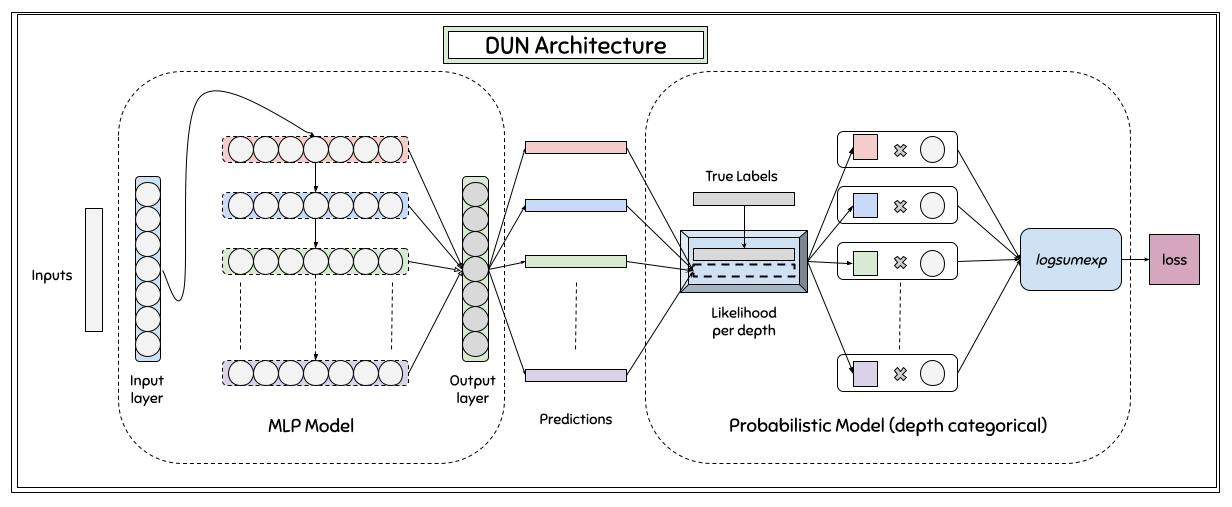

# MLP model

In [ ]:
# **********************************************************************************************
# ************************************** MLP model *********************************************
# **********************************************************************************************

class bern_MLPBlock(nn.Module):
    """Skippable MLPBlock with relu"""
    def __init__(self, width):
        super(bern_MLPBlock, self).__init__()

        self.block = nn.Sequential(nn.Linear(width, width), nn.ReLU(), nn.BatchNorm1d(num_features=width))

    def forward(self, x, b):
        """b is sample from binary variable or activation probability (soft forward)"""
        return x + b * self.block(x)

class bern_MLPBlock_nores(nn.Module):
    """Skippable MLPBlock with relu"""
    def __init__(self, width):
        super(bern_MLPBlock_nores, self).__init__()
        self.block = nn.Sequential(nn.Linear(width, width), nn.ReLU(), nn.BatchNorm1d(num_features=width))

    def forward(self, x, b):
        """b is sample from binary variable or activation probability (soft forward)"""
        return self.block(x)


class arq_uncert_fc_resnet(nn.Module):
    def __init__(self, input_dim, output_dim, width, n_layers, w_prior=None, BMA_prior=False):
        super(arq_uncert_fc_resnet, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_layer = nn.Linear(self.input_dim, width)
        self.output_layer = nn.Linear(width, self.output_dim)
        self.n_layers = n_layers
        self.width = width
        self.w_prior = w_prior
        self.BMA_prior = BMA_prior
        if not isinstance(self.w_prior, list) and self.w_prior is not None:
            self.w_prior = [self.w_prior for i in range(self.n_layers + 1)]

        self.stochstic_layers = nn.ModuleList()
        for _ in range(self.n_layers):
            self.stochstic_layers.append(bern_MLPBlock(width))

    def apply_prior(self, module, prior_f):
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.Conv1d)):
            self.loglike = self.loglike + prior_f(module.weight)
            self.loglike = self.loglike + prior_f(module.bias)

    def get_w_prior_loglike(self, k=None):
        if k is None:
            k = self.n_layers

        if self.w_prior is not None:
            self.loglike = 0
            self.input_layer.apply(lambda m: self.apply_prior(m, self.w_prior[0]))
            self.output_layer.apply(lambda m: self.apply_prior(m, self.w_prior[0]))
            self.loglikes = [self.loglike]  # append 0 for layer 0 and then remove it if necesary with BMA prior

            for idx, layer in enumerate(self.stochstic_layers[:k]):
                self.loglike = 0
                layer.apply(lambda m: self.apply_prior(m, self.w_prior[idx + 1]))
                self.loglikes.append(self.loglike)

            loglike_vec = torch.stack(self.loglikes, dim=0)

            if self.BMA_prior:
                loglike_vec = loglike_vec.unsqueeze(0).repeat(k+1, 1).tril(diagonal=0).sum(dim=1)  # size(depth)
            return loglike_vec.sum(dim=0)

        return self.input_layer.bias.data.new_zeros(k+1)

    def vec_forward(self, x, vec):
        assert vec.shape[0] == self.n_layers
        x = self.input_layer(x)
        for i in range(self.n_layers):
            x = self.stochstic_layers[i](x, vec[i])
        x = self.output_layer(x)
        return x

    def forward(self, x, depth=None):
        depth = self.n_layers if depth is None else depth
        act_vec = torch.zeros(depth+1, x.shape[0], self.output_dim).type(x.type())
        x = self.input_layer(x)
        act_vec[0] = self.output_layer(x)
        for i in range(depth):
            x = self.stochstic_layers[i](x, 1)
            act_vec[i+1] = self.output_layer(x)
        return act_vec


class arq_uncert_fc_MLP(arq_uncert_fc_resnet):
    def __init__(self, input_dim, output_dim, width, n_layers, w_prior=None, BMA_prior=False):
        super(arq_uncert_fc_MLP, self).__init__(input_dim, output_dim, width, n_layers,
                                                w_prior=w_prior, BMA_prior=BMA_prior)

        self.stochstic_layers = nn.ModuleList()
        for _ in range(self.n_layers):
            self.stochstic_layers.append(bern_MLPBlock_nores(width))


# Probability Model

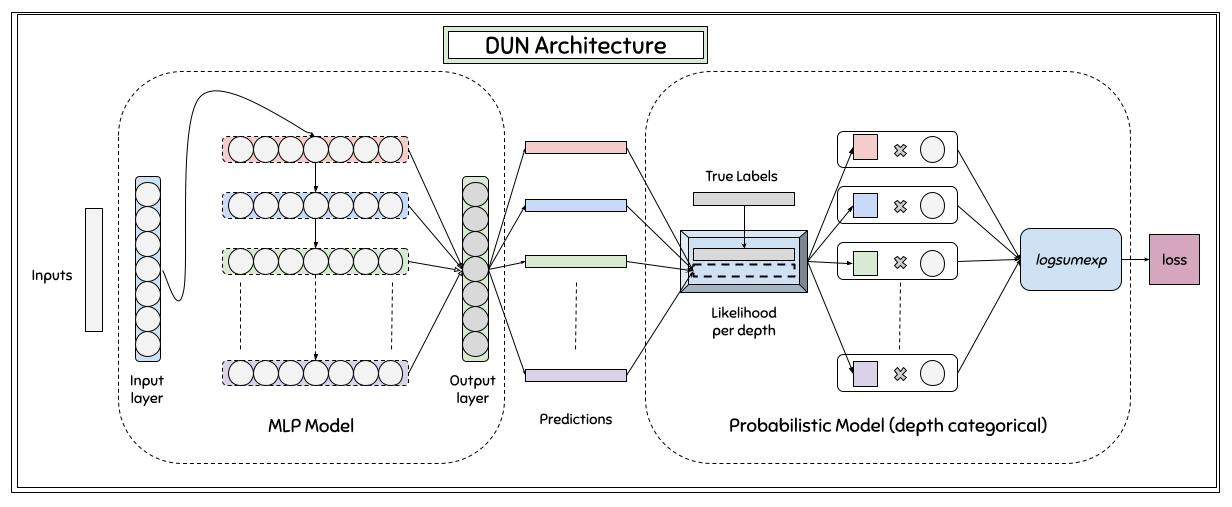

In [ ]:
# **********************************************************************************************
# ********************************** Probability Model *****************************************
# **********************************************************************************************

class depth_categorical(nn.Module):
    def __init__(self, prior_probs, prior_logprobs=None, cuda=True):
        # TODO: add option of specifying prior in terms of log_probs
        super(depth_categorical, self).__init__()

        self.prior_probs = torch.Tensor(prior_probs)
        assert self.prior_probs.sum().item() - 1 < 1e-6
        self.dims = self.prior_probs.shape[0]
        if prior_logprobs is None:
            self.logprior = self.prior_probs.log()
        else:
            self.logprior = torch.Tensor(prior_logprobs)
            self.prior_probs = self.logprior.exp()
            assert self.prior_probs.sum().item() - 1 < 1e-6

        self.current_posterior = None

        self.cuda = cuda
        if self.cuda:
            self.to_cuda()

    def to_cuda(self):
        self.prior_probs = self.prior_probs.cuda()
        self.logprior = self.logprior.cuda()

    @staticmethod
    def get_w_joint_loglike(prior_loglikes, act_vec, y, f_neg_loglike, N_train):
        """Note that if we average this to get exact joint, then all batches need to be the same size.
        Alternatively you can weigh each component with its batch size."""
        batch_size = act_vec.shape[1]
        depth = act_vec.shape[0]

        repeat_dims = [depth] + [1 for i in range(1, len(y.shape))]
        y_expand = y.repeat(*repeat_dims)  # targets are same across acts -> interleave
        act_vec_flat = act_vec.view(depth*batch_size, -1)  # flattening results in batch_n changing first
        # print("act_vec.size()", act_vec.size(), batch_size)
        # print("y_expand.size()", y.size(), y_expand.size())
        # print("act_vec_flat.size()", act_vec_flat.size())

        loglike_per_act = -f_neg_loglike(act_vec_flat, y_expand).view(depth, batch_size)

        # print(loglike_per_act.size())
        joint_loglike_per_depth = (N_train / batch_size) * loglike_per_act.sum(dim=1) + prior_loglikes  # (depth)
        # print("joint_loglike_per_depth", joint_loglike_per_depth)
        return joint_loglike_per_depth

    def get_marg_loglike(self, joint_loglike_per_depth):
        log_joint_with_depth = joint_loglike_per_depth + self.logprior
        log_marginal_over_depth = torch.logsumexp(log_joint_with_depth, dim=0)
        return log_marginal_over_depth

    def get_depth_log_posterior(self, joint_loglike_per_depth, log_marginal_over_depth=None):
        if log_marginal_over_depth is None:
            log_marginal_over_depth = self.get_marg_loglike(joint_loglike_per_depth)
        log_joint_with_depth = joint_loglike_per_depth + self.logprior
        log_depth_posteriors = log_joint_with_depth - log_marginal_over_depth
        return log_depth_posteriors

    @staticmethod
    def marginalise_d_predict(act_vec, d_posterior, depth=None, softmax=False, get_std=False):
        """ Predict while marginalising d with given distribution."""
        # TODO: switch to logprobs and log q
        assert not (softmax and get_std)
        if softmax:
            preds = F.softmax(act_vec, dim=2)
        else:
            preds = act_vec

        q = d_posterior.clone().detach()
        while len(q.shape) < len(act_vec.shape):
            q = q.unsqueeze(1)

        if get_std:
            pred_mu = (q * preds).sum(dim=0)
            model_var = (q * preds**2).sum(dim=0) - pred_mu**2
            return pred_mu, model_var.pow(0.5)

        weighed_preds = q * preds
        return weighed_preds.sum(dim=0)


class depth_categorical_VI(depth_categorical):

    def __init__(self, prior_probs, cuda=True, eps=1e-35):
        super(depth_categorical_VI, self).__init__(prior_probs, None, cuda)

        self.q_logits = nn.Parameter(torch.zeros(self.dims), requires_grad=True)
        self.eps = eps
        if cuda:
            self.to_cuda_VI()

    def to_cuda_VI(self):
        self.q_logits.data = self.q_logits.data.cuda()

    def get_q_logprobs(self):
        """Get logprobs of each depth configuration"""
        return F.log_softmax(self.q_logits, dim=0)

    def get_q_probs(self):
        """Get probs of each depth configuration"""
        return F.softmax(self.q_logits, dim=0)

    def get_KL(self):
        """KL between categorical distributions"""
        log_q = self.get_q_logprobs()
        q = self.get_q_probs().clamp(min=self.eps, max=(1 - self.eps))
        log_p = self.logprior
        print("*****************************************")
        print("log_p, q", log_p, q, log_q)
        KL = (q * (log_q - log_p)).sum(dim=0)
        print(KL)
        print("*****************************************")
        return KL

    def get_E_loglike(self, joint_loglike_per_depth):
        """Calculate ELBO with deterministic expectation."""
        q = self.get_q_probs()
        print("q", q)
        E_loglike = (q * joint_loglike_per_depth).sum(dim=0)
        return E_loglike

    def estimate_ELBO(self, prior_loglikes, act_vec, y, f_neg_loglike, N_train, Beta=1):
        """Estimate ELBO on logjoint of data and network weights"""
        joint_loglike_per_depth = depth_categorical.get_w_joint_loglike(prior_loglikes, act_vec, y,
                                                                        f_neg_loglike, N_train)
        print('Elbo joint loglike per depth', joint_loglike_per_depth)
        E_loglike = self.get_E_loglike(joint_loglike_per_depth)
        print(E_loglike)
        KL = self.get_KL()
        print("KL", KL)
        return E_loglike - Beta * KL

    def q_predict(self, act_vec, depth=None, softmax=False):
        """Predict marginalising depth with approximate posterior. Currently this will only support classification"""
        return depth_categorical.marginalise_d_predict(act_vec, self.get_q_probs(), depth=depth, softmax=softmax)



In [ ]:
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


# DUN Model (MLP + Probability Model)

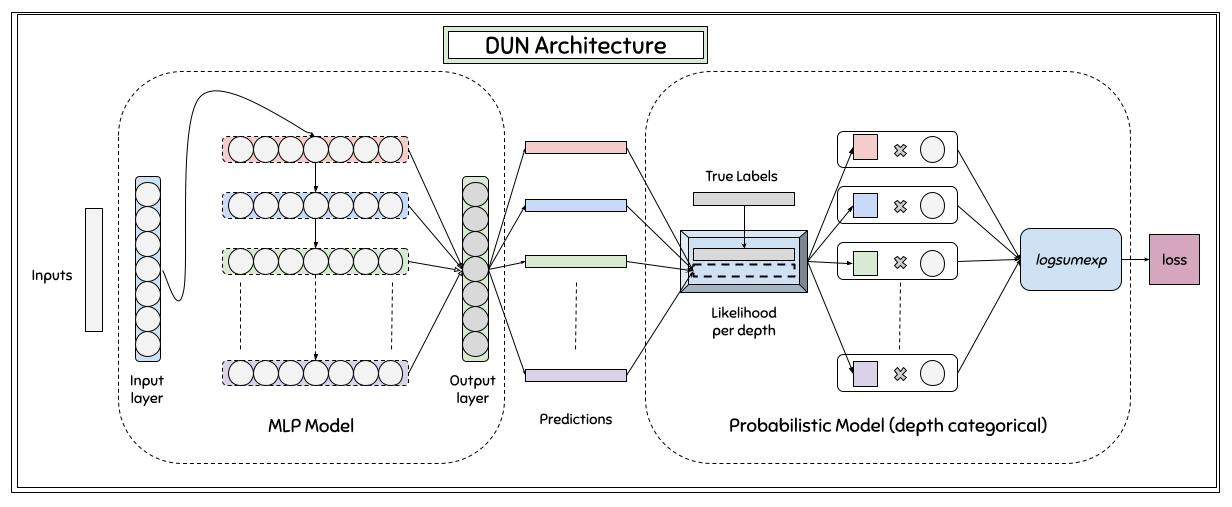

In [ ]:
# **********************************************************************************************
# ************************ DUN Model (MLP + Probability Model) *********************************
# **********************************************************************************************

class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')
        self.scheduler = None

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def make_scheduler(self, gamma=0.1, milestones=None):
        self.scheduler = MultiStepLR(self.optimizer, milestones=milestones, gamma=gamma)

    def update_lr(self):
        self.epoch += 1
        if self.scheduler is not None:
            self.scheduler.step()

    def save(self, filename, best_err=None):
        cprint('c', 'Writting %s\n' % filename)
        if best_err is None:
            try:
                torch.save({
                    'epoch': self.epoch,
                    'lr': self.lr,
                    'model': self.model,
                    'prob_model': self.prob_model,
                    'f_neg_loglike': self.f_neg_loglike,
                    'optimizer': self.optimizer,
                    'scheduler': self.scheduler}, filename)
            except Exception:
                torch.save({
                    'epoch': self.epoch,
                    'lr': self.lr,
                    'model': self.model,
                    'f_neg_loglike': self.f_neg_loglike,
                    'optimizer': self.optimizer,
                    'scheduler': self.scheduler}, filename)

        else:
            torch.save({
                'epoch': self.epoch,
                'best_err': best_err,
                'lr': self.lr,
                'model': self.model,
                'prob_model': self.prob_model,
                'f_neg_loglike': self.f_neg_loglike,
                'optimizer': self.optimizer,
                'scheduler': self.scheduler}, filename)

        # TODO: fix this try except hack here and below

    def load(self, filename, parallel=False, to_cpu=False):
        if to_cpu:
            state_dict = torch.load(filename, map_location=lambda storage, loc: storage)
        else:
            state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        if parallel:
            assert isinstance(self.model, nn.DataParallel)
            self.model = self.model.cuda()

        self.model = state_dict['model']
        try:
            self.prob_model = state_dict['prob_model']
        except Exception:
            pass
        self.f_neg_loglike = state_dict['f_neg_loglike']
        self.optimizer = state_dict['optimizer']
        self.scheduler = state_dict['scheduler']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        try:
            best_err = state_dict['best_err']
            return self.epoch, best_err
        except Exception:
            return self.epoch

class homo_Gauss_mloglike(nn.Module):
    def __init__(self, Ndims=1, sig=None):
        super(homo_Gauss_mloglike, self).__init__()
        if sig is None:
            self.log_std = nn.Parameter(torch.zeros(Ndims))
        else:
            self.log_std = nn.Parameter(torch.ones(Ndims) * np.log(sig), requires_grad=False)

    def forward(self, mu, y, model_std=None):
        sig = self.log_std.exp().clamp(min=1e-4)
        if model_std is not None:
            sig = (sig**2 + model_std**2)**0.5

        dist = Normal(mu, sig)
        return -dist.log_prob(y)




class DUN(BaseNet):
    def __init__(self, model, prob_model, N_train, lr=1e-2, momentum=0.5, weight_decay=0,
                 cuda=True, schedule=None, regression=False, pred_sig=None):
        super(DUN, self).__init__()

        cprint('y', 'DUN learnt with marginal likelihood categorical output')
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.model = model
        self.prob_model = prob_model
        self.cuda = cuda
        self.regression = regression
        self.pred_sig = pred_sig
        if self.regression:
            self.f_neg_loglike = homo_Gauss_mloglike(self.model.output_dim, self.pred_sig)
            self.f_neg_loglike_test = self.f_neg_loglike
        else:
            self.f_neg_loglike = nn.CrossEntropyLoss(reduction='none')  # This one takes logits
            self.f_neg_loglike_test = nn.NLLLoss(reduction='none')  # This one takes log probs

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = schedule
        if self.schedule is not None and len(self.schedule) > 0:
            self.make_scheduler(gamma=0.1, milestones=self.schedule)
        self.epoch = 0

    def create_net(self):
        if self.cuda:
            self.model.cuda()
            self.f_neg_loglike.cuda()

            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        param_list = list(self.model.parameters()) + list(self.prob_model.parameters())
        if self.regression and self.pred_sig is None:
            param_list += list(self.f_neg_loglike.parameters())
        self.optimizer = torch.optim.SGD(param_list, lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)

    def fit(self, x, y):
        """Optimise stchastically estimated marginal joint of parameters and weights"""
        self.model.train()
        x, y = to_variable(var=(x, y), cuda=self.cuda)
        if not self.regression:
            y = y.long()
        self.optimizer.zero_grad()

        act_vec = self.model.forward(x)
        prior_loglikes = self.model.get_w_prior_loglike(k=None)

        joint_loglike_per_depth = self.prob_model.get_w_joint_loglike(prior_loglikes, act_vec,
                                                                      y, self.f_neg_loglike, self.N_train)  # size(depth)
        # print("**joint_loglike_per_depth", joint_loglike_per_depth)
        log_marginal_over_depth = self.prob_model.get_marg_loglike(joint_loglike_per_depth)
        # print("log_marginal_over_depth-------------------------------------------------------", log_marginal_over_depth)
        loss = -log_marginal_over_depth / self.N_train
        loss.backward()
        self.optimizer.step()

        # Note this posterior is 1 it behind the parameter settings as it is estimated with acts before optim step
        log_depth_posteriors = self.prob_model.get_depth_log_posterior(joint_loglike_per_depth, log_marginal_over_depth)
        self.prob_model.current_posterior = log_depth_posteriors.exp()

        if self.regression:
            means, model_stds = depth_categorical.marginalise_d_predict(
                act_vec.data, self.prob_model.current_posterior,
                depth=None, softmax=(not self.regression), get_std=True)
            mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
            err = rms(means, y).item()
        else:
            probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                            depth=None, softmax=(not self.regression))
            mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
            pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
            err = pred.ne(y.data).sum().item() / y.shape[0]

        return log_marginal_over_depth.data.item(), mean_pred_negloglike.item(), err

    def eval(self, x, y):
        # TODO: make computationally stable with logsoftmax and nll loss -> would require making a log prediction method
        self.model.eval()
        with torch.no_grad():
            x, y = to_variable(var=(x, y), cuda=self.cuda)
            if not self.regression:
                y = y.long()

            act_vec = self.model.forward(x)

            if self.regression:
                means, model_stds = depth_categorical.marginalise_d_predict(act_vec.data,
                                                                            self.prob_model.current_posterior,
                                                                            depth=None, softmax=(not self.regression),
                                                                            get_std=True)
                mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
                err = rms(means, y).item()
            else:
                probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                                depth=None, softmax=(not self.regression))
                mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
                pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
                err = pred.ne(y.data).sum().item() / y.shape[0]

            return mean_pred_negloglike.item(), err

    def layer_predict(self, x):
        self.model.eval()
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = self.model.forward(x).data
        if not self.regression:
            out = F.softmax(out, dim=2)
        return out

    def vec_predict(self, x, bin_mat):
        """Get predictions for specific binary vector configurations"""
        self.model.eval()
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = x.data.new(bin_mat.shape[0], x.shape[0], self.model.output_dim)
        for s in range(bin_mat.shape[0]):
            out[s] = self.model.vec_forward(x, bin_mat[s,:]).data
        if not self.regression:
            probs = F.softmax(out, dim=2)
        return probs.data

    def predict(self, x, depth=None, get_std=False, return_model_std=False):
        self.model.eval()
        with torch.no_grad():
            x, = to_variable(var=(x,), cuda=self.cuda)
            # if depth is None:
            #     depth = self.model.n_layers
            act_vec = self.model.forward(x, depth=depth).data

            if get_std:
                pred_mu, model_std = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior,
                                                                             depth=depth,
                                                                             softmax=(not self.regression),
                                                                             get_std=get_std)

                if return_model_std:
                    return pred_mu.data, model_std.data
                else:
                    pred_std = (model_std ** 2 + self.f_neg_loglike.log_std.exp() ** 2).pow(0.5)
                    return pred_mu.data, pred_std.data
            else:
                probs = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior, depth=depth,
                                                                softmax=(not self.regression), get_std=get_std)
                return probs.data

    def fast_predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x, = to_variable(var=(x,), cuda=self.cuda)

            act_vec = self.model.fast_forward_impl(x, self.prob_model.current_posterior, min_prob=1e-2).data

            probs = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior, depth=None,
                                                            softmax=True, get_std=False)
            return probs.data

    def get_exact_d_posterior(self, trainloader, train_bn=False, logposterior=False):
        """Get exact posterior over depth and log marginal over weights with full forward pass"""
        if train_bn:
            self.model.train()
        else:
            self.model.eval()
        with torch.no_grad():
            prior_loglikes = self.model.get_w_prior_loglike(k=None)

            N_train = len(trainloader.dataset)
            assert N_train == self.N_train
            cum_joint_loglike_per_depth = []

            for x, y in trainloader:
                x, y = to_variable(var=(x, y), cuda=self.cuda)
                if not self.regression:
                    y = y.long()
                act_vec = self.model.forward(x)

                joint_loglike_per_depth = self.prob_model.get_w_joint_loglike(prior_loglikes, act_vec,
                                                                              y, self.f_neg_loglike,
                                                                              N_train)  # size(depth)
                cum_joint_loglike_per_depth.append((x.shape[0] / N_train) * joint_loglike_per_depth.data.unsqueeze(0))

            cum_joint_loglike_per_depth = torch.cat(cum_joint_loglike_per_depth, dim=0).sum(dim=0)
            log_marginal_over_depth = self.prob_model.get_marg_loglike(cum_joint_loglike_per_depth)
            log_depth_posteriors = self.prob_model.get_depth_log_posterior(cum_joint_loglike_per_depth,
                                                                           log_marginal_over_depth)
            if logposterior:
                exact_posterior = log_depth_posteriors
            else:
                exact_posterior = log_depth_posteriors.exp()
            return exact_posterior, log_marginal_over_depth.data.item()


# DUN VI Model (MLP + Probability Model)

In [ ]:
# **********************************************************************************************
# ************************ DUN VI Model (MLP + Probability Model) ******************************
# **********************************************************************************************

class DUN_VI(DUN):
    def __init__(self, model, prob_model, N_train, lr=1e-2, momentum=0.5, weight_decay=0, cuda=True,
                 schedule=None, regression=False, pred_sig=None):
        super(DUN_VI, self).__init__(model, prob_model, N_train, lr, momentum, weight_decay, cuda,
                                     schedule, regression, pred_sig)

    def fit(self, x, y):
        """Optimise stchastically estimated marginal joint of parameters and weights"""
        self.set_mode_train(train=True)
        x, y = to_variable(var=(x, y), cuda=self.cuda)
        if not self.regression:
            y = y.long()
        self.optimizer.zero_grad()

        act_vec = self.model.forward(x)

        prior_loglikes = self.model.get_w_prior_loglike(k=None)
        print("fit:prior_loglikes", prior_loglikes)
        ELBO = self.prob_model.estimate_ELBO(prior_loglikes, act_vec, y, self.f_neg_loglike, self.N_train, Beta=1)

        loss = -ELBO / self.N_train
        loss.backward()
        self.optimizer.step()
        self.prob_model.current_posterior = self.prob_model.get_q_probs()

        if self.regression:
            means, model_stds = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                                        depth=None, softmax=(not self.regression),
                                                                        get_std=True)
            mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
            err = rms(means, y).item()
        else:
            probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                            depth=None, softmax=(not self.regression))
            mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
            pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
            err = pred.ne(y.data).sum().item() / y.shape[0]

        # print(ELBO.shape, mean_pred_loglike.shape, err.shape)
        return ELBO.data.item(), mean_pred_negloglike.item(), err

    def get_exact_ELBO(self, trainloader, train_bn=False):
        """Get exact ELBO with full forward pass"""
        if train_bn:
            self.model.train()
        else:
            self.model.eval()
        with torch.no_grad():

            prior_loglikes = self.model.get_w_prior_loglike(k=None)

            N_train = len(trainloader.dataset)
            assert N_train == self.N_train
            cum_ELBO = []

            for x, y in trainloader:
                x, y = to_variable(var=(x, y), cuda=self.cuda)
                if not self.regression:
                    y = y.long()
                act_vec = self.model.forward(x)

                ELBO = self.prob_model.estimate_ELBO(prior_loglikes, act_vec, y, self.f_neg_loglike, N_train, Beta=1)
                cum_ELBO.append((x.shape[0] / N_train) * ELBO.data.unsqueeze(0))

            cum_ELBO = torch.cat(cum_ELBO, dim=0).sum(dim=0)
            return cum_ELBO.data.item()



In [ ]:

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out



# DUN training function

In [ ]:
# **********************************************************************************************
# ******************************* DUN training function ****************************************
# **********************************************************************************************

def train_fc_DUN(net, name, save_dir, batch_size, nb_epochs, train_loader, val_loader,
              cuda, seed, flat_ims=False, nb_its_dev=1, early_stop=None,
              track_posterior=False, track_exact_ELBO=False, tags=None,
              load_path=None, save_freq=None, q_nograd_its=0):

    # rand_name = next(tempfile._get_candidate_names())
    rand_name = ""
    basedir = os.path.join(save_dir, name, rand_name)

    media_dir = os.path.join(basedir, '/media/')
    models_dir = os.path.join(basedir, '/models/')
    mkdir(models_dir)
    mkdir(media_dir)

    if seed is not None:
        torch.manual_seed(seed)

    if cuda and seed is not None:
        torch.cuda.manual_seed(seed)

    epoch = 0

    # train
    marginal_loglike_estimate = np.zeros(nb_epochs)
    # we can use this ^ to approximately track the true value by averaging batches
    train_mean_predictive_loglike = np.zeros(nb_epochs)
    dev_mean_predictive_loglike = np.zeros(nb_epochs)
    err_train = np.zeros(nb_epochs)
    err_dev = np.zeros(nb_epochs)

    true_d_posterior = []
    approx_d_posterior = []
    true_likelihood = []
    exact_ELBO = []

    best_epoch = 0
    best_marginal_loglike = -np.inf
    # best_dev_err = -np.inf
    # best_dev_ll = -np.inf

    if q_nograd_its > 0:
        net.prob_model.q_logits.requires_grad = False

    tic0 = time.time()
    for i in range(epoch, nb_epochs):
        if q_nograd_its > 0 and i == q_nograd_its:
            net.prob_model.q_logits.requires_grad = True

        net.set_mode_train(True)
        tic = time.time()
        nb_samples = 0
        for x, y in train_loader:
            if flat_ims:
                x = x.view(x.shape[0], -1)

            marg_loglike_estimate, minus_loglike, err = net.fit(x, y)

            marginal_loglike_estimate[i] += marg_loglike_estimate * x.shape[0]
            err_train[i] += err * x.shape[0]
            train_mean_predictive_loglike[i] += minus_loglike * x.shape[0]
            nb_samples += len(x)

        marginal_loglike_estimate[i] /= nb_samples
        train_mean_predictive_loglike[i] /= nb_samples
        err_train[i] /= nb_samples

        toc = time.time()

        # ---- print
        print('\n depth approx posterior', net.prob_model.current_posterior.data.cpu().numpy())
        print("it %d/%d, ELBO/evidence %.4f, pred minus loglike = %f, err = %f" %
              (i, nb_epochs, marginal_loglike_estimate[i], train_mean_predictive_loglike[i], err_train[i]), end="")

        cprint('r', '   time: %f seconds\n' % (toc - tic))
        net.update_lr()

        if track_posterior:
            approx_d_posterior.append(net.prob_model.current_posterior.data.cpu().numpy())
            exact_posterior, log_marginal_over_depth = net.get_exact_d_posterior(train_loader, train_bn=True,
                                                                                 logposterior=False)
            true_d_posterior.append(exact_posterior.data.cpu().numpy())
            true_likelihood.append(log_marginal_over_depth)

        if track_exact_ELBO:
            exact_ELBO.append(net.get_exact_ELBO(train_loader, train_bn=True))

        # ---- dev
        if i % nb_its_dev == 0:
            tic = time.time()
            nb_samples = 0
            for x, y in val_loader:
                if flat_ims:
                    x = x.view(x.shape[0], -1)

                minus_loglike, err = net.eval(x, y)

                dev_mean_predictive_loglike[i] += minus_loglike * x.shape[0]
                err_dev[i] += err * x.shape[0]
                nb_samples += len(x)

            dev_mean_predictive_loglike[i] /= nb_samples
            err_dev[i] /= nb_samples
            toc = time.time()

            cprint('g', '     pred minus loglike = %f, err = %f\n' % (dev_mean_predictive_loglike[i], err_dev[i]), end="")
            cprint('g', '    time: %f seconds\n' % (toc - tic))

        if save_freq is not None and i % save_freq == 0:
            net.save(models_dir + '/theta_last.dat')

        if marginal_loglike_estimate[i] > best_marginal_loglike:
            best_marginal_loglike = marginal_loglike_estimate[i]

            # best_dev_ll = dev_mean_predictive_loglike[i]
            # best_dev_err = err_dev[i]
            best_epoch = i
            cprint('b', 'best marginal loglike: %f' % best_marginal_loglike)
            if i % 2 == 0:
                net.save(models_dir + '/theta_best.dat')

        if early_stop is not None and (i - best_epoch) > early_stop:
            cprint('r', '   stopped early!\n')
            break

    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(i + 1)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)

    # fig cost vs its
    if track_posterior:
        approx_d_posterior = np.stack(approx_d_posterior, axis=0)
        true_d_posterior = np.stack(true_d_posterior, axis=0)
        true_likelihood = np.stack(true_likelihood, axis=0)
    if track_exact_ELBO:
        exact_ELBO = np.stack(exact_ELBO, axis=0)

    return marginal_loglike_estimate, train_mean_predictive_loglike, dev_mean_predictive_loglike, err_train, err_dev, \
           approx_d_posterior, true_d_posterior, true_likelihood, exact_ELBO, basedir



In [ ]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)


In [ ]:
lr = 0.001
weight_decay = 0.1
# netowrk = MLP

epochs = 1000

# default parameters
batch_size = 2048
momentum = 0.9
nb_its_dev = 5

# cuda = (args.gpu is not None)
cuda = False
if cuda:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
print('cuda', cuda)


cuda False


# Load training Data

In [ ]:
# **********************************************************************************************
# ******************************* Load training Data *******************************************
# **********************************************************************************************

X_train, y_train = load_wiggle()
trainset = Datafeed(torch.Tensor(X_train), torch.Tensor(y_train), transform=None)
valset = Datafeed(torch.Tensor(X_train), torch.Tensor(y_train), transform=None)
print(X_train.shape, y_train.shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                          num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                        num_workers=0)

# Preparing method

N_train = X_train.shape[0]
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]


width = 50 		#number of hidden units to use (default: 50)', default=50)
n_layers = 2	#type=int, help='number of hidden layers to use (default: 2)', default=2)


(300, 1) (300, 1)


In [ ]:
# **********************************************************************************************
# ********************************* Define DUN model *******************************************
# **********************************************************************************************

model = arq_uncert_fc_MLP(input_dim, output_dim, width, n_layers, w_prior=None, BMA_prior=False)

prior_probs = [1 / (n_layers + 1)] * (n_layers + 1)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)
net = DUN(model, prob_model, N_train, lr=lr, momentum=momentum, cuda=cuda, schedule=None,
             regression=True, pred_sig=None, weight_decay=weight_decay)



Net:
DUN learnt with marginal likelihood categorical output
    Total params: 0.01M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


#### Brier Score, err, ll computation

In [ ]:
# import argparse
# import math
# from pathlib import Path

# import numpy as np
# import pandas as pd


# from src.datasets.image_loaders import get_image_loader
# from src.DUN.training_wrappers import DUN_VI
# from src.DUN.stochastic_img_resnets import resnet50


# def torch_onehot(y, Nclass):
#     if y.is_cuda:
#         y = y.type(torch.cuda.LongTensor)
#     else:
#         y = y.type(torch.LongTensor)
#     y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
#     # In your for loop
#     y_onehot.scatter_(1, y.unsqueeze(1), 1)
#     return y_onehot


# def class_brier(y, log_probs=None, probs=None):  # interested in this
#     assert log_probs is None or probs is None
#     if log_probs is not None:
#         probs = log_probs.exp()
#     elif probs is not None:
#         pass
#     else:
#         raise Exception('either log_probs or probs must not be None')
#     assert probs.max().item() <= (1. + 1e-4) and probs.min().item() >= 0.
#     if len(y.shape) > 1:
#         y = y.squeeze(1)
#     y_oh = torch_onehot(y, probs.shape[1])
#     brier = (probs - y_oh).pow(2).sum(dim=1).mean(dim=0)
#     return brier

# def class_err(y, model_out):
#     pred = model_out.max(dim=1, keepdim=False)[1]  # get the index of the max probability
#     err = pred.ne(y.data).sum().item() / y.shape[0]
#     return err


# def class_ll(y, log_probs=None, probs=None, eps=1e-40):
#     assert log_probs is None or probs is None
#     if log_probs is not None:
#         pass
#     elif probs is not None:
#         log_probs = torch.log(probs.clamp(min=eps))
#     else:
#         raise Exception('either log_probs or probs must not be None')
#     nll = F.nll_loss(log_probs, y, reduction='mean')
#     return -nll



# def DUN_test_stats(net, savefile, dset, data_dir, corruption=None, rotation=None, batch_size=256, cuda=True,
#                    gpu=None, MC_samples=0, workers=4, d_posterior=None):
#     assert not (corruption is not None and rotation is not None)
#     if corruption is None and rotation is None:
#         _, _, val_loader, _, _, _ = \
#             get_image_loader(dset, batch_size, cuda=cuda, workers=workers, distributed=False, data_dir=data_dir)
#     elif corruption is not None:
#         val_loader = load_corrupted_dataset(dset, severity=corruption, data_dir=data_dir, batch_size=batch_size,
#                                             cuda=cuda, workers=workers)
#     elif rotation is not None:
#         val_loader = rotate_load_dataset(dset, rotation, data_dir=data_dir,
#                                          batch_size=batch_size, cuda=cuda, workers=workers)

#     net.load(savefile)

#     if d_posterior is not None:
#         net.prob_model.current_posterior = d_posterior

#     prob_vec, target_vec = get_preds_targets_DUN(net, val_loader)

#     brier = class_brier(y=target_vec, probs=prob_vec, log_probs=None)
#     err = class_err(y=target_vec, model_out=prob_vec)
#     ll = class_ll(y=target_vec, probs=prob_vec, log_probs=None, eps=1e-40)
#     ece = class_ECE(y=target_vec, probs=prob_vec, log_probs=None, nbins=10)

#     return err, ll, brier, ece



# # check whether we already have a pandas dataframe with results, if so load
# df_path = Path(f"./results/image_results_{dataset}_{model}_{method}.csv")
# if df_path.exists():
#     df = pd.read_csv(df_path)
#     if "warmup" not in df:
#         df["warmup"] = 0
#     if "use_no_train_post" not in df:
#         df["use_no_train_post"] = False
# else:
#     dtypes = np.dtype([
#         ("method", str), ("dataset", str), ("model", str), ("wd", bool), ("p_drop", float), ("start", int),
#         ("stop", int), ("number", int), ("n_samples", int), ("warmup", int),
#         ("ll", float), ("err", float), ("ece", float), ("brier", float), ("rotation", int), ("corruption", int),
#         ("auc_roc", float), ("err_props", list), ("target_dataset", str),
#         ("batch_time", float), ("batch_size", int),
#         ("best_or_last", str), ("use_no_train_post", bool)
#     ])
#     data = np.empty(0, dtype=dtypes)
#     df = pd.DataFrame(data)

# # add to pandas dataframe by looking at models folder
# # for each row to add in pandas dataframe, run a bunch of experiments

# #models_dir default: './results'

# models_folder = Path(args.models_dir).expanduser()

# target_datasets = {
#     "MNIST": ["Fashion"],
#     "Fashion": ["MNIST", "KMNIST"],
#     "CIFAR10": ["SVHN"],
#     "CIFAR100": ["SVHN"],
#     "SVHN": ["CIFAR10"]
# }

# n_samples_ranges = {
#     "SGD": [1],
#     "ensemble": [2, 3, 5, 7, 10, 15, 20],
#     "dropout": [1, 2, 3, 5, 7, 10, 15, 20],
#     "DUN": [1]
# }

# corruptions = {
#     "CIFAR10": [(0, cor) for cor in range(1, 6)],
#     "CIFAR100": [(0, cor) for cor in range(1, 6)],
#     "MNIST": [],
#     "Fashion": [],
#     "SVHN": []
# }

# rotations = {
#     "CIFAR10": [],
#     "CIFAR100": [],
#     "MNIST": [(rot, 0) for rot in range(15, 181, 15)],
#     "Fashion": [],
#     "SVHN": []
# }

# num_classeses = {
#     "CIFAR10": 10,
#     "CIFAR100": 100,
#     "MNIST": 10,
#     "Fashion": 10,
#     "SVHN": 10
# }

# input_chanelses = {
#     "CIFAR10": 3,
#     "CIFAR100": 3,
#     "MNIST": 1,
#     "Fashion": 1,
#     "SVHN": 3
# }



# if model == "resnet50":
#     model_class = resnet50
# else:
#     raise Warning(f"Model class not implemented: {model}")

# folders = list(models_folder.glob('*'))
# print(len(folders))
# method_filt = method if method != "ensemble" else "SGD"
# folders = [folder for folder in folders if folder.match("_".join([dataset, model, method_filt, "*"]))]
# print(len(folders))

# row_to_add_proto = {"dataset": dataset, "method": method, "model": model}

# no_train_posteriors = {}

# # run experiments
# print(len(folders))
# for folder in folders:
#     folder_split = str(folder).split("/")[-1].split("_")
#     num = int(folder_split[-1])

#     wd = folder_split[-2] == "wd"
#     p_drop = 0 if method != "dropout" else float(folder_split[-3][1:])
#     start, stop = (0, 0) if method != "DUN" else map(int, folder_split[-3].split("-"))
#     if method == "DUN" and len(folder_split) == 7:
#         row_to_add_proto["warmup"] = int(folder_split[-4][-1])
#     else:
#         row_to_add_proto["warmup"] = 0

#     row_to_add_proto["number"] = num
#     # ^ This will be wrong for ensembles
#     row_to_add_proto["wd"] = wd
#     row_to_add_proto["p_drop"] = float(p_drop)

#     use_d_post_options = [False] if method != "DUN" else [True, False]
#     for use_no_train_post in use_d_post_options:
#         row_to_add_proto["use_no_train_post"] = use_no_train_post

#         for best_or_last in ["best", "last"]:
#             row_to_add_proto["best_or_last"] = best_or_last

#             #method = DUN

#             n_layers = stop - start
#             row_to_add_proto["start"] = start
#             row_to_add_proto["stop"] = stop

#             prior_probs = [1 / (n_layers)] * (n_layers)
#             prob_model = depth_categorical_VI(prior_probs, cuda=True)

#             model_base = model_class(arch_uncert=True, start_depth=start, end_depth=stop,
#                                       num_classes=num_classeses[dataset], zero_init_residual=True,
#                                       initial_conv='1x3' if dataset != "Imagenet" else '3x3', concat_pool=False,
#                                       input_chanels=input_chanelses[dataset], p_drop=0)

#             N_train = 0

#             model_obj = DUN_VI(model_base, prob_model, N_train, lr=0.1, momentum=0.9, weight_decay=1e-4, cuda=True,
#                                 schedule=None, regression=False, pred_sig=None)

#             for n_samples in n_samples_ranges[method]:

#                 num_repeats = 1

#                 for num_repeat in range(num_repeats):

#                     model_path = ("checkpoint.pth.tar" if best_or_last == "last" else "model_best.pth.tar")

#                     savefile = folder / model_path

#                     row_to_add_proto["n_samples"] = n_samples

#                     if method == "DUN" and savefile not in no_train_posteriors.keys() and use_no_train_post:
#                         _, train_loader, _, _, _, Ntrain = \
#                             get_image_loader(dataset, batch_size=args.batch_size, cuda=True, workers=workers,
#                                              data_dir=data_dir, distributed=False)

#                         model_obj.load(savefile)
#                         model_obj.N_train = Ntrain
#                         notrain_post, _ = model_obj.get_exact_d_posterior(train_loader, train_bn=False,
#                                                                           logposterior=False)
#                         no_train_posteriors[savefile] = notrain_post.data

#                     kwargs = {}
#                     if method == "DUN" and use_no_train_post:
#                         kwargs = {"d_posterior": no_train_posteriors[savefile]}

#                     # all measurements of err, ll, ece, brier
#                     for rotation, corruption in [(0, 0)] + corruptions[dataset] + rotations[dataset]:
#                         row_to_add = row_to_add_proto.copy()
#                         row_to_add.update({"rotation": rotation, "corruption": corruption})

#                         if len(df.loc[(df[list(row_to_add)] == pd.Series(row_to_add)).all(axis=1)]) > 0:
#                             continue

#                         rotation = None if rotation == 0 else rotation
#                         corruption = None if corruption == 0 else corruption
#                         err, ll, brier, ece = DUN_test_stats(model_obj, savefile, dataset, data_dir,
#                                                                 corruption=corruption, rotation=rotation,
#                                                                 batch_size=args.batch_size, cuda=True,
#                                                                 gpu=args.gpu, MC_samples=n_samples,
#                                                                 workers=workers, **kwargs)

#                         row_to_add.update({"err": err, "ll": ll.item(), "brier": brier.item(), "ece": ece})
#                         df = df.append(row_to_add, ignore_index=True)
#                         df.to_csv(df_path, index=False)

# Training DUN model 

In [ ]:
name = "initial test"
savedir = "./"
batch_size = 16
epochs = 10

print(trainloader)

marginal_loglike_estimate, train_mean_predictive_loglike, dev_mean_predictive_loglike, err_train, err_dev, \
	approx_d_posterior, true_d_posterior, true_likelihood, exact_ELBO, basedir = \
		train_fc_DUN(net, name, savedir, batch_size, epochs, trainloader, valloader,
          cuda, seed=0, flat_ims=False, nb_its_dev=nb_its_dev, early_stop=None,
          track_posterior=False, track_exact_ELBO=False, tags=None,
          load_path=None, save_freq=nb_its_dev)


# print(marginal_loglike_estimate, train_mean_predictive_loglike, dev_mean_predictive_loglike, err_train, err_dev, \
# 	approx_d_posterior, true_d_posterior, true_likelihood, exact_ELBO, basedir)



 depth approx posterior [2.22729e-29 1.00000e+00 0.00000e+00]
it 0/10, ELBO/evidence -406.0847, pred minus loglike = 1.349934, err = 0.928456   time: 0.007753 seconds

     pred minus loglike = 1.363892, err = 0.943365
    time: 0.006541 seconds

Writting /models//theta_last.dat

best marginal loglike: -406.084656
Writting /models//theta_best.dat


 depth approx posterior [1.6174914e-31 1.0000000e+00 0.0000000e+00]
it 1/10, ELBO/evidence -401.5174, pred minus loglike = 1.334680, err = 0.911936   time: 0.007150 seconds

best marginal loglike: -401.517365

 depth approx posterior [4.257159e-35 1.000000e+00 0.000000e+00]
it 2/10, ELBO/evidence -393.9524, pred minus loglike = 1.309408, err = 0.883932   time: 0.011867 seconds

best marginal loglike: -393.952362
Writting /models//theta_best.dat


 depth approx posterior [2.66e-43 1.00e+00 0.00e+00]
it 3/10, ELBO/evidence -375.9975, pred minus loglike = 1.249404, err = 0.813673   time: 0.009919 seconds

best marginal loglike: -375.997498

 d

# ToDo List 

- [x] DUN basic implementation
- [x] DUN VI implementation
- [ ] Plotting results for comparison
- [ ] Check Vision transformer implementation
- [ ] Replacing MLP model with multi layer transformer encoder
- [ ] Finding small dataset to test on

# Plotting Results

# Modified Architecture (Depth Uncertainty in Transformers)

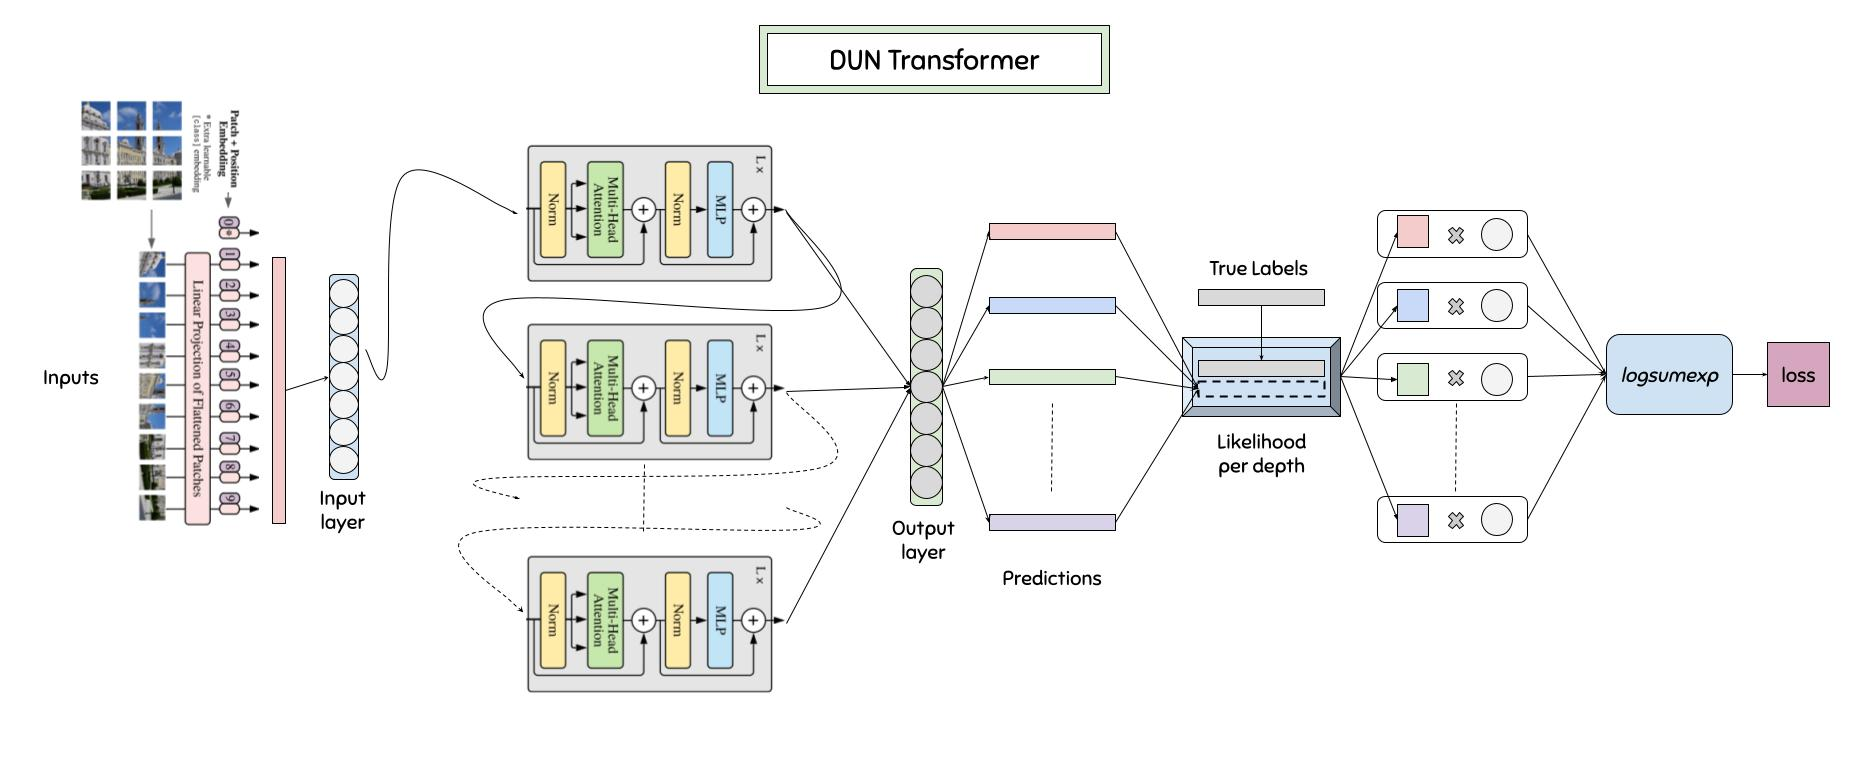

In [ ]:
!pip3 install einops

# Vision Transformer baseline

In [ ]:
# baseline taken from https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py
 
import torch
from torch import nn, einsum
import torch.nn.functional as F
 
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.autograd import Variable
 
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
 
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
 
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
 
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
 
        self.heads = heads
        self.scale = dim_head ** -0.5
 
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
 
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
 
    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max
        
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            if torch.cuda.is_available():
                mask = mask.cuda()
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = rearrange(mask, 'b i -> b () i ()') * rearrange(mask, 'b j -> b () () j')
            dots.masked_fill_(~mask, mask_value)
            del mask
 
        attn = dots.softmax(dim=-1)
 
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
 
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
            #print(x.size())
        return x
 
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
 
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )
 
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
 
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
 
        self.pool = pool
        self.to_latent = nn.Identity()
 
        self.mlp_final = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
 
    def forward(self, img, mask = None):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
 
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x, mask)
        #print(x.size())
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        #print(x.size())
        # exit()
        
        x = self.to_latent(x)

        x = self.mlp_final(x)
        return x
 
 
# # debugging ViT encoder design
ViT_encoder_svhn = ViT(image_size=32, patch_size=16, num_classes=10, dim=32, depth=5, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0., emb_dropout = 0.)
 
from torchsummary import summary
print(summary(ViT_encoder_svhn, (3, 32, 32)))
 
ViT_encoder_mnist = ViT(image_size=28, patch_size=14, num_classes=10, dim=32, depth=3, heads=8, mlp_dim=32, pool = 'cls', channels = 1, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_encoder_mnist, (1, 28, 28)))

ViT_encoder_cifar10 = ViT(image_size=32, patch_size=8, num_classes=10, dim=32, depth=6, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_encoder_cifar10, (3, 32, 32)))

ViT_encoder_cifar100 = ViT(image_size=32, patch_size=8, num_classes=100, dim=32, depth=8, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0.1, emb_dropout = 0.05)
print(summary(ViT_encoder_cifar100, (3, 32, 32)))

ViT_encoder_fashion = ViT(image_size=28, patch_size=14, num_classes=10, dim=32, depth=10, heads=8, mlp_dim=32, pool = 'cls', channels = 1, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_encoder_fashion, (1, 28, 28)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 4, 768]               0
            Linear-2                [-1, 4, 32]          24,608
           Dropout-3                [-1, 5, 32]               0
         LayerNorm-4                [-1, 5, 32]              64
            Linear-5               [-1, 5, 384]          12,288
            Linear-6                [-1, 5, 32]           4,128
           Dropout-7                [-1, 5, 32]               0
         Attention-8                [-1, 5, 32]               0
           PreNorm-9                [-1, 5, 32]               0
         Residual-10                [-1, 5, 32]               0
        LayerNorm-11                [-1, 5, 32]              64
           Linear-12                [-1, 5, 32]           1,056
             GELU-13                [-1, 5, 32]               0
          Dropout-14                [-1

In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()
    total_loss = 0

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = model(data)
        #print('Op:', output.size())
        #print('Targ:', target.size())
        criterion = nn.CrossEntropyLoss()
        #print(output.size())
        #print(target.size())
        loss = criterion(output,target)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
    loss_history.append(total_loss/total_samples)
            
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')  
    acc = 100.0 * correct_samples / total_samples
    return acc

# Vision Transformer (modified for DUN)

Added activation layer outputs similar to the DUN mlp network

In [ ]:


import torch
import torchvision
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.autograd import Variable

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max
        
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            if torch.cuda.is_available():
            	mask = mask.cuda()
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = rearrange(mask, 'b i -> b () i ()') * rearrange(mask, 'b j -> b () () j')
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, num_classes, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))

        self.mlp_final = nn.Sequential(
            nn.LayerNorm(mlp_dim),
            nn.Linear(mlp_dim, num_classes)
        )
        self.depth = depth
        self.num_classes = num_classes
        self.to_latent = nn.Identity()


    def forward(self, x, pool, mask = None):
        depth = self.n_layers if self.depth is None else self.depth
        act_vec = torch.zeros(depth, x.size(0), self.num_classes).type(x.type())
        #print(act_vec.size())
        
        # x = self.input_layer(x)
        # act_vec[0] = self.output_layer(x)
        # for i in range(depth):
        #     x = self.stochstic_layers[i](x, 1)
        #     act_vec[i+1] = self.output_layer(x)
        # return act_vec

        # act_vec[0] = self.mlp_final(x)
        for i, (attn, ff) in enumerate(self.layers):
            #print(i)
            x = attn(x, mask = mask)
            #print(x.size())
            x = ff(x)
            #print(x.size())
            temp_tens = x.mean(dim = 1) if pool == 'mean' else x[:, 0]
            #print(x.size())
            temp_tens = self.to_latent(temp_tens)
            act_vec[i] = self.mlp_final(temp_tens)
            #print("act_vec[i].size()", act_vec[i].size())
        return act_vec

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, classes=10, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, num_classes, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_features = nn.Identity()
        self.priorlg = torch.zeros(depth)


    def forward(self, img, mask = None):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        act_vec = self.transformer(x, self.pool, mask)
        #print("act_vec.size()", act_vec.size())      
        return act_vec
        # x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        # x = self.to_features(x)
        # return self.mlp_classes(x)

    def get_w_prior_loglike(self, k=0):
        # TODO: this function to add priors
        return self.priorlg


# debugging ViT encoder design
ViT_DUN_encoder_svhn = ViT(image_size=32, patch_size=16, num_classes=10, dim=32, depth=5, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0., emb_dropout = 0.)

from torchsummary import summary
print(summary(ViT_DUN_encoder_svhn, (3, 32, 32)))

ViT_DUN_encoder_mnist = ViT(image_size=28, patch_size=14, num_classes=10, dim=32, depth=3, heads=8, mlp_dim=32, pool = 'cls', channels = 1, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_DUN_encoder_mnist, (1, 28, 28)))

ViT_DUN_encoder_cifar10 = ViT(image_size=32, patch_size=8, num_classes=10, dim=32, depth=6, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_DUN_encoder_cifar10, (3, 32, 32)))

ViT_DUN_encoder_cifar100 = ViT(image_size=32, patch_size=8, num_classes=100, dim=32, depth=8, heads=8, mlp_dim=32, pool = 'cls', channels = 3, dim_head = 16, dropout = 0.1, emb_dropout = 0.05)
print(summary(ViT_DUN_encoder_cifar100, (3, 32, 32)))

ViT_DUN_encoder_fashion = ViT(image_size=28, patch_size=14, num_classes=10, dim=32, depth=10, heads=8, mlp_dim=32, pool = 'cls', channels = 1, dim_head = 16, dropout = 0., emb_dropout = 0.)
print(summary(ViT_DUN_encoder_fashion, (1, 28, 28)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 4, 768]               0
            Linear-2                [-1, 4, 32]          24,608
           Dropout-3                [-1, 5, 32]               0
         LayerNorm-4                [-1, 5, 32]              64
            Linear-5               [-1, 5, 384]          12,288
            Linear-6                [-1, 5, 32]           4,128
           Dropout-7                [-1, 5, 32]               0
         Attention-8                [-1, 5, 32]               0
           PreNorm-9                [-1, 5, 32]               0
         Residual-10                [-1, 5, 32]               0
        LayerNorm-11                [-1, 5, 32]              64
           Linear-12                [-1, 5, 32]           1,056
             GELU-13                [-1, 5, 32]               0
          Dropout-14                [-1

In [ ]:
# **********************************************************************************************
# ********************************** Probability Model *****************************************
# **********************************************************************************************

class depth_categorical(nn.Module):
    def __init__(self, prior_probs, prior_logprobs=None, cuda=True):
        # TODO: add option of specifying prior in terms of log_probs
        super(depth_categorical, self).__init__()

        self.prior_probs = torch.Tensor(prior_probs)
        assert self.prior_probs.sum().item() - 1 < 1e-6
        self.dims = self.prior_probs.shape[0]
        if prior_logprobs is None:
            self.logprior = self.prior_probs.log()
        else:
            self.logprior = torch.Tensor(prior_logprobs)
            self.prior_probs = self.logprior.exp()
            assert self.prior_probs.sum().item() - 1 < 1e-6

        self.current_posterior = None

        self.cuda = cuda
        if self.cuda:
            self.to_cuda()

    def to_cuda(self):
        self.prior_probs = self.prior_probs.cuda()
        self.logprior = self.logprior.cuda()

    @staticmethod
    def get_w_joint_loglike(prior_loglikes, act_vec, y, f_neg_loglike, N_train):
        """Note that if we average this to get exact joint, then all batches need to be the same size.
        Alternatively you can weigh each component with its batch size."""
        batch_size = act_vec.shape[1]
        depth = act_vec.shape[0]

        repeat_dims = [depth] + [1 for i in range(1, len(y.shape))]
        y_expand = y.repeat(*repeat_dims)  # targets are same across acts -> interleave
        act_vec_flat = act_vec.view(depth*batch_size, -1)  # flattening results in batch_n changing first
        # print("act_vec.size()", act_vec.size(), batch_size)
        # print("y_expand.size()", y.size(), y_expand.size())
        # print("act_vec_flat.size()", act_vec_flat.size())

        loglike_per_act = -f_neg_loglike(act_vec_flat, y_expand).view(depth, batch_size)

        # print(loglike_per_act.size())
        joint_loglike_per_depth = (N_train / batch_size) * loglike_per_act.sum(dim=1) + prior_loglikes  # (depth)
        # print("joint_loglike_per_depth", joint_loglike_per_depth)
        return joint_loglike_per_depth

    def get_marg_loglike(self, joint_loglike_per_depth):
        log_joint_with_depth = joint_loglike_per_depth + self.logprior
        log_marginal_over_depth = torch.logsumexp(log_joint_with_depth, dim=0)
        return log_marginal_over_depth

    def get_depth_log_posterior(self, joint_loglike_per_depth, log_marginal_over_depth=None):
        if log_marginal_over_depth is None:
            log_marginal_over_depth = self.get_marg_loglike(joint_loglike_per_depth)
        log_joint_with_depth = joint_loglike_per_depth + self.logprior
        log_depth_posteriors = log_joint_with_depth - log_marginal_over_depth
        return log_depth_posteriors

    @staticmethod
    def marginalise_d_predict(act_vec, d_posterior, depth=None, softmax=False, get_std=False):
        """ Predict while marginalising d with given distribution."""
        # TODO: switch to logprobs and log q
        assert not (softmax and get_std)
        if softmax:
            preds = F.softmax(act_vec, dim=2)
        else:
            preds = act_vec

        q = d_posterior.clone().detach()
        while len(q.shape) < len(act_vec.shape):
            q = q.unsqueeze(1)

        if get_std:
            pred_mu = (q * preds).sum(dim=0)
            model_var = (q * preds**2).sum(dim=0) - pred_mu**2
            return pred_mu, model_var.pow(0.5)

        weighed_preds = q * preds
        return weighed_preds.sum(dim=0)


class depth_categorical_VI(depth_categorical):

    def __init__(self, prior_probs, cuda=True, eps=1e-35):
        super(depth_categorical_VI, self).__init__(prior_probs, None, cuda)

        self.q_logits = nn.Parameter(torch.zeros(self.dims), requires_grad=True)
        self.eps = eps
        if cuda:
            self.to_cuda_VI()

    def to_cuda_VI(self):
        self.q_logits.data = self.q_logits.data.cuda()

    def get_q_logprobs(self):
        """Get logprobs of each depth configuration"""
        return F.log_softmax(self.q_logits, dim=0)

    def get_q_probs(self):
        """Get probs of each depth configuration"""
        return F.softmax(self.q_logits, dim=0)

    def get_KL(self):
        """KL between categorical distributions"""
        log_q = self.get_q_logprobs()
        q = self.get_q_probs().clamp(min=self.eps, max=(1 - self.eps))
        log_p = self.logprior
        #print("*****************************************")
        #sprint("log_p, q", log_p, q, log_q)
        KL = (q * (log_q - log_p)).sum(dim=0)
        #print(KL)
        #print("*****************************************")
        return KL

    def get_E_loglike(self, joint_loglike_per_depth):
        """Calculate ELBO with deterministic expectation."""
        q = self.get_q_probs()
        #print("q", q)
        E_loglike = (q * joint_loglike_per_depth).sum(dim=0)
        return E_loglike

    def estimate_ELBO(self, prior_loglikes, act_vec, y, f_neg_loglike, N_train, Beta=1):
        """Estimate ELBO on logjoint of data and network weights"""
        joint_loglike_per_depth = depth_categorical.get_w_joint_loglike(prior_loglikes, act_vec, y,
                                                                        f_neg_loglike, N_train)
        #print('Elbo joint loglike per depth', joint_loglike_per_depth)
        E_loglike = self.get_E_loglike(joint_loglike_per_depth)
        #print(E_loglike)
        KL = self.get_KL()
        #print("KL", KL)
        return E_loglike - Beta * KL

    def q_predict(self, act_vec, depth=None, softmax=False):
        """Predict marginalising depth with approximate posterior. Currently this will only support classification"""
        return depth_categorical.marginalise_d_predict(act_vec, self.get_q_probs(), depth=depth, softmax=softmax)


In [ ]:
import os
import sys
import pickle

import numpy as np
import torch
from torch.autograd import Variable
import torch.utils.data as data
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn as nn
from PIL import Image


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def np_get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape) + [nb_classes])


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out


def rms(x, y):
    return F.mse_loss(x, y, reduction='mean').sqrt()


def get_rms(mu, y, y_means, y_stds):
    x_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    assert x_un.shape[1] == 1
    assert y_un.shape[1] == 1
    return rms(x_un, y_un)


def get_gauss_loglike(mu, sigma, y, y_means, y_stds):
    mu_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    sigma_un = sigma * y_stds
    assert mu_un.shape[1] == 1
    assert y_un.shape[1] == 1
    assert sigma_un.shape[1] == 1
    dist = Normal(mu_un, sigma_un)
    return dist.log_prob(y_un).mean(axis=0).item()  # mean over datapoints


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return (nb_samples + (-nb_samples % batch_size)) / batch_size  # roundup division

    return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))

    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

In [ ]:
# **********************************************************************************************
# ************************ DUN Model (MLP + Probability Model) *********************************
# **********************************************************************************************

class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')
        self.scheduler = None

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def make_scheduler(self, gamma=0.1, milestones=None):
        self.scheduler = MultiStepLR(self.optimizer, milestones=milestones, gamma=gamma)

    def update_lr(self):
        self.epoch += 1
        if self.scheduler is not None:
            self.scheduler.step()

    def save(self, filename, best_err=None):
        cprint('c', 'Writting %s\n' % filename)
        if best_err is None:
            try:
                torch.save({
                    'epoch': self.epoch,
                    'lr': self.lr,
                    'model': self.model,
                    'prob_model': self.prob_model,
                    'f_neg_loglike': self.f_neg_loglike,
                    'optimizer': self.optimizer,
                    'scheduler': self.scheduler}, filename)
            except Exception:
                torch.save({
                    'epoch': self.epoch,
                    'lr': self.lr,
                    'model': self.model,
                    'f_neg_loglike': self.f_neg_loglike,
                    'optimizer': self.optimizer,
                    'scheduler': self.scheduler}, filename)

        else:
            torch.save({
                'epoch': self.epoch,
                'best_err': best_err,
                'lr': self.lr,
                'model': self.model,
                'prob_model': self.prob_model,
                'f_neg_loglike': self.f_neg_loglike,
                'optimizer': self.optimizer,
                'scheduler': self.scheduler}, filename)

        # TODO: fix this try except hack here and below

    def load(self, filename, parallel=False, to_cpu=False):
        if to_cpu:
            state_dict = torch.load(filename, map_location=lambda storage, loc: storage)
        else:
            state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        if parallel:
            assert isinstance(self.model, nn.DataParallel)
            self.model = self.model.cuda()

        self.model = state_dict['model']
        try:
            self.prob_model = state_dict['prob_model']
        except Exception:
            pass
        self.f_neg_loglike = state_dict['f_neg_loglike']
        self.optimizer = state_dict['optimizer']
        self.scheduler = state_dict['scheduler']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        try:
            best_err = state_dict['best_err']
            return self.epoch, best_err
        except Exception:
            return self.epoch

class homo_Gauss_mloglike(nn.Module):
    def __init__(self, Ndims=1, sig=None):
        super(homo_Gauss_mloglike, self).__init__()
        if sig is None:
            self.log_std = nn.Parameter(torch.zeros(Ndims))
        else:
            self.log_std = nn.Parameter(torch.ones(Ndims) * np.log(sig), requires_grad=False)

    def forward(self, mu, y, model_std=None):
        sig = self.log_std.exp().clamp(min=1e-4)
        if model_std is not None:
            sig = (sig**2 + model_std**2)**0.5

        dist = Normal(mu, sig)
        return -dist.log_prob(y)




class DUN(BaseNet):
    def __init__(self, model, prob_model, N_train, lr=1e-2, momentum=0.5, weight_decay=0,
                 cuda=True, schedule=None, regression=False, pred_sig=None):
        super(DUN, self).__init__()

        #cprint('y', 'DUN learnt with marginal likelihood categorical output')
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.model = model
        self.prob_model = prob_model
        self.cuda = cuda
        self.regression = regression
        self.pred_sig = pred_sig
        if self.regression:
            self.f_neg_loglike = homo_Gauss_mloglike(self.model.output_dim, self.pred_sig)
            self.f_neg_loglike_test = self.f_neg_loglike
        else:
            self.f_neg_loglike = nn.CrossEntropyLoss(reduction='none')  # This one takes logits
            self.f_neg_loglike_test = nn.NLLLoss(reduction='none')  # This one takes log probs

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = schedule
        if self.schedule is not None and len(self.schedule) > 0:
            self.make_scheduler(gamma=0.1, milestones=self.schedule)
        self.epoch = 0

    def create_net(self):
        if self.cuda:
            self.model.cuda()
            self.f_neg_loglike.cuda()

            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        param_list = list(self.model.parameters()) + list(self.prob_model.parameters())
        if self.regression and self.pred_sig is None:
            param_list += list(self.f_neg_loglike.parameters())
        self.optimizer = torch.optim.SGD(param_list, lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)

    def fit(self, x, y):
        """Optimise stchastically estimated marginal joint of parameters and weights"""
        self.model.train()
        x, y = to_variable(var=(x, y), cuda=self.cuda)
        if not self.regression:
            y = y.long()
        self.optimizer.zero_grad()

        act_vec = self.model.forward(x)
        prior_loglikes = self.model.get_w_prior_loglike(k=None)

        joint_loglike_per_depth = self.prob_model.get_w_joint_loglike(prior_loglikes, act_vec,
                                                                      y, self.f_neg_loglike, self.N_train)  # size(depth)
        # print("**joint_loglike_per_depth", joint_loglike_per_depth)
        log_marginal_over_depth = self.prob_model.get_marg_loglike(joint_loglike_per_depth)
        # print("log_marginal_over_depth-------------------------------------------------------", log_marginal_over_depth)
        loss = -log_marginal_over_depth / self.N_train
        loss.backward()
        self.optimizer.step()

        # Note this posterior is 1 it behind the parameter settings as it is estimated with acts before optim step
        log_depth_posteriors = self.prob_model.get_depth_log_posterior(joint_loglike_per_depth, log_marginal_over_depth)
        self.prob_model.current_posterior = log_depth_posteriors.exp()

        if self.regression:
            means, model_stds = depth_categorical.marginalise_d_predict(
                act_vec.data, self.prob_model.current_posterior,
                depth=None, softmax=(not self.regression), get_std=True)
            mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
            err = rms(means, y).item()
        else:
            probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                            depth=None, softmax=(not self.regression))
            mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
            pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
            err = pred.ne(y.data).sum().item() / y.shape[0]

        return log_marginal_over_depth.data.item(), mean_pred_negloglike.item(), err

    def eval(self, x, y):
        # TODO: make computationally stable with logsoftmax and nll loss -> would require making a log prediction method
        self.model.eval()
        with torch.no_grad():
            x, y = to_variable(var=(x, y), cuda=self.cuda)
            if not self.regression:
                y = y.long()

            act_vec = self.model.forward(x)

            if self.regression:
                means, model_stds = depth_categorical.marginalise_d_predict(act_vec.data,
                                                                            self.prob_model.current_posterior,
                                                                            depth=None, softmax=(not self.regression),
                                                                            get_std=True)
                mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
                err = rms(means, y).item()
            else:
                probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                                depth=None, softmax=(not self.regression))
                mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
                pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
                err = pred.ne(y.data).sum().item() / y.shape[0]

            return mean_pred_negloglike.item(), err

    def layer_predict(self, x):
        self.model.eval()
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = self.model.forward(x).data
        if not self.regression:
            out = F.softmax(out, dim=2)
        return out

    def vec_predict(self, x, bin_mat):
        """Get predictions for specific binary vector configurations"""
        self.model.eval()
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = x.data.new(bin_mat.shape[0], x.shape[0], self.model.output_dim)
        for s in range(bin_mat.shape[0]):
            out[s] = self.model.vec_forward(x, bin_mat[s,:]).data
        if not self.regression:
            probs = F.softmax(out, dim=2)
        return probs.data

    def predict(self, x, depth=None, get_std=False, return_model_std=False):
        self.model.eval()
        with torch.no_grad():
            x, = to_variable(var=(x,), cuda=self.cuda)
            # if depth is None:
            #     depth = self.model.n_layers
            act_vec = self.model.forward(x, depth=depth).data

            if get_std:
                pred_mu, model_std = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior,
                                                                             depth=depth,
                                                                             softmax=(not self.regression),
                                                                             get_std=get_std)

                if return_model_std:
                    return pred_mu.data, model_std.data
                else:
                    pred_std = (model_std ** 2 + self.f_neg_loglike.log_std.exp() ** 2).pow(0.5)
                    return pred_mu.data, pred_std.data
            else:
                probs = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior, depth=depth,
                                                                softmax=(not self.regression), get_std=get_std)
                return probs.data

    def fast_predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x, = to_variable(var=(x,), cuda=self.cuda)

            act_vec = self.model.fast_forward_impl(x, self.prob_model.current_posterior, min_prob=1e-2).data

            probs = depth_categorical.marginalise_d_predict(act_vec, self.prob_model.current_posterior, depth=None,
                                                            softmax=True, get_std=False)
            return probs.data

    def get_exact_d_posterior(self, trainloader, train_bn=False, logposterior=False):
        """Get exact posterior over depth and log marginal over weights with full forward pass"""
        if train_bn:
            self.model.train()
        else:
            self.model.eval()
        with torch.no_grad():
            prior_loglikes = self.model.get_w_prior_loglike(k=None)

            N_train = len(trainloader.dataset)
            assert N_train == self.N_train
            cum_joint_loglike_per_depth = []

            for x, y in trainloader:
                x, y = to_variable(var=(x, y), cuda=self.cuda)
                if not self.regression:
                    y = y.long()
                act_vec = self.model.forward(x)

                joint_loglike_per_depth = self.prob_model.get_w_joint_loglike(prior_loglikes, act_vec,
                                                                              y, self.f_neg_loglike,
                                                                              N_train)  # size(depth)
                cum_joint_loglike_per_depth.append((x.shape[0] / N_train) * joint_loglike_per_depth.data.unsqueeze(0))

            cum_joint_loglike_per_depth = torch.cat(cum_joint_loglike_per_depth, dim=0).sum(dim=0)
            log_marginal_over_depth = self.prob_model.get_marg_loglike(cum_joint_loglike_per_depth)
            log_depth_posteriors = self.prob_model.get_depth_log_posterior(cum_joint_loglike_per_depth,
                                                                           log_marginal_over_depth)
            if logposterior:
                exact_posterior = log_depth_posteriors
            else:
                exact_posterior = log_depth_posteriors.exp()
            return exact_posterior, log_marginal_over_depth.data.item()


In [ ]:
# **********************************************************************************************
# ************************ DUN VI Model (MLP + Probability Model) ******************************
# **********************************************************************************************

class DUN_VI(DUN):
    def __init__(self, model, prob_model, N_train, lr=1e-2, momentum=0.5, weight_decay=0, cuda=True,
                 schedule=None, regression=False, pred_sig=None):
        super(DUN_VI, self).__init__(model, prob_model, N_train, lr, momentum, weight_decay, cuda,
                                     schedule, regression, pred_sig)

    def fit(self, x, y):
        """Optimise stchastically estimated marginal joint of parameters and weights"""
        self.set_mode_train(train=True)
        x, y = to_variable(var=(x, y), cuda=self.cuda)
        if not self.regression:
            y = y.long()
        self.optimizer.zero_grad()

        act_vec = self.model.forward(x)

        prior_loglikes = self.model.get_w_prior_loglike(k=None)
        #print("fit:prior_loglikes", prior_loglikes)
        ELBO = self.prob_model.estimate_ELBO(prior_loglikes, act_vec, y, self.f_neg_loglike, self.N_train, Beta=1)

        loss = -ELBO / self.N_train
        loss.backward()
        self.optimizer.step()
        self.prob_model.current_posterior = self.prob_model.get_q_probs()

        if self.regression:
            means, model_stds = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                                        depth=None, softmax=(not self.regression),
                                                                        get_std=True)
            mean_pred_negloglike = self.f_neg_loglike(means, y, model_std=model_stds).mean(dim=0).data
            err = rms(means, y).item()
        else:
            probs = depth_categorical.marginalise_d_predict(act_vec.data, self.prob_model.current_posterior,
                                                            depth=None, softmax=(not self.regression))
            mean_pred_negloglike = self.f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
            pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
            err = pred.ne(y.data).sum().item() / y.shape[0]

        # print(ELBO.shape, mean_pred_loglike.shape, err.shape)
        return ELBO.data.item(), mean_pred_negloglike.item(), err

    def get_exact_ELBO(self, trainloader, train_bn=False):
        """Get exact ELBO with full forward pass"""
        if train_bn:
            self.model.train()
        else:
            self.model.eval()
        with torch.no_grad():

            prior_loglikes = self.model.get_w_prior_loglike(k=None)

            N_train = len(trainloader.dataset)
            assert N_train == self.N_train
            cum_ELBO = []

            for x, y in trainloader:
                x, y = to_variable(var=(x, y), cuda=self.cuda)
                if not self.regression:
                    y = y.long()
                act_vec = self.model.forward(x)

                ELBO = self.prob_model.estimate_ELBO(prior_loglikes, act_vec, y, self.f_neg_loglike, N_train, Beta=1)
                cum_ELBO.append((x.shape[0] / N_train) * ELBO.data.unsqueeze(0))

            cum_ELBO = torch.cat(cum_ELBO, dim=0).sum(dim=0)
            return cum_ELBO.data.item()


In [ ]:
def evaluate_ViT_DUN(model, prob_model, net, test_loader):
  count = 0
  correct_prediction=0
  print(len(test_loader))
  act_vectors = []
  labels = []
  predictions = []
  sample_size = len(test_loader)
  start_time = time.time()
  for x, y in test_loader:
    act_vec = model(x)
    # print(act_vec.shape)
    act_vectors.append(act_vec.detach().numpy())
    labels.append(y)
    # continue
    probs = depth_categorical.marginalise_d_predict(act_vec.data, prob_model.current_posterior,depth=None)
    f_neg_loglike_test = nn.NLLLoss(reduction='none')
    mean_pred_negloglike = f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
    pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
    err = pred.ne(y.data).sum().item() / y.shape[0]
    # print(pred==y)
    predictions.append(pred)
    if pred==y:
      correct_prediction += 1
    # print('Target=',y, 'Probabilities:', probs)
    # if count==100:
    #   break
    count+=1
    i = count
    eta = (time.time() - start_time) * (sample_size - i) / i
    sys.stdout.write('\r')
    sys.stdout.write(
              "[%-40s] %d%% [%d/%d]\t ETA: %d Hrs %d Minutes %d Seconds" % (
                      '=' * int(40 * i / sample_size) + '>',
                      100 * i / sample_size,
                      i, sample_size,
                      int(eta // 3600), (eta % 3600) // 60,
                      (eta % 3600) % 60))
    sys.stdout.flush()

  accuracy = 100 * correct_prediction / len(test_loader)
      # trainset, not train_loader
      # probably x in your case

  print("Accuracy = {}".format(accuracy))
  return accuracy, act_vectors, labels, predictions

In [ ]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def train_loop(net, dname, data_dir, epochs=90, workers=4, savedir='./',
               save_all_epochs=False, q_nograd_its=0, batch_size=256):
    mkdir(savedir)
    global best_err1

    DOWNLOAD_PATH = data_dir
    BATCH_SIZE_TRAIN = 100
    BATCH_SIZE_TEST = 1000

    if dname=='MNIST':
      transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

      train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                            transform=transform_mnist)
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

      test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                            transform=transform_mnist)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
    elif dname=='CIFAR10':
      transform_cifar10 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

      train_set = torchvision.datasets.CIFAR10(DOWNLOAD_PATH, train=True, download=True,
                                            transform=transform_cifar10)
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

      test_set = torchvision.datasets.CIFAR10(DOWNLOAD_PATH, train=False, download=True,
                                            transform=transform_cifar10)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
    elif dname=='CIFAR100':
      transform_cifar100 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762))])

      train_set = torchvision.datasets.CIFAR100(DOWNLOAD_PATH, train=True, download=True,
                                            transform=transform_cifar100)
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

      test_set = torchvision.datasets.CIFAR100(DOWNLOAD_PATH, train=False, download=True,
                                            transform=transform_cifar100)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
    elif dname=='SVHN':
      transform_svhn = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))])

      train_set = torchvision.datasets.SVHN(DOWNLOAD_PATH, split='train', download=True,
                                            transform=transform_svhn)
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

      test_set = torchvision.datasets.SVHN(DOWNLOAD_PATH, split='test', download=True,
                                            transform=transform_svhn)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
    elif dname=='Fashion':
      transform_fashion = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean=(0.2860,), std=(0.3530,))])

      train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                            transform=transform_fashion)
      train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

      test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                            transform=transform_fashion)
      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

    net.N_train = len(train_loader)

    start_epoch = 0

    marginal_loglike = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    dev_loss = np.zeros(epochs)

    err_train = np.zeros(epochs)
    err_dev = np.zeros(epochs)

    if q_nograd_its > 0:
        net.prob_model.q_logits.requires_grad = False

    sample_size = epochs-start_epoch
    start_time = time.time()
    epoch_acc_test = []
    for epoch in range(start_epoch, epochs):
        if q_nograd_its > 0 and epoch == q_nograd_its:
            net.prob_model.q_logits.requires_grad = True

        tic = time.time()
        nb_samples = 0
        for x, y in train_loader:
            marg_loglike_estimate, minus_loglike, err = net.fit(x, y)
            marginal_loglike[epoch] += marg_loglike_estimate * x.shape[0]
            err_train[epoch] += err * x.shape[0]
            train_loss[epoch] += minus_loglike * x.shape[0]
            nb_samples += len(x)

        marginal_loglike[epoch] /= nb_samples
        train_loss[epoch] /= nb_samples
        err_train[epoch] /= nb_samples
        toc = time.time()

        # ---- print
        print('\n depth approx posterior', net.prob_model.current_posterior.data.cpu().numpy())
        print("it %d/%d, ELBO/evidence %.4f, pred minus loglike = %f, err = %f" %
              (epoch, epochs, marginal_loglike[epoch], train_loss[epoch], err_train[epoch]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))

        net.update_lr()

        num_samples_test=0
        correct_prediction = 0
        for x,y in test_loader:
          act_vec = net.model(x)
          # print(act_vec.shape)
          #act_vectors.append(act_vec.detach().numpy())
          #labels.append(y)
          # continue
          probs = depth_categorical.marginalise_d_predict(act_vec.data, prob_model.current_posterior,depth=None, get_std=False)
          f_neg_loglike_test = nn.NLLLoss(reduction='none')
          mean_pred_negloglike = f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
          pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
          err = pred.ne(y.data).sum().item() / y.shape[0]
          soft_probs = F.softmax(probs, dim=1)
          pred_np = pred.numpy()
          probs_np = soft_probs.numpy()[0]
          y_np = y.numpy()
          #print('PY:', pred, y)
          #stds.append(std[0][pred])
          correct_prediction += np.sum(pred_np == y_np)
          num_samples_test+=len(y_np)
        #print('Prop:', correct_prediction, num_samples_test)
        epoch_acc_test.append(100.0*correct_prediction/num_samples_test)
        print('Test Accuracy:', 100.0*correct_prediction/num_samples_test)

        # ---- dev
        tic = time.time()
        nb_samples = 0
        for x, y in test_loader:
            minus_loglike, err = net.eval(x, y)

            dev_loss[epoch] += minus_loglike * x.shape[0]
            err_dev[epoch] += err * x.shape[0]
            nb_samples += len(x)

        dev_loss[epoch] /= nb_samples
        err_dev[epoch] /= nb_samples
        
        

        toc = time.time()

        cprint('g', '     pred minus loglike = %f, err = %f\n' % (dev_loss[epoch], err_dev[epoch]), end="")
        cprint('g', '    time: %f seconds\n' % (toc - tic))

        filename = 'checkpoint.pth.tar'
        if save_all_epochs:
            filename = str(epoch) + '_' + filename
        net.save(os.path.join(savedir, filename), best_err1)
        if err_dev[epoch] < best_err1:
            best_err1 = err_dev[epoch]
            cprint('b', 'best top1 dev err: %f' % err_dev[epoch])
            shutil.copyfile(os.path.join(savedir, filename), os.path.join(savedir, 'model_best.pth.tar'))
        
        i = epoch + 1
        eta = (time.time() - start_time) * (sample_size - i) / i
        sys.stdout.write('\r')
        sys.stdout.write(
                  "[%-40s] %d%% [%d/%d]\t ETA: %d Hrs %d Minutes %d Seconds" % (
                          '=' * int(40 * i / sample_size) + '>',
                          100 * i / sample_size,
                          i, sample_size,
                          int(eta // 3600), (eta % 3600) // 60,
                          (eta % 3600) % 60))
        sys.stdout.flush()
    end_time = time.time()
    print('Execution Time: ', (end_time - start_time))
    all_results = [marginal_loglike, err_train, train_loss, err_dev, dev_loss]
    return all_results, epoch_acc_test

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()

In [ ]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])


def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x


In [ ]:
def evaluate_ViT_on_rotated(model, test_loader, test_sample_size=None, use_gpu=False):
  rot_accuracy = []
  rot_angles = []
  pred_avg_stds = []
  rot_acc_unc = []
  start_time = time.time()
  sample_size = 181//5
  for index, rot_angle in enumerate(range(0, 181, 5)):
    correct_prediction=0
    # print(len(test_loader))
    act_vectors = []
    labels = []
    dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    predictions = []
    count = 0
    diff_acc = 0
    for x, y in test_loader:
      if use_gpu:
              x = x.cuda()
              y = y.cuda()
              model.cuda()
      # plt.imshow(x.squeeze(0).permute(1,2,0).squeeze(2), cmap='gray')
      rotated_im = rot_img(x, rot_angle/180 * np.pi, dtype) # Rotate image
      # plt.imshow(rotated_im.squeeze(0).permute(1,2,0).squeeze(2), cmap='gray')
      # print(x.shape, rotated_im.shape)
      x = rotated_im
      # break
      act_vec = model(x)

      output = F.softmax(model(x), dim=1)
      pred = output.max(dim=1, keepdim=False)[1]
      pred_np = pred.numpy()
      outp_np = output.detach().numpy()
      y_np = y.numpy()
      #print('Sum:', np.sum(outp_np,axis=0))
      for i in range(len(y_np)):
        diff_acc+=(1-outp_np[i][y_np[i]])
      correct_prediction += np.sum(pred_np == y_np)
      count+=len(y_np)
      # print('Target=',y, 'Probabilities:', probs)
      if test_sample_size:
        if count >= test_sample_size:
          break
      # if count==100:
      #   break
    #print('NumPT:', len(test_loader), correct_prediction)
    accuracy = 100 * correct_prediction / count
    rot_acc_unc.append(100*diff_acc/count)
        # trainset, not train_loader
        # probably x in your case

    # print("Accuracy = {}".format(accuracy))
    rot_accuracy.append(accuracy)
    rot_angles.append(rot_angle)
    
    i = index + 1
    eta = (time.time() - start_time) * (sample_size - i) / i
    sys.stdout.write('\r')
    sys.stdout.write(
              "[%-40s] %d%% [%d/%d]\t ETA: %d Hrs %d Minutes %d Seconds" % (
                      '=' * int(40 * i / sample_size) + '>',
                      100 * i / sample_size,
                      i, sample_size,
                      int(eta // 3600), (eta % 3600) // 60,
                      (eta % 3600) % 60))
    sys.stdout.flush()
      
  return rot_accuracy, rot_angles, rot_acc_unc

In [ ]:
def evaluate_ViT_DUN_on_rotated(model, prob_model, net, test_loader, test_sample_size=None):
  rot_accuracy = []
  rot_angles = []
  pred_avg_stds = []
  rot_acc_unc = []
  start_time = time.time()
  sample_size = 181//5
  for index, rot_angle in enumerate(range(0, 181, 5)):
    correct_prediction=0
    # print(len(test_loader))
    act_vectors = []
    labels = []
    dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    predictions = []
    stds = []
    count = 0
    diff_acc = 0
    correct_prediction = 0
    for x, y in test_loader:
      # plt.imshow(x.squeeze(0).permute(1,2,0).squeeze(2), cmap='gray')
      rotated_im = rot_img(x, rot_angle/180 * np.pi, dtype) # Rotate image
      # plt.imshow(rotated_im.squeeze(0).permute(1,2,0).squeeze(2), cmap='gray')
      # print(x.shape, rotated_im.shape)
      x = rotated_im
      # break
      act_vec = model(x)
      # print(act_vec.shape)
      act_vectors.append(act_vec.detach().numpy())
      labels.append(y)
      # continue
      probs, std = depth_categorical.marginalise_d_predict(act_vec.data, prob_model.current_posterior,depth=None, get_std=True)
      f_neg_loglike_test = nn.NLLLoss(reduction='none')
      mean_pred_negloglike = f_neg_loglike_test(torch.log(probs), y).mean(dim=0).data
      pred = probs.max(dim=1, keepdim=False)[1]  # get the index of the max probability
      err = pred.ne(y.data).sum().item() / y.shape[0]
      pred_np = pred.numpy()
      outp_np = probs.detach().numpy()
      y_np = y.numpy()
      #print('Sum:', np.sum(outp_np,axis=0))
      for i in range(len(y_np)):
        diff_acc+=(1-outp_np[i][y_np[i]])
      #print('PY:', pred_np, y_np)
      correct_prediction += np.sum(pred_np == y_np)
      count+=len(y_np)
      # print(pred==y)
      stds.append(std[0][pred])
      # print('Target=',y, 'Probabilities:', probs)
      if test_sample_size:
        if count >= test_sample_size:
          break
      # if count==100:
      #   break

    accuracy = 100 * correct_prediction / count
        # trainset, not train_loader
        # probably x in your case

    # print("Accuracy = {}".format(accuracy))
    rot_accuracy.append(accuracy)
    rot_angles.append(rot_angle)
    rot_acc_unc.append(100*diff_acc/count)
    b = torch.tensor(stds)
    b[b != b] = 0 
    pred_avg_stds.append(torch.sum(b)/10000)

    i = index + 1
    eta = (time.time() - start_time) * (sample_size - i) / i
    sys.stdout.write('\r')
    sys.stdout.write(
              "[%-40s] %d%% [%d/%d]\t ETA: %d Hrs %d Minutes %d Seconds" % (
                      '=' * int(40 * i / sample_size) + '>',
                      100 * i / sample_size,
                      i, sample_size,
                      int(eta // 3600), (eta % 3600) // 60,
                      (eta % 3600) % 60))
    sys.stdout.flush()
      
  return rot_accuracy, rot_angles, pred_avg_stds, rot_acc_unc

## Training Vision Transformer over MNIST Dataset


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!
Epoch: 1


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[    0/60000 (  0%)]  Loss: 2.5879
[10000/60000 ( 17%)]  Loss: 0.1904
[20000/60000 ( 33%)]  Loss: 0.1395
[30000/60000 ( 50%)]  Loss: 0.1239
[40000/60000 ( 67%)]  Loss: 0.1519
[50000/60000 ( 83%)]  Loss: 0.2465

Average test loss: 0.1121  Accuracy: 9657/10000 (96.57%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1285
[10000/60000 ( 17%)]  Loss: 0.0608
[20000/60000 ( 33%)]  Loss: 0.1284
[30000/60000 ( 50%)]  Loss: 0.1224
[40000/60000 ( 67%)]  Loss: 0.1166
[50000/60000 ( 83%)]  Loss: 0.1447

Average test loss: 0.0974  Accuracy: 9685/10000 (96.85%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.1350
[10000/60000 ( 17%)]  Loss: 0.0849
[20000/60000 ( 33%)]  Loss: 0.0819
[30000/60000 ( 50%)]  Loss: 0.1220
[40000/60000 ( 67%)]  Loss: 0.1154
[50000/60000 ( 83%)]  Loss: 0.0471

Average test loss: 0.0902  Accuracy: 9712/10000 (97.12%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0402
[10000/60000 ( 17%)]  Loss: 0.0892
[20000/60000 ( 33%)]  Loss: 0.1109
[30000/60000 ( 50%)]  Loss: 0.0779
[40000/60000 ( 67%)]  Loss

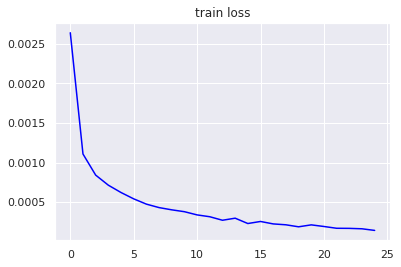

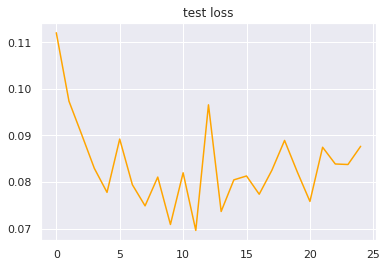

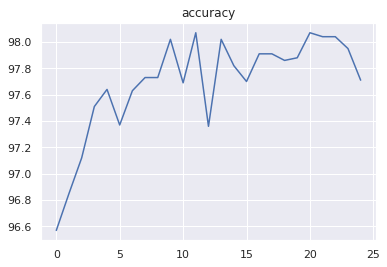

In [ ]:
import torch.optim as optim
import torchvision
import time


DOWNLOAD_PATH = './data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

#print(len(train_loader))
#print(len(train_set))
    
N_EPOCHS = 25

start_time = time.time()
optimizer = optim.Adam(ViT_encoder_mnist.parameters(), lr=0.003)

train_loss_history_vit_mnist, test_loss_history_vit_mnist = [], []
epoch_acc_vit_mnist = []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(ViT_encoder_mnist, optimizer, train_loader, train_loss_history_vit_mnist)
    acc = evaluate(ViT_encoder_mnist, test_loader, test_loss_history_vit_mnist)
    epoch_acc_vit_mnist.append(acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import matplotlib.pyplot as plt
#print(train_loss_history)
plt.title('train loss')
plt.plot(train_loss_history_vit_mnist,c='blue',label='train')
plt.show()

plt.title('test loss')
plt.plot(test_loss_history_vit_mnist,c='orange',label='test')
plt.show()

plt.title('accuracy')
plt.plot(epoch_acc_vit_mnist)
plt.show()


## Training and Evaluation of DUN based Vision Transformer over MNIST Dataset

In [ ]:
import argparse
import os
import shutil
import time
import glob

import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed


best_err1 = 1
lr = 0.003
momentum = 0.9

dataset = 'MNIST'
workers = 0
epochs = 25
weight_decay = 1e-4
savedir = './results/'
batch_size = 256
data_dir = './data/mnist/'
start_depth = 1
end_depth = 4


milestone_dict = {
    'Imagenet': [30, 60],  # This is pytorch default
    'SmallImagenet': [30, 60],
    'CIFAR10': [150, 225],
    'CIFAR100': [150, 225],
    'SVHN': [50, 70],
    'Fashion': [40, 70],
    'MNIST': [40, 70]
}

milestones = None

cuda = torch.cuda.is_available()
print('cuda', cuda)

input_chanels = 1
num_classes = 10

n_layers = end_depth - start_depth

prior_probs = [1 / (n_layers)] * (n_layers)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)

model = ViT_DUN_encoder_mnist
N_train = 0
net = DUN_VI(model, prob_model, N_train, lr=lr, momentum=momentum, weight_decay=weight_decay, cuda=cuda, schedule=milestones, regression=False, pred_sig=None)
all_results_DUN_mnist, epoch_acc_DUN_mnist = train_loop(net, dname=dataset, data_dir=data_dir, epochs=epochs, workers=workers, savedir=savedir,q_nograd_its=0, batch_size=batch_size)

model_ViT_MNIST = model
prob_model_ViT_MNIST = prob_model
net_ViT_DUNvi_MNIST = net

cuda False

Net:
    Total params: 0.06M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()



 depth approx posterior [0.21377984 0.37212032 0.41409987]
it 0/25, ELBO/evidence -646.3972, pred minus loglike = 1.068442, err = 0.323500   time: 23.783321 seconds

Test Accuracy: 91.3
     pred minus loglike = 0.333075, err = 0.087100
    time: 2.315692 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.087100
[=>                                      ] 4% [1/25]	 ETA: 0 Hrs 11 Minutes 24 Seconds
 depth approx posterior [0.1926939  0.374751   0.43255508]
it 1/25, ELBO/evidence -155.9084, pred minus loglike = 0.255724, err = 0.073067   time: 24.532736 seconds

Test Accuracy: 94.06
     pred minus loglike = 0.195656, err = 0.059300
    time: 2.330727 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.059300
[===>                                    ] 8% [2/25]	 ETA: 0 Hrs 11 Minutes 5 Seconds
 depth approx posterior [0.17848012 0.377      0.4445199 ]
it 2/25, ELBO/evidence -103.0116, pred minus loglike = 0.168412, err = 0.049183   time: 24.411197 seco

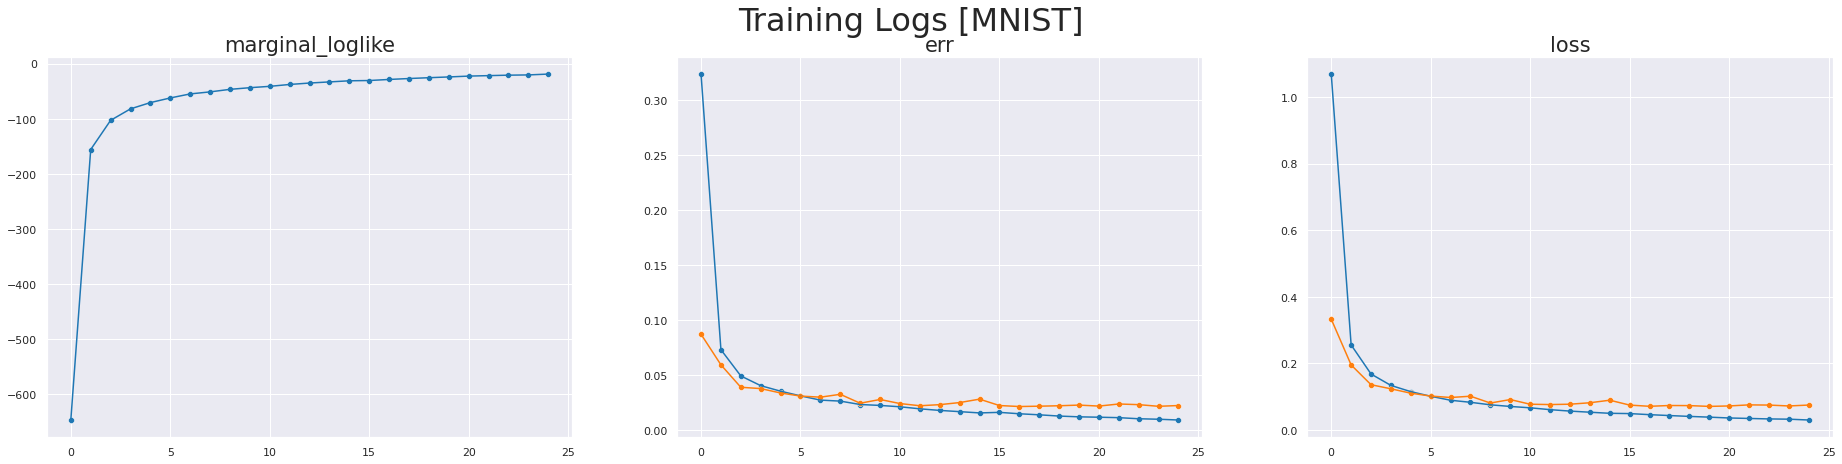

[tensor(96.5700), tensor(96.8500), tensor(97.1200), tensor(97.5100), tensor(97.6400), tensor(97.3700), tensor(97.6300), tensor(97.7300), tensor(97.7300), tensor(98.0200), tensor(97.6900), tensor(98.0700), tensor(97.3600), tensor(98.0200), tensor(97.8200), tensor(97.7000), tensor(97.9100), tensor(97.9100), tensor(97.8600), tensor(97.8800), tensor(98.0700), tensor(98.0400), tensor(98.0400), tensor(97.9500), tensor(97.7100)]
[96.56999969482422, 96.8499984741211, 97.12000274658203, 97.51000213623047, 97.63999938964844, 97.37000274658203, 97.62999725341797, 97.7300033569336, 97.7300033569336, 98.0199966430664, 97.69000244140625, 98.06999969482422, 97.36000061035156, 98.0199966430664, 97.81999969482422, 97.69999694824219, 97.91000366210938, 97.91000366210938, 97.86000061035156, 97.87999725341797, 98.06999969482422, 98.04000091552734, 98.04000091552734, 97.94999694824219, 97.70999908447266]


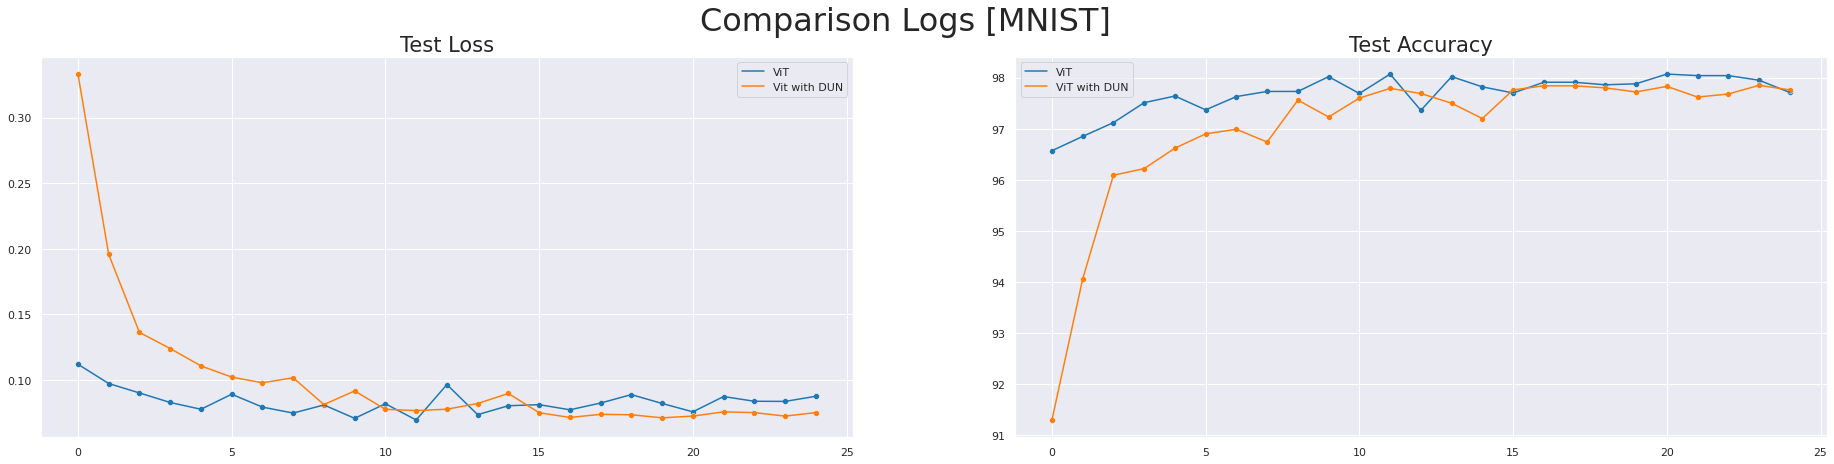

In [ ]:
import seaborn as sns
sns.set()
sns.set_palette("tab10")
fig, axs = plt.subplots(nrows=1, ncols=len(all_results_DUN_mnist)-2, figsize=(32,7))
plt.suptitle('Training Logs [MNIST]', fontsize=32)
# plt.tight_layout()
all_results_label = ["marginal_loglike", "err_train", "train_loss", "err_dev", "dev_loss"]
all_results_label = ["marginal_loglike", "err", "loss", "err_dev", "dev_loss"]

sns.lineplot(x=np.arange(len(all_results_DUN_mnist[0])), y=all_results_DUN_mnist[0], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[0])), y=all_results_DUN_mnist[0], ax=axs[0]);
axs[0].grid(True)
axs[0].set_title(all_results_label[0], fontsize=21)
 
for i, ax in enumerate(axs.flatten()[1:]):
    plt.sca(ax)
    sns.lineplot(x=np.arange(len(all_results_DUN_mnist[i+1])), y=all_results_DUN_mnist[i+1], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[i+1])), y=all_results_DUN_mnist[i+1], ax=ax);
    
    sns.lineplot(x=np.arange(len(all_results_DUN_mnist[i+3])), y=all_results_DUN_mnist[i+3], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[i+3])), y=all_results_DUN_mnist[i+3], ax=ax);
    
    plt.grid(True)
    plt.title(all_results_label[i+1], fontsize=21)

plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,7))
plt.suptitle('Comparison Logs [MNIST]', fontsize=32)


'''
axs[0].grid(True)
axs[0].set_title('Training Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
'''
axs[0].grid(True)
axs[0].set_title('Test Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[4])), y=test_loss_history_vit_mnist, ax=axs[0],label='ViT');
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[4])), y=test_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[4])), y=all_results_DUN_mnist[4], ax=axs[0],label='Vit with DUN');
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[4])), y=all_results_DUN_mnist[4], ax=axs[0]);
print(epoch_acc_vit_mnist)
ep_acc_vit_np = [e.item() for e in epoch_acc_vit_mnist]
print(ep_acc_vit_np)
axs[1].grid(True)
axs[1].set_title('Test Accuracy', fontsize=21)
sns.lineplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1],label='ViT');
sns.scatterplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1]);
sns.lineplot(x=np.arange(len(epoch_acc_DUN_mnist)), y=epoch_acc_DUN_mnist, ax=axs[1],label='ViT with DUN');
sns.scatterplot(x=np.arange(len(epoch_acc_DUN_mnist)), y=epoch_acc_DUN_mnist, ax=axs[1]);

plt.savefig('Compare_Log_MNIST.pdf',use_bbox_inches='tight')



In [ ]:
DOWNLOAD_PATH = './data/mnist'
BATCH_SIZE_TEST = 1

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))])


test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

test_loader_MNIST = test_loader

### Plotting t-SNE over activation vectors

In [ ]:
#X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]
act_vecs = []
label_vit_mnist = []
for i, (data, target) in enumerate(test_loader_MNIST):
    output = ViT_encoder_mnist(data)
    act_vecs.append(output)
    label_vit_mnist.append(target)
#print(act_vecs)

[[3.381645679473877, -3.892639636993408, -3.203364133834839, -9.324106216430664, 4.277934551239014, 0.9195632338523865, 19.6601619720459, -5.090737342834473, 0.5909644365310669, -0.0030850693583488464], [-3.3655178546905518, 16.743179321289062, -4.146847724914551, -1.85344660282135, 4.5803046226501465, -4.044844627380371, -3.6354174613952637, 3.4255502223968506, 0.71234130859375, -3.281318426132202], [-0.7027782201766968, -4.407679557800293, 2.6440327167510986, 3.1995739936828613, -8.402252197265625, -2.2336678504943848, -5.8858561515808105, -3.732015371322632, 16.096357345581055, -2.958165407180786], [0.9542068243026733, 4.172924518585205, 11.892538070678711, -0.4460882842540741, -1.6354014873504639, -6.6325201988220215, -7.98931360244751, 4.523163318634033, -6.8100714683532715, -1.641086220741272], [-0.626503050327301, -5.411498069763184, -7.7480692863464355, -0.673904538154602, -3.149794578552246, 15.11072063446045, 4.564746856689453, -6.710433006286621, 0.17406941950321198, -0.3954

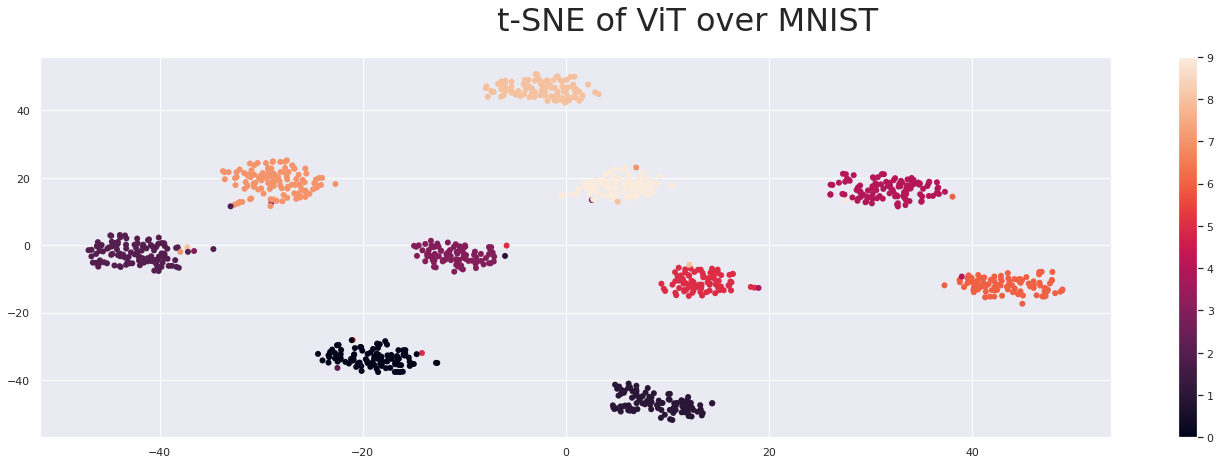

In [ ]:
acvecnp = [ac.detach().numpy() for ac in act_vecs][:1000]
acvecnp2 = [ac.tolist()[0] for ac in acvecnp]
print(acvecnp2)
embed = TSNE(n_components=2).fit_transform(np.asarray(acvecnp2))
print(embed)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
plt.suptitle('t-SNE of ViT over MNIST', fontsize=32)
plt.sca(axs)
plt.scatter(embed[:, 0], embed[:, 1], c=label_vit_mnist[:1000], marker='o', edgecolor='none')
plt.colorbar(ticks=range(10))
plt.grid(True)
plt.savefig('MNIST_TSNE_ViT.pdf',use_bbox_inches='tight')


In [ ]:
sns.set_palette('coolwarm')
accuracy, act_vectors, labels, predictions = evaluate_ViT_DUN(model=model_ViT_MNIST, prob_model=prob_model_ViT_MNIST, net=net_ViT_DUNvi_MNIST, test_loader=test_loader_MNIST)

10000
[========================================>] 100% [10000/10000]	 ETA: 0 Hrs 0 Minutes 0 SecondsAccuracy = 97.76


In [ ]:
actvec_embedded = []
for i in range(3):
  actvec_embedded.append(TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]))
    

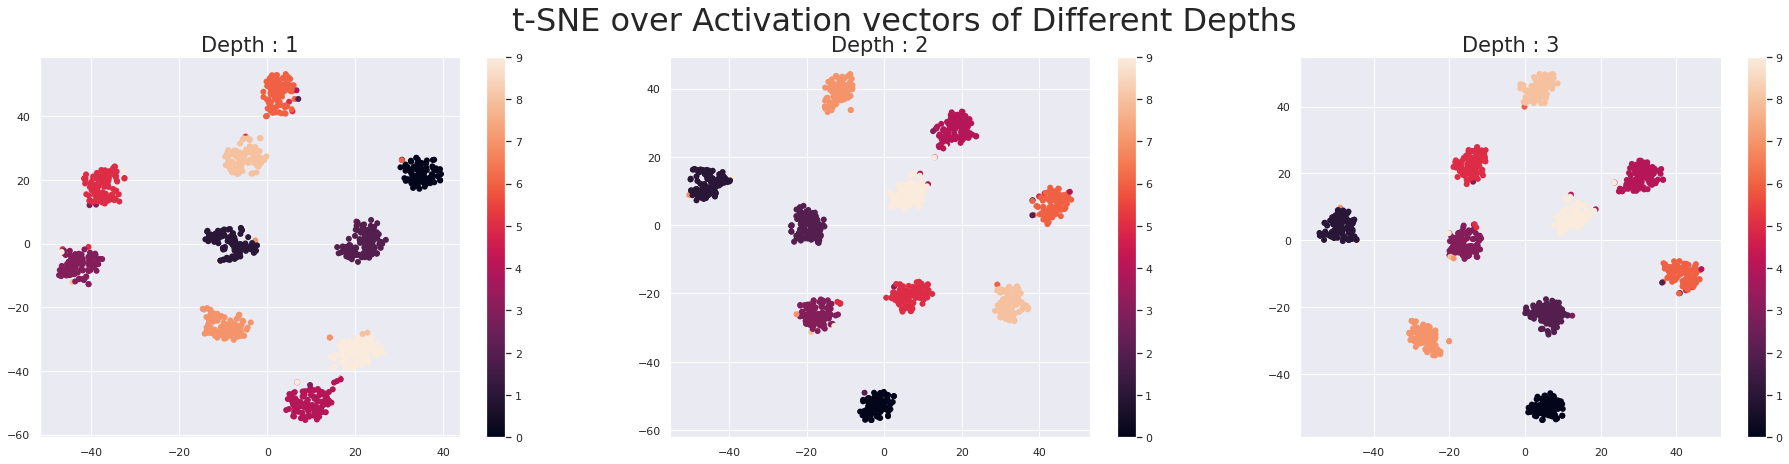

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(32,7))
plt.suptitle('t-SNE over Activation vectors of Different Depths', fontsize=32)
# plt.tight_layout()
for i, ax in enumerate(axs.flatten()):
    # X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :])
    X_embedded = actvec_embedded[i]
    plt.sca(ax)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels[:1000], marker='o', edgecolor='none')
    plt.colorbar(ticks=range(10))
    plt.grid(True)
    plt.title('Depth : {}'.format(i+1), fontsize=21)
plt.savefig('MNIST_TSNE_DUN.pdf',use_bbox_inches='tight')

### Testing model over Rotated MNIST

In [ ]:
rot_accuracy_Vit, rot_angles_Vit, rot_acc_unc_vit = evaluate_ViT_on_rotated(model=ViT_encoder_mnist, test_loader=test_loader_MNIST, use_gpu=False, test_sample_size=1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


[=========================================>] 102% [37/36]	 ETA: -1 Hrs 59 Minutes 54 Seconds

In [ ]:
print(rot_acc_unc_vit)

[2.126412410812034, 3.723622169463738, 3.9253354026778084, 6.953541843583116, 8.9568674535358, 16.639514779940924, 23.872720775727853, 34.80087396735015, 41.89124645820794, 50.55892347409321, 57.68545638057733, 65.75734494949235, 69.5131537990718, 74.71316754717009, 77.37494172303445, 78.98554763316386, 81.95811985992424, 82.96672307370507, 86.44631389205932, 85.65573043471109, 87.95210214494213, 87.87642277463826, 87.04382845735036, 87.65333341005127, 87.62327849301828, 83.9827592047871, 84.27665350119455, 80.80167296290749, 82.05126454365038, 78.40472488093913, 72.44675249741236, 73.4772138214306, 71.70965485061271, 69.07068193583562, 68.48801486114284, 66.2631900336361, 64.04091771047635]


In [ ]:
rot_accuracy_DUN, rot_angles_DUN, pred_avg_stds_DUN, rot_acc_unc_DUN = evaluate_ViT_DUN_on_rotated(model=model_ViT_MNIST, prob_model=prob_model_ViT_MNIST, net=net_ViT_DUNvi_MNIST, test_loader=test_loader_MNIST, test_sample_size=1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


[=========================================>] 102% [37/36]	 ETA: -1 Hrs 59 Minutes 56 Seconds

In [ ]:
print(rot_acc_unc_DUN)

[-973.9059379339218, -966.2392884969711, -950.1277312278747, -911.4452450454235, -839.94765920192, -767.9189853385091, -666.6313501551747, -576.4001548834145, -471.4618520570919, -383.1442205477506, -313.7966239195317, -251.15966755002736, -178.78489457331597, -114.44960946105421, -78.11513794623315, -32.29035864211619, -20.94160806275904, 7.745108350366354, 15.479714280739426, 47.58489548880607, 39.069934328645466, 49.265468187257646, 41.89121136283502, 49.77260699365288, 30.448716110736132, 20.908114982768893, -9.972647052258253, -22.286577796190976, -40.822430870309475, -30.8831708393991, -29.702024007961153, -87.68114333637058, -65.5471246516332, -43.23104462791234, -85.74930866509676, -68.04427036456764, -80.55930626131594]


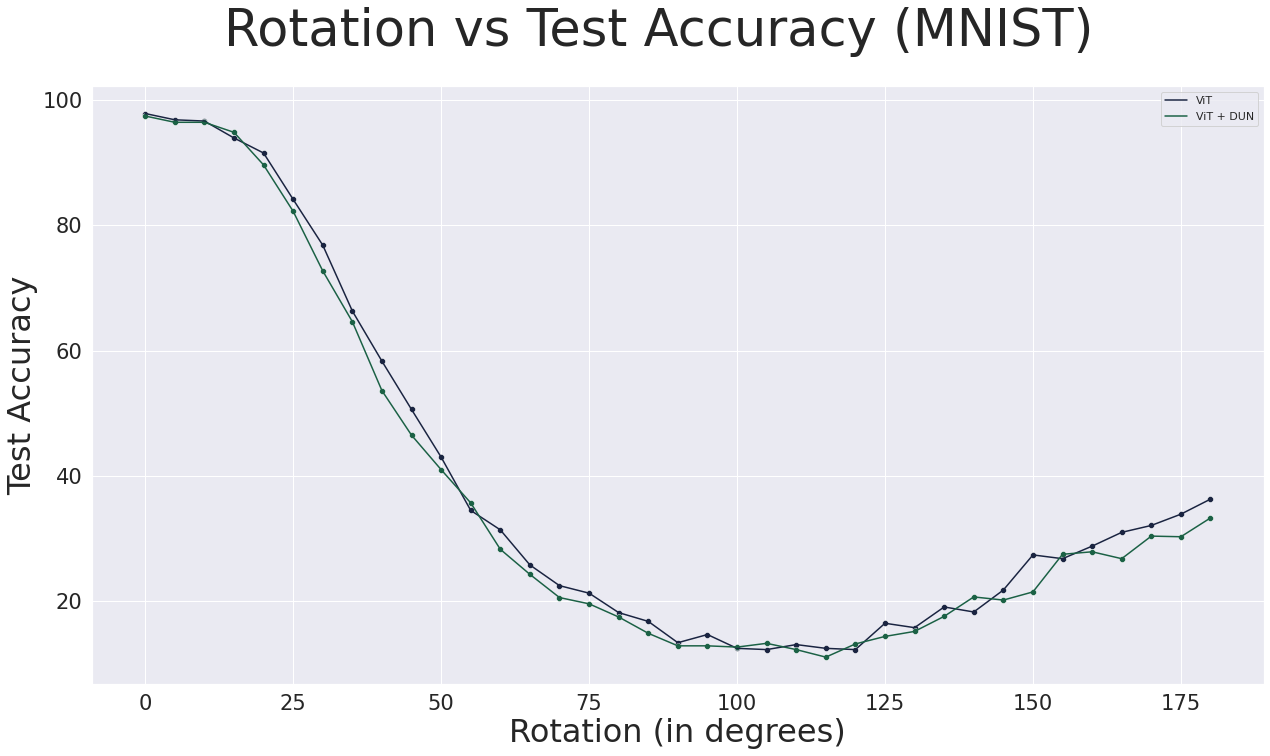

In [ ]:
sns.set_palette("cubehelix")
fig, axs = plt.subplots(1, figsize=(21, 11))

fig.suptitle('Rotation vs Test Accuracy (MNIST)', fontsize=51)
# fig.tight_layout()

sns.lineplot(x=rot_angles_Vit, y=rot_accuracy_Vit, ax=axs,label='ViT');
sns.scatterplot(x=rot_angles_Vit, y=rot_accuracy_Vit, ax=axs);
sns.lineplot(x=rot_angles_DUN, y=rot_accuracy_DUN, ax=axs,label='ViT + DUN');
sns.scatterplot(x=rot_angles_DUN, y=rot_accuracy_DUN, ax=axs);

#axs.fill_between(rot_angles_Vit, np.array(rot_accuracy_Vit)-0.1*np.array(rot_acc_unc_vit), np.array(rot_accuracy_Vit)+0.1*np.array(rot_acc_unc_vit),alpha=0.3,label='ViT uncertainty')
#axs.fill_between(rot_angles_DUN, np.array(rot_accuracy_DUN)-0.1*np.array(rot_acc_unc_DUN), np.array(rot_accuracy_DUN)+0.1*np.array(rot_acc_unc_DUN),alpha=0.3,label='ViT + DUN uncertainty')

axs.set_ylabel("Test Accuracy", fontsize=32)
axs.set_xlabel("Rotation (in degrees)", fontsize=32)
axs.legend()

axs.tick_params(axis='both', which='major', labelsize=21)
plt.savefig('RotAcc_MNIST.pdf',use_bbox_inches='tight')

## Training Vision Transformer over CIFAR-10 dataset


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified
Epoch: 1
[    0/50000 (  0%)]  Loss: 2.3804
[10000/50000 ( 20%)]  Loss: 1.7340
[20000/50000 ( 40%)]  Loss: 1.7595
[30000/50000 ( 60%)]  Loss: 1.5338
[40000/50000 ( 80%)]  Loss: 1.5885

Average test loss: 1.4197  Accuracy: 4863/10000 (48.63%)

Epoch: 2
[    0/50000 (  0%)]  Loss: 1.3099
[10000/50000 ( 20%)]  Loss: 1.1813
[20000/50000 ( 40%)]  Loss: 1.3934
[30000/50000 ( 60%)]  Loss: 1.3740
[40000/50000 ( 80%)]  Loss: 1.4106

Average test loss: 1.3087  Accuracy: 5327/10000 (53.27%)

Epoch: 3
[    0/50000 (  0%)]  Loss: 1.0884
[10000/50000 ( 20%)]  Loss: 1.2509
[20000/50000 ( 40%)]  Loss: 1.2426
[30000/50000 ( 60%)]  Loss: 1.2292
[40000/50000 ( 80%)]  Loss: 1.1856

Average test loss: 1.2620  Accuracy: 5441/10000 (54.41%)

Epoch: 4
[    0/50000 (  0%)]  Loss: 1.1641
[10000/50000 ( 20%)]  Loss: 1.2275
[20000/50000 ( 40%)]  Loss: 1.0798
[30000/50000 ( 60%)]  Loss: 1.2533
[40000/50000 ( 8

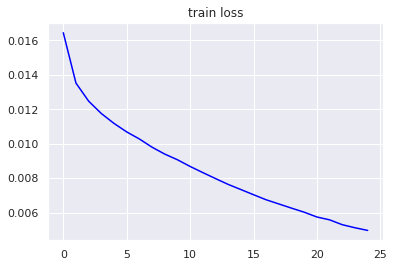

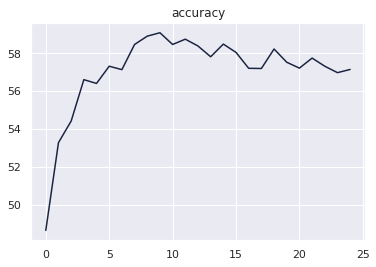

In [ ]:
import torch.optim as optim
import torchvision
import time


DOWNLOAD_PATH = './data/cifar10'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_cifar10 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

train_set = torchvision.datasets.CIFAR10(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_cifar10)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.CIFAR10(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_cifar10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

N_EPOCHS = 25

start_time = time.time()
optimizer = optim.Adam(ViT_encoder_cifar10.parameters(), lr=0.003)

train_loss_history_vit_cifar10, test_loss_history_vit_cifar10 = [], []
epoch_acc_vit_cifar10 = []

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(ViT_encoder_cifar10, optimizer, train_loader, train_loss_history_vit_cifar10)
    acc = evaluate(ViT_encoder_cifar10, test_loader, test_loss_history_vit_cifar10)
    epoch_acc_vit_cifar10.append(acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import matplotlib.pyplot as plt
#print(train_loss_history)
plt.title('train loss')
plt.plot(train_loss_history_vit_cifar10,c='blue',label='train')
plt.show()

plt.title('test loss')
plt.plot(test_loss_history_vit_cifar10,c='orange',label='test')
plt.show()

plt.title('accuracy')
plt.plot(epoch_acc_vit_cifar10)
plt.show()


## Training and Evaluation of DUN based Vision Transformer over CIFAR-10 Dataset

In [ ]:
import argparse
import os
import shutil
import time
import glob

import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed

best_err1 = 1
lr = 0.003
momentum = 0.9

dataset = 'CIFAR10'
workers = 0
epochs = 25
weight_decay = 1e-4
savedir = './results/'
batch_size = 256
data_dir = './data/cifar10/'
start_depth = 1
end_depth = 7


milestone_dict = {
    'Imagenet': [30, 60],  # This is pytorch default
    'SmallImagenet': [30, 60],
    'CIFAR10': [150, 225],
    'CIFAR100': [150, 225],
    'SVHN': [50, 70],
    'Fashion': [40, 70],
    'MNIST': [40, 70]
}

milestones = None

cuda = torch.cuda.is_available()
print('cuda', cuda)

input_chanels = 3
num_classes = 10

n_layers = end_depth - start_depth

prior_probs = [1 / (n_layers)] * (n_layers)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)

model = ViT_DUN_encoder_cifar10
N_train = 0
net = DUN_VI(model, prob_model, N_train, lr=lr, momentum=momentum, weight_decay=weight_decay, cuda=cuda, schedule=milestones, regression=False, pred_sig=None)
all_results_DUN_cifar10, epoch_acc_DUN_cifar10 = train_loop(net, dname=dataset, data_dir=data_dir, epochs=epochs, workers=workers, savedir=savedir,q_nograd_its=0, batch_size=batch_size)

model_ViT_CIFAR10 = model
prob_model_ViT_CIFAR10 = prob_model
net_ViT_DUNvi_CIFAR10 = net

cuda False

Net:
    Total params: 0.12M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Files already downloaded and verified
Files already downloaded and verified

 depth approx posterior [0.15276419 0.16294633 0.16897987 0.17111886 0.17231613 0.17187463]
it 0/25, ELBO/evidence -1063.8424, pred minus loglike = 2.120066, err = 0.794840   time: 75.450337 seconds

Test Accuracy: 25.44
     pred minus loglike = 2.002792, err = 0.745000
    time: 7.559939 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.745000
[=>                                      ] 4% [1/25]	 ETA: 0 Hrs 36 Minutes 40 Seconds
 depth approx posterior [0.13773644 0.15994206 0.1702083  0.17497233 0.17897062 0.17817019]
it 1/25, ELBO/evidence -977.9393, pred minus loglike = 1.946318, err = 0.720740   time: 74.511185 seconds

Test Accuracy: 31.66
     pred minus loglike = 1.863217, err = 0.682800
    time: 7.531390 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.682800
[===>                                    ] 8% [2/25]	 ETA: 0 Hrs 34 Minutes 46 Seconds
 depth approx po

In [ ]:
plt.title('accuracy')
plt.plot(epoch_acc_DUN_cifar10)
plt.show()

[tensor(48.6300), tensor(53.2700), tensor(54.4100), tensor(56.6000), tensor(56.4000), tensor(57.3100), tensor(57.1300), tensor(58.4600), tensor(58.9000), tensor(59.0800), tensor(58.4600), tensor(58.7400), tensor(58.3800), tensor(57.8100), tensor(58.4800), tensor(58.0400), tensor(57.2000), tensor(57.1900), tensor(58.2200), tensor(57.5200), tensor(57.2100), tensor(57.7400), tensor(57.3100), tensor(56.9700), tensor(57.1400)]
[48.630001068115234, 53.27000045776367, 54.40999984741211, 56.599998474121094, 56.400001525878906, 57.310001373291016, 57.130001068115234, 58.459999084472656, 58.900001525878906, 59.08000183105469, 58.459999084472656, 58.7400016784668, 58.380001068115234, 57.810001373291016, 58.47999954223633, 58.040000915527344, 57.20000076293945, 57.189998626708984, 58.220001220703125, 57.52000045776367, 57.209999084472656, 57.7400016784668, 57.310001373291016, 56.970001220703125, 57.13999938964844]


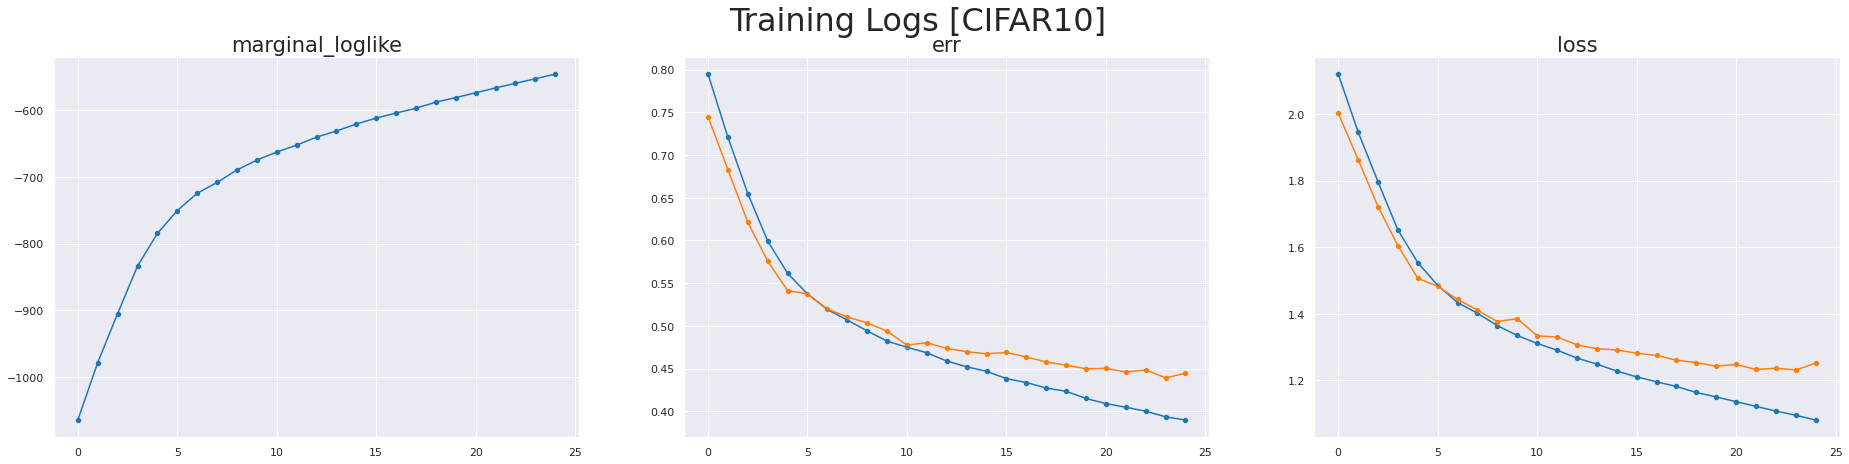

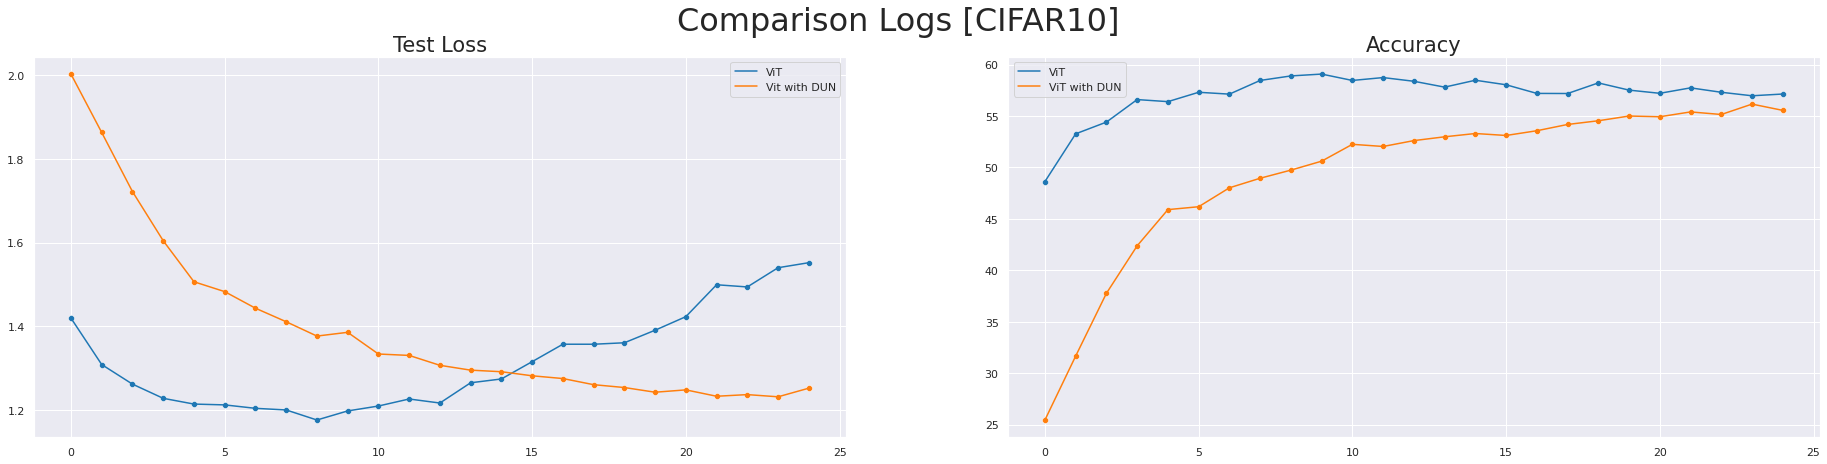

In [ ]:
sns.set_palette("tab10")
fig, axs = plt.subplots(nrows=1, ncols=len(all_results_DUN_cifar10)-2, figsize=(32,7))
plt.suptitle('Training Logs [CIFAR10]', fontsize=32)
# plt.tight_layout()
all_results_label = ["marginal_loglike", "err_train", "train_loss", "err_dev", "dev_loss"]
all_results_label = ["marginal_loglike", "err", "loss", "err_dev", "dev_loss"]

sns.lineplot(x=np.arange(len(all_results_DUN_cifar10[0])), y=all_results_DUN_cifar10[0], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_cifar10[0])), y=all_results_DUN_cifar10[0], ax=axs[0]);
axs[0].grid(True)
axs[0].set_title(all_results_label[0], fontsize=21)
 
for i, ax in enumerate(axs.flatten()[1:]):
    plt.sca(ax)
    sns.lineplot(x=np.arange(len(all_results_DUN_cifar10[i+1])), y=all_results_DUN_cifar10[i+1], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_DUN_cifar10[i+1])), y=all_results_DUN_cifar10[i+1], ax=ax);
    
    sns.lineplot(x=np.arange(len(all_results_DUN_cifar10[i+3])), y=all_results_DUN_cifar10[i+3], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_DUN_cifar10[i+3])), y=all_results_DUN_cifar10[i+3], ax=ax);
    
    plt.grid(True)
    plt.title(all_results_label[i+1], fontsize=21)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,7))
plt.suptitle('Comparison Logs [CIFAR10]', fontsize=32)

'''
axs[0].grid(True)
axs[0].set_title('Training Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
'''
axs[0].grid(True)
axs[0].set_title('Test Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_cifar10[4])), y=test_loss_history_vit_cifar10, ax=axs[0],label='ViT');
sns.scatterplot(x=np.arange(len(all_results_DUN_cifar10[4])), y=test_loss_history_vit_cifar10, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_cifar10[4])), y=all_results_DUN_cifar10[4], ax=axs[0],label='Vit with DUN');
sns.scatterplot(x=np.arange(len(all_results_DUN_cifar10[4])), y=all_results_DUN_cifar10[4], ax=axs[0]);
print(epoch_acc_vit_cifar10)
ep_acc_vit_np = [e.item() for e in epoch_acc_vit_cifar10]
print(ep_acc_vit_np)
axs[1].grid(True)
axs[1].set_title('Accuracy', fontsize=21)
sns.lineplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1],label='ViT');
sns.scatterplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1]);
sns.lineplot(x=np.arange(len(epoch_acc_DUN_cifar10)), y=epoch_acc_DUN_cifar10, ax=axs[1],label='ViT with DUN');
sns.scatterplot(x=np.arange(len(epoch_acc_DUN_cifar10)), y=epoch_acc_DUN_cifar10, ax=axs[1]);

plt.show()


In [ ]:
DOWNLOAD_PATH = './data/cifar10'
BATCH_SIZE_TEST = 1

transform_cifar10 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


test_set = torchvision.datasets.CIFAR10(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_cifar10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

test_loader_CIFAR10 = test_loader

Files already downloaded and verified


### Plotting t-SNE over activation vectors

In [ ]:
#X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]
act_vecs = []
label_vit_cifar10 = []
for i, (data, target) in enumerate(test_loader_CIFAR10):
    output = ViT_encoder_cifar10(data)
    act_vecs.append(output)
    label_vit_cifar10.append(target)
#print(act_vecs)

[[-1.6794705390930176, 1.6390265226364136, -1.5212736129760742, -3.2670419216156006, -1.012809157371521, 0.35418251156806946, -4.750058650970459, 10.535298347473145, -3.4245829582214355, 4.683088302612305], [6.917356491088867, -3.1897623538970947, 3.3907341957092285, -2.191132068634033, 0.5396310091018677, -3.332528591156006, -0.7105653882026672, -1.6002476215362549, 2.3221237659454346, -7.61326789855957], [-2.041393995285034, 5.913576602935791, -1.0598394870758057, -3.444091796875, -2.2175540924072266, -4.797084808349609, 0.03640030324459076, -2.3297362327575684, 0.8996562957763672, 6.246607780456543], [0.13451647758483887, -0.25149592757225037, 1.5798752307891846, 2.8948209285736084, -5.362247467041016, -0.3760428726673126, -1.302878737449646, -0.9474084973335266, -0.9844990968704224, 2.1995787620544434], [1.5957505702972412, 5.123178958892822, -2.3942394256591797, -4.786121845245361, -2.23423433303833, -4.4373459815979, -3.7186391353607178, -1.2488101720809937, 4.539448261260986, 10

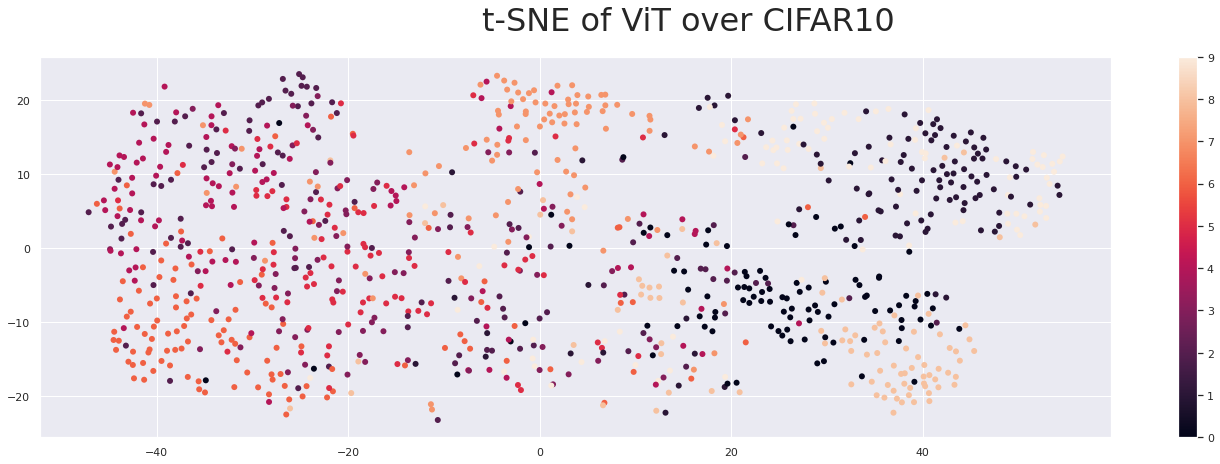

In [ ]:
acvecnp = [ac.detach().numpy() for ac in act_vecs][:1000]
acvecnp2 = [ac.tolist()[0] for ac in acvecnp]
print(acvecnp2)
embed = TSNE(n_components=2).fit_transform(np.asarray(acvecnp2))
print(embed)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
plt.suptitle('t-SNE of ViT over CIFAR10', fontsize=32)
plt.sca(axs)
plt.scatter(embed[:, 0], embed[:, 1], c=label_vit_cifar10[:1000], marker='o', edgecolor='none')
plt.colorbar(ticks=range(10))
plt.grid(True)


In [ ]:
accuracy, act_vectors, labels, predictions = evaluate_ViT_DUN(model=model_ViT_CIFAR10, prob_model=prob_model_ViT_CIFAR10, net=net_ViT_DUNvi_CIFAR10, test_loader=test_loader_CIFAR10)

10000
[========================================>] 100% [10000/10000]	 ETA: 0 Hrs 0 Minutes 0 SecondsAccuracy = 55.55


In [ ]:
actvec_embedded = []
for i in range(6):
  actvec_embedded.append(TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]))

In [ ]:
# sns.set_palette("default")
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(32,7))
plt.suptitle('t-SNE over Activation vectors of Different Depths', fontsize=32)
# plt.tight_layout()
for i, ax in enumerate(axs.flatten()):
    # X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :])
    X_embedded = actvec_embedded[i]
    plt.sca(ax)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels[:1000], marker='o', edgecolor='none')
    plt.colorbar(ticks=range(10))
    plt.grid(True)
    plt.title('Depth : {}'.format(i+1), fontsize=21)

## Training Vision Transformer over CIFAR-100 dataset


Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified
Epoch: 1
[    0/50000 (  0%)]  Loss: 4.7110
[10000/50000 ( 20%)]  Loss: 4.1339
[20000/50000 ( 40%)]  Loss: 4.0739
[30000/50000 ( 60%)]  Loss: 3.8522
[40000/50000 ( 80%)]  Loss: 3.7102

Average test loss: 3.5805  Accuracy: 1539/10000 (15.39%)

Epoch: 2
[    0/50000 (  0%)]  Loss: 3.6377
[10000/50000 ( 20%)]  Loss: 3.4365
[20000/50000 ( 40%)]  Loss: 3.4028
[30000/50000 ( 60%)]  Loss: 3.3737
[40000/50000 ( 80%)]  Loss: 3.2835

Average test loss: 3.2826  Accuracy: 2064/10000 (20.64%)

Epoch: 3
[    0/50000 (  0%)]  Loss: 3.2660
[10000/50000 ( 20%)]  Loss: 3.0724
[20000/50000 ( 40%)]  Loss: 3.0229
[30000/50000 ( 60%)]  Loss: 3.0973
[40000/50000 ( 80%)]  Loss: 3.2888

Average test loss: 3.1288  Accuracy: 2363/10000 (23.63%)

Epoch: 4
[    0/50000 (  0%)]  Loss: 3.1996
[10000/50000 ( 20%)]  Loss: 3.4181
[20000/50000 ( 40%)]  Loss: 3.4032
[30000/50000 ( 60%)]  Loss: 2.8589
[40000/50000 

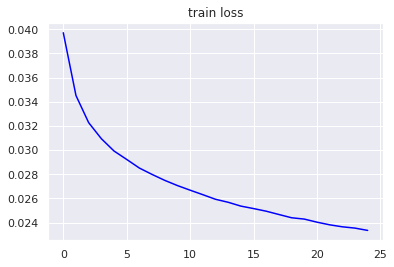

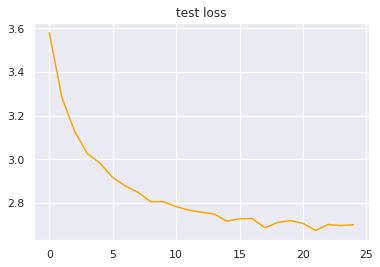

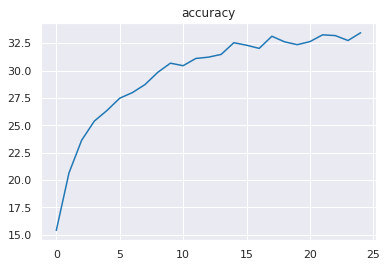

In [ ]:
import torch
import torch.optim as optim
import torchvision
import time


DOWNLOAD_PATH = './data/cifar100'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_cifar100 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762))])

train_set = torchvision.datasets.CIFAR100(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_cifar100)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.CIFAR100(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_cifar100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

N_EPOCHS = 25

start_time = time.time()
optimizer = optim.Adam(ViT_encoder_cifar100.parameters(), lr=0.003)

train_loss_history_vit_cifar100, test_loss_history_vit_cifar100 = [], []
epoch_acc_vit_cifar100 = []

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(ViT_encoder_cifar100, optimizer, train_loader, train_loss_history_vit_cifar100)
    acc = evaluate(ViT_encoder_cifar100, test_loader, test_loss_history_vit_cifar100)
    epoch_acc_vit_cifar100.append(acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import matplotlib.pyplot as plt
#print(train_loss_history)
plt.title('train loss')
plt.plot(train_loss_history_vit_cifar100,c='blue',label='train')
plt.show()

plt.title('test loss')
plt.plot(test_loss_history_vit_cifar100,c='orange',label='test')
plt.show()

plt.title('accuracy')
plt.plot(epoch_acc_vit_cifar100)
plt.show()


## Training and Evaluation of DUN based Vision Transformer over CIFAR-100 Dataset

In [ ]:
import argparse
import os
import shutil
import time
import glob

import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed

best_err1 = 1
lr = 0.03
momentum = 0.9

dataset = 'CIFAR100'
workers = 0
epochs = 25
weight_decay = 1e-4
savedir = './results/'
batch_size = 256
data_dir = './data/cifar100/'
start_depth = 1
end_depth = 9


milestone_dict = {
    'Imagenet': [30, 60],  # This is pytorch default
    'SmallImagenet': [30, 60],
    'CIFAR10': [150, 225],
    'CIFAR100': [150, 225],
    'SVHN': [50, 70],
    'Fashion': [40, 70],
    'MNIST': [40, 70]
}

milestones = None

cuda = torch.cuda.is_available()
print('cuda', cuda)

input_chanels = 3
num_classes = 100

n_layers = end_depth - start_depth

prior_probs = [1 / (n_layers)] * (n_layers)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)

model = ViT_DUN_encoder_cifar100
N_train = 0
net = DUN_VI(model, prob_model, N_train, lr=lr, momentum=momentum, weight_decay=weight_decay, cuda=cuda, schedule=milestones, regression=False, pred_sig=None)
all_results_cifar100, epoch_acc_cifar100 = train_loop(net, dname=dataset, data_dir=data_dir, epochs=epochs, workers=workers, savedir=savedir,q_nograd_its=0, batch_size=batch_size)

model_ViT_CIFAR100 = model
prob_model_ViT_CIFAR100 = prob_model
net_ViT_DUNvi_CIFAR100 = net

cuda False

Net:
    Total params: 0.16M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Files already downloaded and verified
Files already downloaded and verified

 depth approx posterior [0.06349553 0.10430315 0.12963907 0.13932264 0.14342417 0.14167364
 0.14088215 0.13725966]
it 0/25, ELBO/evidence -2142.5825, pred minus loglike = 4.277445, err = 0.952980   time: 99.674234 seconds

Test Accuracy: 8.26
     pred minus loglike = 3.945013, err = 0.912300
    time: 9.701168 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.912300
[=>                                      ] 4% [1/25]	 ETA: 0 Hrs 48 Minutes 33 Seconds
 depth approx posterior [0.03474759 0.08677686 0.1331934  0.15269665 0.15683255 0.15233703
 0.14629255 0.13712335]
it 1/25, ELBO/evidence -1896.8957, pred minus loglike = 3.785517, err = 0.888300   time: 102.301278 seconds

Test Accuracy: 14.1
     pred minus loglike = 3.586619, err = 0.849100
    time: 9.601880 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.849100
[===>                                    ] 8% [2/25]	 ETA

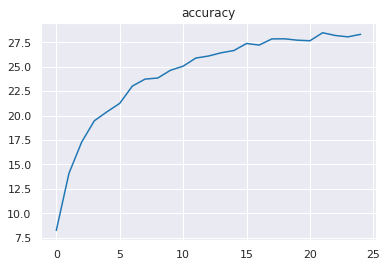

In [ ]:
plt.title('accuracy')
plt.plot(epoch_acc_cifar100)
plt.show()

[tensor(15.3900), tensor(20.6400), tensor(23.6300), tensor(25.3800), tensor(26.3500), tensor(27.4700), tensor(27.9800), tensor(28.7200), tensor(29.8300), tensor(30.6700), tensor(30.4400), tensor(31.1000), tensor(31.2200), tensor(31.4700), tensor(32.5400), tensor(32.3100), tensor(32.0200), tensor(33.1300), tensor(32.6200), tensor(32.3600), tensor(32.6400), tensor(33.2600), tensor(33.1900), tensor(32.7400), tensor(33.4500)]
[15.390000343322754, 20.639999389648438, 23.6299991607666, 25.3799991607666, 26.350000381469727, 27.469999313354492, 27.979999542236328, 28.719999313354492, 29.829999923706055, 30.670000076293945, 30.440000534057617, 31.100000381469727, 31.219999313354492, 31.469999313354492, 32.540000915527344, 32.310001373291016, 32.02000045776367, 33.130001068115234, 32.619998931884766, 32.36000061035156, 32.63999938964844, 33.2599983215332, 33.189998626708984, 32.7400016784668, 33.45000076293945]


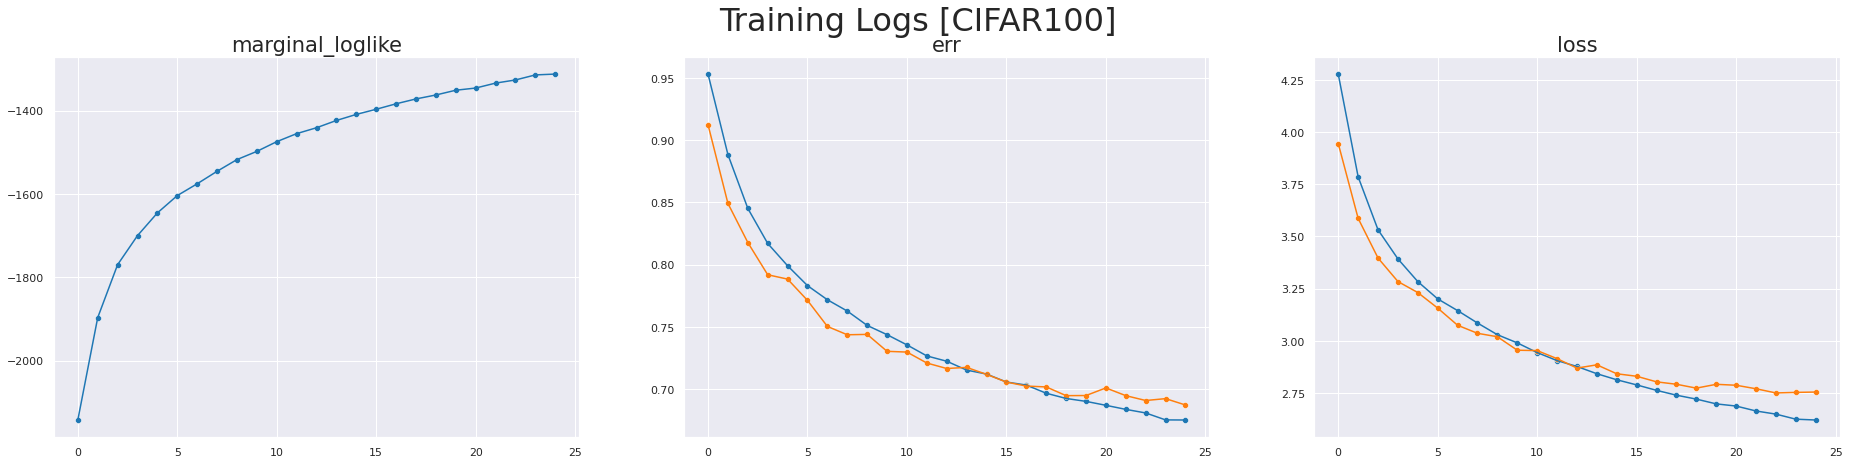

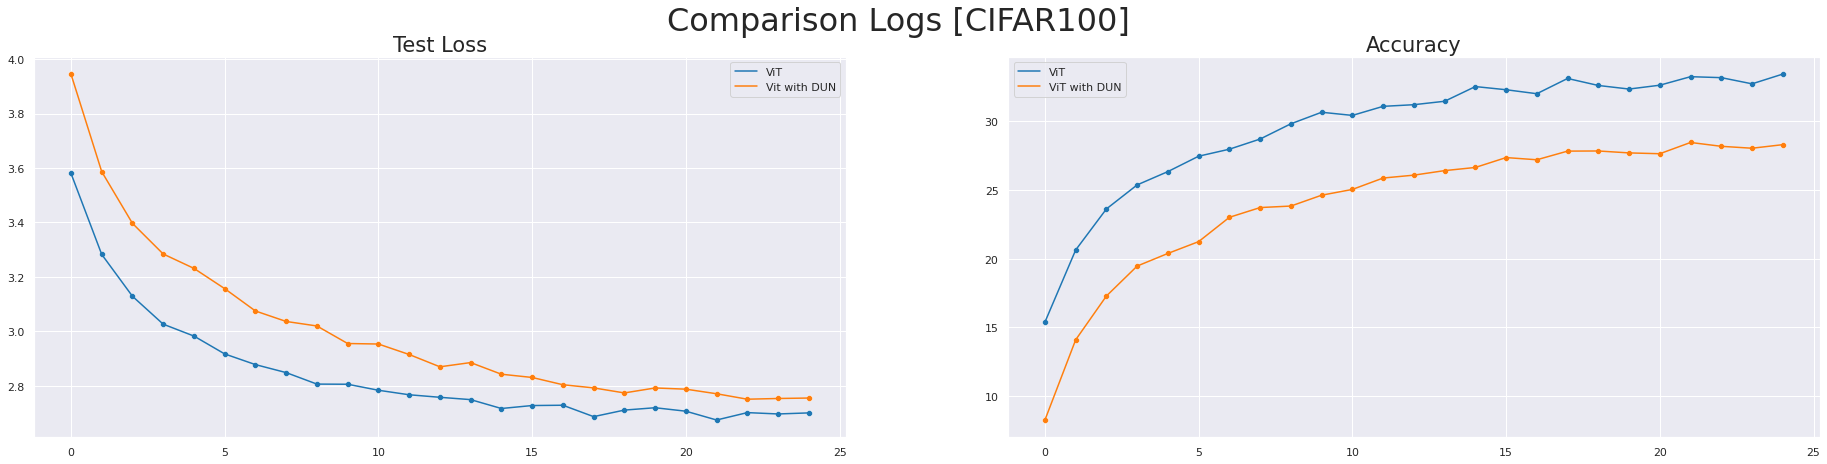

In [ ]:
sns.set_palette("tab10")
fig, axs = plt.subplots(nrows=1, ncols=len(all_results_cifar100)-2, figsize=(32,7))
plt.suptitle('Training Logs [CIFAR100]', fontsize=32)
# plt.tight_layout()
all_results_label = ["marginal_loglike", "err_train", "train_loss", "err_dev", "dev_loss"]
all_results_label = ["marginal_loglike", "err", "loss", "err_dev", "dev_loss"]

sns.lineplot(x=np.arange(len(all_results_cifar100[0])), y=all_results_cifar100[0], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_cifar100[0])), y=all_results_cifar100[0], ax=axs[0]);
axs[0].grid(True)
axs[0].set_title(all_results_label[0], fontsize=21)
 
for i, ax in enumerate(axs.flatten()[1:]):
    plt.sca(ax)
    sns.lineplot(x=np.arange(len(all_results_cifar100[i+1])), y=all_results_cifar100[i+1], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_cifar100[i+1])), y=all_results_cifar100[i+1], ax=ax);
    
    sns.lineplot(x=np.arange(len(all_results_cifar100[i+3])), y=all_results_cifar100[i+3], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_cifar100[i+3])), y=all_results_cifar100[i+3], ax=ax);
    
    plt.grid(True)
    plt.title(all_results_label[i+1], fontsize=21)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,7))
plt.suptitle('Comparison Logs [CIFAR100]', fontsize=32)

'''
axs[0].grid(True)
axs[0].set_title('Training Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
'''
axs[0].grid(True)
axs[0].set_title('Test Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_cifar100[4])), y=test_loss_history_vit_cifar100, ax=axs[0],label='ViT');
sns.scatterplot(x=np.arange(len(all_results_cifar100[4])), y=test_loss_history_vit_cifar100, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_cifar100[4])), y=all_results_cifar100[4], ax=axs[0],label='Vit with DUN');
sns.scatterplot(x=np.arange(len(all_results_cifar100[4])), y=all_results_cifar100[4], ax=axs[0]);
print(epoch_acc_vit_cifar100)
ep_acc_vit_np = [e.item() for e in epoch_acc_vit_cifar100]
print(ep_acc_vit_np)
axs[1].grid(True)
axs[1].set_title('Accuracy', fontsize=21)
sns.lineplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1],label='ViT');
sns.scatterplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1]);
sns.lineplot(x=np.arange(len(epoch_acc_cifar100)), y=epoch_acc_cifar100, ax=axs[1],label='ViT with DUN');
sns.scatterplot(x=np.arange(len(epoch_acc_cifar100)), y=epoch_acc_cifar100, ax=axs[1]);

plt.show()

In [ ]:
DOWNLOAD_PATH = './data/cifar100'
BATCH_SIZE_TEST = 1

transform_cifar100 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762))])


test_set = torchvision.datasets.CIFAR100(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_cifar100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

test_loader_CIFAR100 = test_loader


Files already downloaded and verified


### Plotting t-SNE over activation vectors

In [ ]:
#X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]
act_vecs = []
label_vit_cifar100 = []
for i, (data, target) in enumerate(test_loader_CIFAR100):
    output = ViT_encoder_cifar100(data)
    act_vecs.append(output)
    label_vit_cifar100.append(target)
#print(act_vecs)

[[0.06497019529342651, -1.2458343505859375, -3.0849449634552, 2.1320700645446777, -0.2791861891746521, -2.140873670578003, -3.7837460041046143, -2.3042712211608887, 0.28525644540786743, -2.959571123123169, -0.10992395877838135, -3.682830810546875, 2.454130172729492, -0.5080195665359497, -4.240405559539795, -1.6468302011489868, -1.6919803619384766, 2.5016024112701416, -0.6520538926124573, -0.08616696298122406, -2.6848556995391846, -1.491823434829712, 0.23186790943145752, 0.0028433799743652344, -4.167299270629883, 1.2152154445648193, -2.5395047664642334, 0.6239523887634277, -1.374861478805542, 2.9325599670410156, -2.2793173789978027, 3.5731160640716553, 2.0822792053222656, 5.4536943435668945, -2.9835846424102783, -4.49423360824585, -3.4547054767608643, 2.4293055534362793, -1.5281401872634888, 2.5798420906066895, -0.8180180788040161, -0.021203279495239258, 0.7535260915756226, -1.2352440357208252, -2.0583646297454834, -0.20580467581748962, -2.2847506999969482, 11.506002426147461, -2.595248

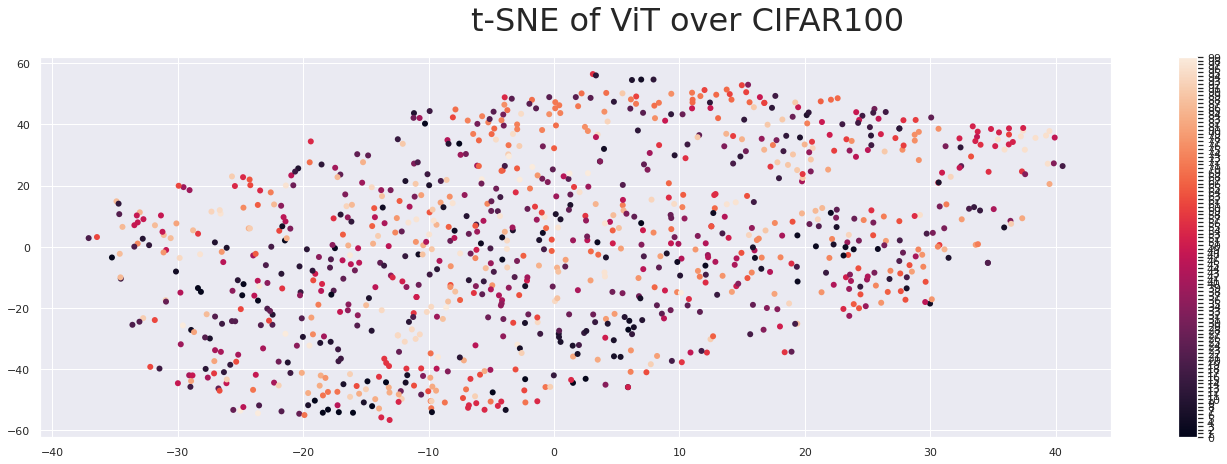

In [ ]:
acvecnp = [ac.detach().numpy() for ac in act_vecs][:1000]
acvecnp2 = [ac.tolist()[0] for ac in acvecnp]
print(acvecnp2)
embed = TSNE(n_components=2).fit_transform(np.asarray(acvecnp2))
print(embed)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
plt.suptitle('t-SNE of ViT over CIFAR100', fontsize=32)
plt.sca(axs)
plt.scatter(embed[:, 0], embed[:, 1], c=label_vit_cifar100[:1000], marker='o', edgecolor='none')
plt.colorbar(ticks=range(100))
plt.grid(True)

In [ ]:
accuracy, act_vectors, labels, predictions = evaluate_ViT_DUN(model=model_ViT_CIFAR100, prob_model=prob_model_ViT_CIFAR100, net=net_ViT_DUNvi_CIFAR100, test_loader=test_loader_CIFAR100)

10000
[========================================>] 100% [10000/10000]	 ETA: 0 Hrs 0 Minutes 0 SecondsAccuracy = 31.29


In [ ]:
actvec_embedded = []
for i in range(8):
  actvec_embedded.append(TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]))

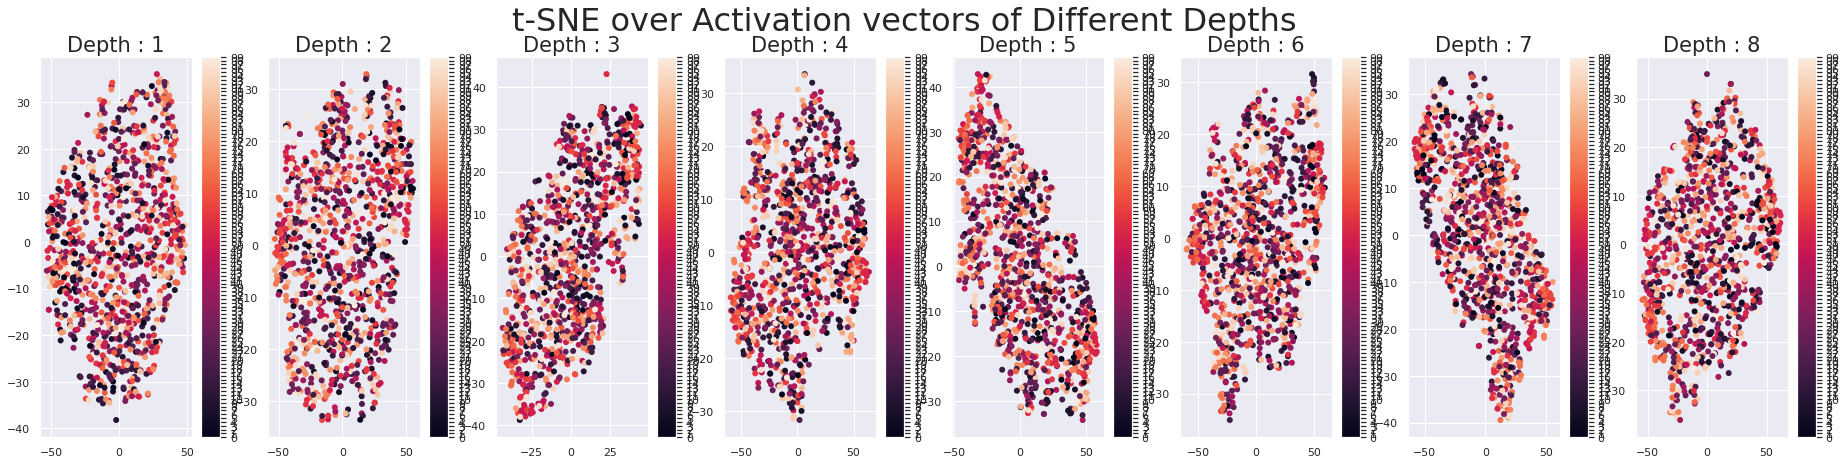

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(32,7))
plt.suptitle('t-SNE over Activation vectors of Different Depths', fontsize=32)
# plt.tight_layout()
for i, ax in enumerate(axs.flatten()):
    # X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :])
    X_embedded = actvec_embedded[i]
    plt.sca(ax)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels[:1000], marker='o', edgecolor='none')
    plt.colorbar(ticks=range(100))
    plt.grid(True)
    plt.title('Depth : {}'.format(i+1), fontsize=21)

## Training Vision Transformer over SVHN dataset


Epoch: 1
[    0/73257 (  0%)]  Loss: 2.3491
[10000/73257 ( 14%)]  Loss: 2.1602
[20000/73257 ( 27%)]  Loss: 2.0674
[30000/73257 ( 41%)]  Loss: 1.4643
[40000/73257 ( 55%)]  Loss: 1.3602
[50000/73257 ( 68%)]  Loss: 1.0846
[60000/73257 ( 82%)]  Loss: 1.1104
[70000/73257 ( 95%)]  Loss: 0.9425

Average test loss: 1.1568  Accuracy:16170/26032 (62.12%)

Epoch: 2
[    0/73257 (  0%)]  Loss: 1.0020
[10000/73257 ( 14%)]  Loss: 0.9599
[20000/73257 ( 27%)]  Loss: 0.9896
[30000/73257 ( 41%)]  Loss: 0.7493
[40000/73257 ( 55%)]  Loss: 0.6038
[50000/73257 ( 68%)]  Loss: 0.7613
[60000/73257 ( 82%)]  Loss: 0.7223
[70000/73257 ( 95%)]  Loss: 0.7185

Average test loss: 0.8439  Accuracy:19121/26032 (73.45%)

Epoch: 3
[    0/73257 (  0%)]  Loss: 0.7694
[10000/73257 ( 14%)]  Loss: 0.8016
[20000/73257 ( 27%)]  Loss: 0.5410
[30000/73257 ( 41%)]  Loss: 0.5371
[40000/73257 ( 55%)]  Loss: 0.8974
[50000/73257 ( 68%)]  Loss: 0.7573
[60000/73257 ( 82%)]  Loss: 0.7227
[70000/73257 ( 95%)]  Loss: 0.8427

Average test 

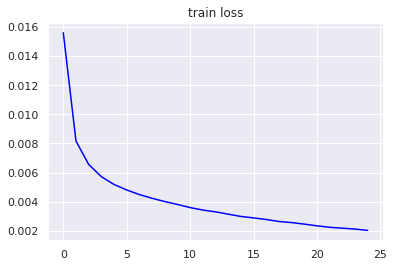

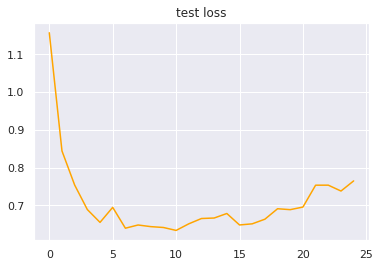

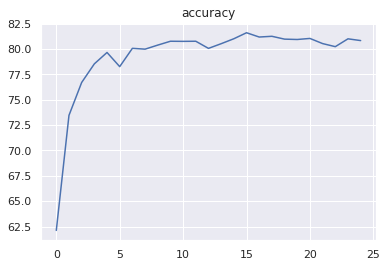

In [ ]:
import torch.optim as optim
import torchvision
import time


DOWNLOAD_PATH = './data/svhn'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_svhn = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))])

train_set = torchvision.datasets.SVHN(DOWNLOAD_PATH, split='train', download=True,
                                       transform=transform_svhn)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.SVHN(DOWNLOAD_PATH, split='test', download=True,
                                      transform=transform_svhn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

N_EPOCHS = 25

start_time = time.time()
optimizer = optim.Adam(ViT_encoder_svhn.parameters(), lr=0.003)

train_loss_history_vit_svhn, test_loss_history_vit_svhn = [], []
epoch_acc_vit_svhn = []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(ViT_encoder_svhn, optimizer, train_loader, train_loss_history_vit_svhn)
    acc = evaluate(ViT_encoder_svhn, test_loader, test_loss_history_vit_svhn)
    epoch_acc_vit_svhn.append(acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import matplotlib.pyplot as plt
#print(train_loss_history)
plt.title('train loss')
plt.plot(train_loss_history_vit_svhn,c='blue',label='train')
plt.show()

plt.title('test loss')
plt.plot(test_loss_history_vit_svhn,c='orange',label='test')
plt.show()

plt.title('accuracy')
plt.plot(epoch_acc_vit_svhn)
plt.show()


## Training and Evaluation of DUN based Vision Transformer over SVHN Dataset

In [ ]:
import argparse
import os
import shutil
import time
import glob

import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed

best_err1 = 1
lr = 0.003
momentum = 0.9

dataset = 'SVHN'
workers = 0
epochs = 25
weight_decay = 1e-4
savedir = './results/'
batch_size = 256
data_dir = './data/svhn/'
start_depth = 1
end_depth = 6


milestone_dict = {
    'Imagenet': [30, 60],  # This is pytorch default
    'SmallImagenet': [30, 60],
    'CIFAR10': [150, 225],
    'CIFAR100': [150, 225],
    'SVHN': [50, 70],
    'Fashion': [40, 70],
    'MNIST': [40, 70]
}

milestones = None

cuda = torch.cuda.is_available()
print('cuda', cuda)

input_chanels = 3
num_classes = 10

n_layers = end_depth - start_depth

prior_probs = [1 / (n_layers)] * (n_layers)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)

model = ViT_DUN_encoder_svhn
N_train = 0
net = DUN_VI(model, prob_model, N_train, lr=lr, momentum=momentum, weight_decay=weight_decay, cuda=cuda, schedule=milestones, regression=False, pred_sig=None)
# all_results = [marginal_loglike, err_train, train_loss, err_dev, dev_loss]
all_results_svhn, epoch_acc_svhn = train_loop(net, dname=dataset, data_dir=data_dir, epochs=epochs, workers=workers, savedir=savedir,q_nograd_its=0, batch_size=batch_size)

model_ViT_SVHN = model
prob_model_ViT_SVHN = prob_model
net_ViT_DUNvi_SVHN = net
all_results_SVHN = all_results_svhn

cuda False

Net:
    Total params: 0.12M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat

 depth approx posterior [0.19902346 0.19827177 0.20075247 0.20102572 0.2009266 ]
it 0/25, ELBO/evidence -1641.9514, pred minus loglike = 2.238523, err = 0.813301   time: 39.290421 seconds

Test Accuracy: 19.111094038106945
     pred minus loglike = 2.214504, err = 0.808735
    time: 8.250051 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.808735
[=>                                      ] 4% [1/25]	 ETA: 0 Hrs 22 Minutes 27 Seconds
 depth approx posterior [0.17969972 0.19585694 0.20549227 0.20950112 0.20944993]
it 1/25, ELBO/evidence -1548.5518, pred minus loglike = 2.107843, err = 0.757948   time: 39.757097 seconds

Test Accuracy: 31.000307314074984
     pred minus loglike = 1.951280, err = 0.690343
    time: 8.271709 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.690343
[===>                                    ] 8% [

In [ ]:
plt.title('accuracy')
plt.plot(epoch_acc_svhn)
plt.show()

In [ ]:
sns.set_palette("tab10")
fig, axs = plt.subplots(nrows=1, ncols=len(all_results_svhn)-2, figsize=(32,7))
plt.suptitle('Training Logs [SVHN]', fontsize=32)
# plt.tight_layout()
all_results_label = ["marginal_loglike", "err_train", "train_loss", "err_dev", "dev_loss"]
all_results_label = ["marginal_loglike", "err", "loss", "err_dev", "dev_loss"]

sns.lineplot(x=np.arange(len(all_results_svhn[0])), y=all_results_svhn[0], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_svhn[0])), y=all_results_svhn[0], ax=axs[0]);
axs[0].grid(True)
axs[0].set_title(all_results_label[0], fontsize=21)
 
for i, ax in enumerate(axs.flatten()[1:]):
    plt.sca(ax)
    sns.lineplot(x=np.arange(len(all_results_svhn[i+1])), y=all_results_svhn[i+1], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_svhn[i+1])), y=all_results_svhn[i+1], ax=ax);
    
    sns.lineplot(x=np.arange(len(all_results_svhn[i+3])), y=all_results_svhn[i+3], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_svhn[i+3])), y=all_results_svhn[i+3], ax=ax);
    
    plt.grid(True)
    plt.title(all_results_label[i+1], fontsize=21)

plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,7))
plt.suptitle('Comparison Logs [SVHN]', fontsize=32)

'''
axs[0].grid(True)
axs[0].set_title('Training Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
'''
axs[0].grid(True)
axs[0].set_title('Test Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_svhn[4])), y=test_loss_history_vit_svhn, ax=axs[0],label='ViT');
sns.scatterplot(x=np.arange(len(all_results_svhn[4])), y=test_loss_history_vit_svhn, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_svhn[4])), y=all_results_svhn[4], ax=axs[0],label='Vit with DUN');
sns.scatterplot(x=np.arange(len(all_results_svhn[4])), y=all_results_svhn[4], ax=axs[0]);
print(epoch_acc_vit_svhn)
ep_acc_vit_np = [e.item() for e in epoch_acc_vit_svhn]
print(ep_acc_vit_np)
axs[1].grid(True)
axs[1].set_title('Test Accuracy', fontsize=21)
sns.lineplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1],label='ViT');
sns.scatterplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1]);
sns.lineplot(x=np.arange(len(epoch_acc_svhn)), y=epoch_acc_svhn, ax=axs[1],label='ViT with DUN');
sns.scatterplot(x=np.arange(len(epoch_acc_svhn)), y=epoch_acc_svhn, ax=axs[1]);

#plt.show()
plt.savefig("Compare_Log_SVHN.pdf", bbox_inches='tight')

[tensor(62.1159), tensor(73.4519), tensor(76.6902), tensor(78.5264), tensor(79.6481), tensor(78.2537), tensor(80.0553), tensor(79.9746), tensor(80.3742), tensor(80.7545), tensor(80.7429), tensor(80.7545), tensor(80.0515), tensor(80.5124), tensor(81.0003), tensor(81.5919), tensor(81.1693), tensor(81.2423), tensor(80.9619), tensor(80.9273), tensor(81.0310), tensor(80.5240), tensor(80.2205), tensor(80.9926), tensor(80.8198)]
[62.1158561706543, 73.451904296875, 76.69022369384766, 78.52642822265625, 79.64812469482422, 78.2536849975586, 80.05531311035156, 79.97464752197266, 80.37415313720703, 80.75445556640625, 80.74293518066406, 80.75445556640625, 80.05147552490234, 80.51244354248047, 81.00030517578125, 81.59188842773438, 81.16932678222656, 81.24231719970703, 80.9618911743164, 80.92732238769531, 81.03103637695312, 80.52397155761719, 80.22049713134766, 80.99262237548828, 80.81976318359375]


In [ ]:
DOWNLOAD_PATH = './data/svhn'
BATCH_SIZE_TEST = 1

transform_svhn = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))])


test_set = torchvision.datasets.SVHN(DOWNLOAD_PATH, split='test', download=True,
                                      transform=transform_svhn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

test_loader_SVHN = test_loader

Using downloaded and verified file: ./data/svhn/test_32x32.mat


### Plotting t-SNE over activation vectors

In [ ]:
#X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]
act_vecs = []
label_vit_svhn = []
for i, (data, target) in enumerate(test_loader_SVHN):
    output = ViT_encoder_svhn(data)
    act_vecs.append(output)
    label_vit_svhn.append(target)
#print(act_vecs)

[[-2.8567235469818115, 6.153519630432129, -0.42847493290901184, -0.21998514235019684, 3.1223390102386475, -3.1418912410736084, -1.0158827304840088, -1.5859965085983276, -0.5516948103904724, -3.2067134380340576], [-2.559114933013916, -3.5448412895202637, -3.5088837146759033, -0.6768355965614319, -1.0963984727859497, 2.8158469200134277, 5.172049045562744, -0.895859956741333, 7.447041988372803, -3.3748106956481934], [0.580750584602356, -0.8602733612060547, -2.402735948562622, -2.9492061138153076, 1.8405282497406006, -4.100798606872559, 6.604432106018066, -4.149087429046631, 12.4550142288208, -4.542785167694092], [-1.184836983680725, -0.2776060998439789, 11.61255931854248, -1.7826926708221436, -2.201463460922241, -1.2996383905410767, -3.574375867843628, -0.32689741253852844, -1.5575836896896362, -3.894481658935547], [1.1467307806015015, -2.312171220779419, 1.1599596738815308, 2.4594454765319824, -3.2730319499969482, 2.0168697834014893, -3.0381715297698975, 2.24294114112854, -2.187309026718

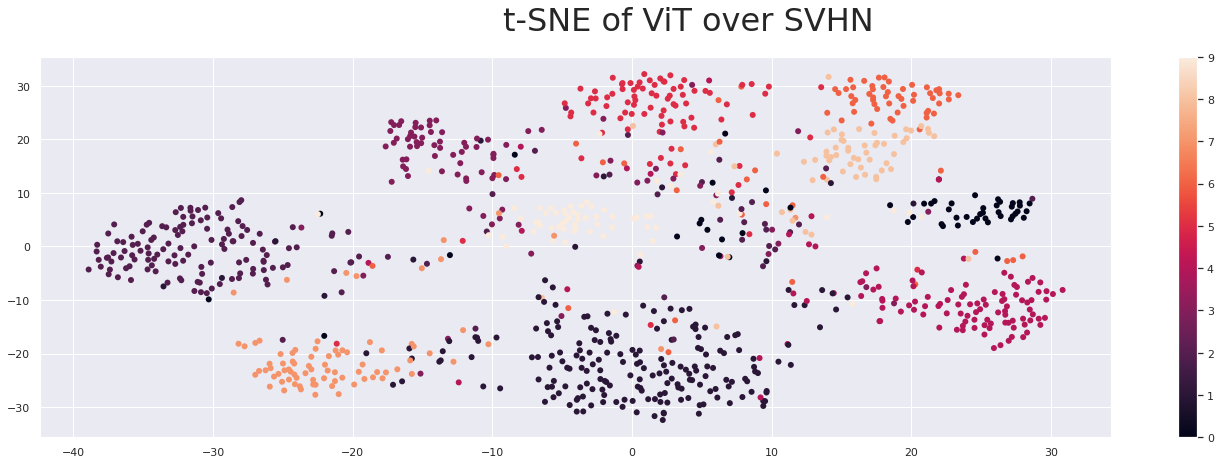

In [ ]:
acvecnp = [ac.detach().numpy() for ac in act_vecs][:1000]
acvecnp2 = [ac.tolist()[0] for ac in acvecnp]
print(acvecnp2)
embed = TSNE(n_components=2).fit_transform(np.asarray(acvecnp2))
print(embed)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
plt.suptitle('t-SNE of ViT over SVHN', fontsize=32)
plt.sca(axs)
plt.scatter(embed[:, 0], embed[:, 1], c=label_vit_svhn[:1000], marker='o', edgecolor='none')
plt.colorbar(ticks=range(10))
plt.grid(True)
plt.savefig('SVHN_TSNE_ViT.pdf',bbox_inches='tight')

In [ ]:
accuracy, act_vectors, labels, predictions = evaluate_ViT_DUN(model=model_ViT_SVHN, prob_model=prob_model_ViT_SVHN, net=net_ViT_DUNvi_SVHN, test_loader=test_loader_SVHN)

26032
[========================================>] 100% [26032/26032]	 ETA: 0 Hrs 0 Minutes 0 SecondsAccuracy = 80.54317762753534


In [ ]:
print(np.asarray(act_vectors).shape)
actvec_embedded = []
for i in range(np.asarray(act_vectors).shape[1]):
  actvec_embedded.append(TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]))

(26032, 5, 1, 10)


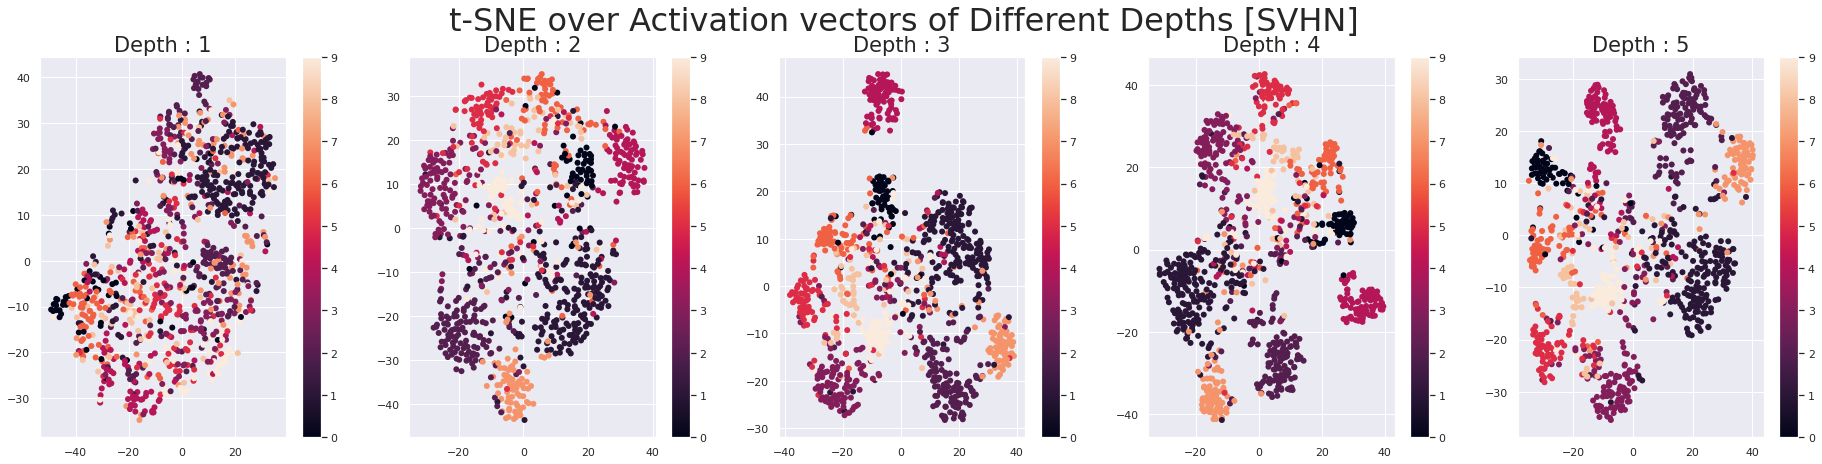

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=np.asarray(act_vectors).shape[1], figsize=(32,7))
plt.suptitle('t-SNE over Activation vectors of Different Depths [SVHN]', fontsize=32)
# plt.tight_layout()
for i, ax in enumerate(axs.flatten()):
    # X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :])
    X_embedded = actvec_embedded[i]
    plt.sca(ax)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels[:1000], marker='o', edgecolor='none')
    plt.colorbar(ticks=range(10))
    plt.grid(True)
    plt.title('Depth : {}'.format(i+1), fontsize=21)
plt.savefig('SVHN_TSNE_DUN.pdf',bbox_inches='tight')

### Testing model over Rotated SVHN

In [ ]:
rot_accuracy_Vit, rot_angles_Vit, rot_acc_unc_vit = evaluate_ViT_on_rotated(model=ViT_encoder_svhn, test_loader=test_loader_SVHN, use_gpu=False, test_sample_size=1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


[=========================================>] 102% [37/36]	 ETA: -1 Hrs 59 Minutes 52 Seconds

In [ ]:
print(rot_acc_unc_vit)

[22.824755433845144, 25.153841241818736, 32.00453648824711, 40.6217800632548, 50.97606308549775, 61.57838824583234, 69.82340877345564, 77.71948141076524, 83.14142906957862, 85.67492719824402, 86.46442192473454, 88.53457344341724, 89.99589566144493, 90.83555565996919, 90.73868712422052, 89.90922765267227, 89.8242070853299, 89.13533796787692, 87.25059825335121, 87.94847444928901, 86.57414200934912, 90.02150656618632, 87.72002766783892, 88.54771025486423, 88.42352896442742, 87.75573154537116, 87.87520338608648, 88.27300574117346, 86.37749169102123, 85.45260901768873, 84.08728466793025, 82.56119748089144, 79.76703855527393, 79.9270863863987, 74.87317238263512, 71.0511860172888, 69.63947066608522]


In [ ]:
rot_accuracy_DUN, rot_angles_DUN, pred_avg_stds, rot_acc_unc_DUN = evaluate_ViT_DUN_on_rotated(model=model_ViT_SVHN, prob_model=prob_model_ViT_SVHN, net=net_ViT_DUNvi_SVHN, test_loader=test_loader_SVHN,test_sample_size=1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


[=========================================>] 102% [37/36]	 ETA: -1 Hrs 59 Minutes 55 Seconds

In [ ]:
print(rot_acc_unc_DUN)
print(rot_accuracy_DUN)

[-474.2246367447078, -419.55068207681177, -368.21747265830635, -291.59633909966794, -209.70858552753924, -115.73614614056423, -49.71501357750967, -10.360829290514811, 27.588531961059196, 57.05739545174875, 93.55774879544042, 102.9567062113434, 85.46226127026603, 97.02110991957598, 107.98467386794509, 98.67913016434758, 86.82361186048948, 83.95459312200546, 82.34556795007083, 66.86735566472635, 61.302537446003406, 57.386258182860914, 51.786937915999445, 58.61893429681659, 46.272131083207206, 59.33948835497722, 43.19393151351251, 53.505994432838634, 46.02222490552813, 31.425276079494505, 17.783815011940895, -3.517876610439271, -9.524465994071216, -25.00089794690721, -66.36932994863018, -58.89045311650261, -52.310332177393136]
[80.9, 75.6, 70.7, 64.1, 54.0, 39.2, 28.4, 23.3, 17.9, 13.8, 9.5, 7.9, 10.8, 10.3, 7.6, 9.3, 12.2, 14.7, 13.5, 14.3, 14.3, 14.3, 15.0, 13.3, 14.5, 13.2, 13.8, 13.6, 13.3, 15.5, 16.2, 17.6, 17.9, 24.0, 29.1, 30.7, 29.3]


In [ ]:
sns.set_palette("cubehelix")
fig, axs = plt.subplots(1, figsize=(21, 11))

fig.suptitle('Rotation vs Test Accuracy (SVHN)', fontsize=51)
# fig.tight_layout()

sns.lineplot(x=rot_angles_Vit, y=rot_accuracy_Vit, ax=axs,label='ViT');
sns.scatterplot(x=rot_angles_Vit, y=rot_accuracy_Vit, ax=axs);

sns.lineplot(x=rot_angles_DUN, y=rot_accuracy_DUN, ax=axs,label='ViT + DUN');
sns.scatterplot(x=rot_angles_DUN, y=rot_accuracy_DUN, ax=axs);
#axs.fill_between(rot_angles, torch.tensor(rot_accuracy)-torch.tensor(pred_avg_stds)*10, torch.tensor(rot_accuracy)+torch.tensor(pred_avg_stds)*10,alpha=0.3)

axs.set_ylabel("Test Accuracy", fontsize=32)
axs.set_xlabel("Rotation (in degrees)", fontsize=32)
axs.legend()

axs.tick_params(axis='both', which='major', labelsize=21)
plt.savefig('RotAcc_SVHN.pdf',bbox_inches='tight')

## Training Vision Transformer over Fashion MNIST dataset


Extracting ./data/fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw




Extracting ./data/fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw




Extracting ./data/fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw




Extracting ./data/fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Epoch: 1
[    0/60000 (  0%)]  Loss: 2.5460
[10000/60000 ( 17%)]  Loss: 0.6800
[20000/60000 ( 33%)]  Loss: 0.5469
[30000/60000 ( 50%)]  Loss: 0.3555
[40000/60000 ( 67%)]  Loss: 0.5455
[50000/60000 ( 83%)]  Loss: 0.3631

Average test loss: 0.4178  Accuracy: 8502/10000 (85.02%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.4370
[10000/60000 ( 17%)]  Loss: 0.3926
[20000/60000 ( 33%)]  Loss: 0.4233
[30000/60000 ( 50%)]  Loss: 0.4106
[40000/60000 ( 67%)]  Loss: 0.3526
[50000/60000 ( 83%)]  Loss: 0.3614

Average test loss: 0.3983  Accuracy: 8561/10000 (85.61%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.3540
[10000/60000 ( 17%)]  Loss: 0.2466
[20000/60000 ( 33%)]  Loss: 0.2077
[30000/60000 ( 50%)]  Loss: 0.3141
[40000/60000 ( 67%)]  Loss: 0.4205
[50000/60000 ( 83%)]  Loss: 0.3695

Average test loss: 0.3955  Accuracy: 8559/10000 (85.59%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.2892
[10000/60000 ( 17%)]  Loss: 0.4149
[20000/60000 ( 33%)]  Loss: 0.2703
[30000/60000 ( 50%)]  Loss: 0.2598
[40000/6000

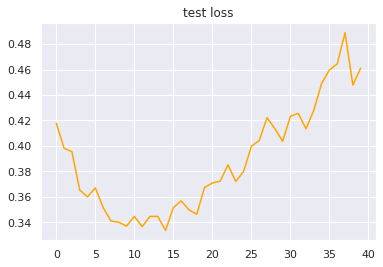

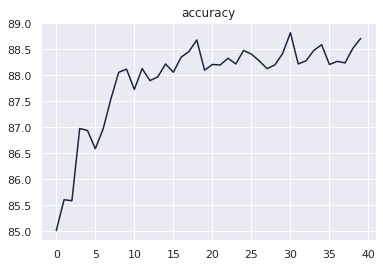

In [ ]:
import torch.optim as optim
import torchvision
import time


DOWNLOAD_PATH = './data/fashion'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_fashion = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(mean=(0.2860,), std=(0.3530,))])

train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_fashion)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_fashion)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

N_EPOCHS = 40

start_time = time.time()
optimizer = optim.Adam(ViT_encoder_fashion.parameters(), lr=0.003)

train_loss_history_vit_fashion, test_loss_history_vit_fashion = [], []
epoch_acc_vit_fashion = []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(ViT_encoder_fashion, optimizer, train_loader, train_loss_history_vit_fashion)
    acc = evaluate(ViT_encoder_fashion, test_loader, test_loss_history_vit_fashion)
    epoch_acc_vit_fashion.append(acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import matplotlib.pyplot as plt
#print(train_loss_history)
plt.title('train loss')
plt.plot(train_loss_history_vit_fashion,c='blue',label='train')
plt.show()

plt.title('test loss')
plt.plot(test_loss_history_vit_fashion,c='orange',label='test')
plt.show()

plt.title('accuracy')
plt.plot(epoch_acc_vit_fashion)
plt.show()


## Training and Evaluation of DUN based Vision Transformer over Fashion-MNIST Dataset

In [ ]:
import argparse
import os
import shutil
import time
import glob

import numpy as np
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed

best_err1 = 1
lr = 0.003
momentum = 0.9

dataset = 'Fashion'
workers = 0
epochs = 40
weight_decay = 1e-4
savedir = './results/'
batch_size = 256
data_dir = './data/fashion/'
start_depth = 1
end_depth = 11


milestone_dict = {
    'Imagenet': [30, 60],  # This is pytorch default
    'SmallImagenet': [30, 60],
    'CIFAR10': [150, 225],
    'CIFAR100': [150, 225],
    'SVHN': [50, 70],
    'Fashion': [40, 70],
    'MNIST': [40, 70]
}

milestones = None

cuda = torch.cuda.is_available()
print('cuda', cuda)

input_chanels = 1
num_classes = 10

n_layers = end_depth - start_depth

prior_probs = [1 / (n_layers)] * (n_layers)
prob_model = depth_categorical_VI(prior_probs, cuda=cuda)

model = ViT_DUN_encoder_fashion
N_train = 0
net = DUN_VI(model, prob_model, N_train, lr=lr, momentum=momentum, weight_decay=weight_decay, cuda=cuda, schedule=milestones, regression=False, pred_sig=None)
all_results_fashion, epoch_acc_fashion = train_loop(net, dname=dataset, data_dir=data_dir, epochs=epochs, workers=workers, savedir=savedir,q_nograd_its=0, batch_size=batch_size)

model_ViT_FashionMNIST = model
prob_model_ViT_FashionMNIST = prob_model
net_ViT_DUNvi_FashionMNIST = net

cuda False

Net:
    Total params: 0.19M


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()



 depth approx posterior [0.05979818 0.08374327 0.09642617 0.10249691 0.10669041 0.10953082
 0.11070601 0.11047806 0.11023024 0.10989984]
it 0/40, ELBO/evidence -635.8455, pred minus loglike = 1.036618, err = 0.345033   time: 47.373253 seconds

Test Accuracy: 77.64
     pred minus loglike = 0.605666, err = 0.223700
    time: 3.757351 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.223700
[=>                                      ] 2% [1/40]	 ETA: 0 Hrs 35 Minutes 52 Seconds
 depth approx posterior [0.05334692 0.08125289 0.09617381 0.10343698 0.10821266 0.11119669
 0.11214533 0.11191209 0.11147679 0.11084586]
it 1/40, ELBO/evidence -318.7779, pred minus loglike = 0.522969, err = 0.188650   time: 46.800163 seconds

Test Accuracy: 80.44
     pred minus loglike = 0.527891, err = 0.195500
    time: 3.878687 seconds

Writting ./results/checkpoint.pth.tar

best top1 dev err: 0.195500
[==>                                     ] 5% [2/40]	 ETA: 0 Hrs 34 Minutes 46 Seconds
 de

[tensor(85.0200), tensor(85.6100), tensor(85.5900), tensor(86.9800), tensor(86.9400), tensor(86.5900), tensor(86.9700), tensor(87.5500), tensor(88.0600), tensor(88.1200), tensor(87.7300), tensor(88.1300), tensor(87.9000), tensor(87.9700), tensor(88.2200), tensor(88.0600), tensor(88.3500), tensor(88.4600), tensor(88.6800), tensor(88.1000), tensor(88.2100), tensor(88.2000), tensor(88.3300), tensor(88.2200), tensor(88.4800), tensor(88.4100), tensor(88.2800), tensor(88.1300), tensor(88.2000), tensor(88.4200), tensor(88.8200), tensor(88.2200), tensor(88.2800), tensor(88.4800), tensor(88.5900), tensor(88.2100), tensor(88.2700), tensor(88.2400), tensor(88.5200), tensor(88.7100)]
[85.0199966430664, 85.61000061035156, 85.58999633789062, 86.9800033569336, 86.94000244140625, 86.58999633789062, 86.97000122070312, 87.55000305175781, 88.05999755859375, 88.12000274658203, 87.7300033569336, 88.12999725341797, 87.9000015258789, 87.97000122070312, 88.22000122070312, 88.05999755859375, 88.3499984741211, 

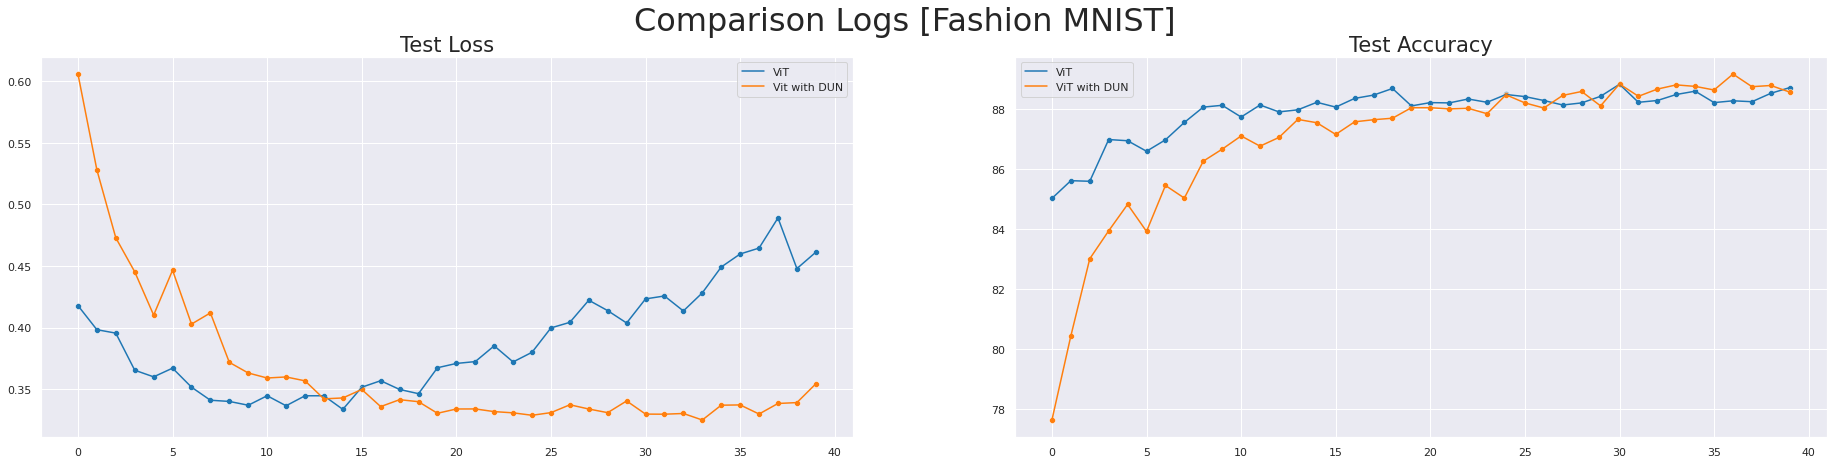

In [ ]:
sns.set_palette("tab10")
fig, axs = plt.subplots(nrows=1, ncols=len(all_results_fashion)-2, figsize=(32,7))
plt.suptitle('Training Logs [Fashion]', fontsize=32)
# plt.tight_layout()
all_results_label = ["marginal_loglike", "err_train", "train_loss", "err_dev", "dev_loss"]
all_results_label = ["marginal_loglike", "err", "loss", "err_dev", "dev_loss"]

sns.lineplot(x=np.arange(len(all_results_fashion[0])), y=all_results_fashion[0], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_fashion[0])), y=all_results_fashion[0], ax=axs[0]);
axs[0].grid(True)
axs[0].set_title(all_results_label[0], fontsize=21)
 
for i, ax in enumerate(axs.flatten()[1:]):
    plt.sca(ax)
    sns.lineplot(x=np.arange(len(all_results_fashion[i+1])), y=all_results_fashion[i+1], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_fashion[i+1])), y=all_results_fashion[i+1], ax=ax);
    
    sns.lineplot(x=np.arange(len(all_results_fashion[i+3])), y=all_results_fashion[i+3], ax=ax);
    sns.scatterplot(x=np.arange(len(all_results_fashion[i+3])), y=all_results_fashion[i+3], ax=ax);
    
    plt.grid(True)
    plt.title(all_results_label[i+1], fontsize=21)

plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(32,7))
plt.suptitle('Comparison Logs [Fashion MNIST]', fontsize=32)

'''
axs[0].grid(True)
axs[0].set_title('Training Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=train_loss_history_vit_mnist, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
sns.scatterplot(x=np.arange(len(all_results_DUN_mnist[2])), y=all_results_DUN_mnist[2], ax=axs[0]);
'''
axs[0].grid(True)
axs[0].set_title('Test Loss', fontsize=21)
sns.lineplot(x=np.arange(len(all_results_fashion[4])), y=test_loss_history_vit_fashion, ax=axs[0],label='ViT');
sns.scatterplot(x=np.arange(len(all_results_fashion[4])), y=test_loss_history_vit_fashion, ax=axs[0]);
sns.lineplot(x=np.arange(len(all_results_fashion[4])), y=all_results_fashion[4], ax=axs[0],label='Vit with DUN');
sns.scatterplot(x=np.arange(len(all_results_fashion[4])), y=all_results_fashion[4], ax=axs[0]);
print(epoch_acc_vit_fashion)
ep_acc_vit_np = [e.item() for e in epoch_acc_vit_fashion]
print(ep_acc_vit_np)
axs[1].grid(True)
axs[1].set_title('Test Accuracy', fontsize=21)
sns.lineplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1],label='ViT');
sns.scatterplot(x=np.arange(len(ep_acc_vit_np)), y=ep_acc_vit_np, ax=axs[1]);
sns.lineplot(x=np.arange(len(epoch_acc_fashion)), y=epoch_acc_fashion, ax=axs[1],label='ViT with DUN');
sns.scatterplot(x=np.arange(len(epoch_acc_fashion)), y=epoch_acc_fashion, ax=axs[1]);

#plt.show()
plt.savefig("Compare_Log_FashionMNIST.pdf", bbox_inches='tight')



In [ ]:
DOWNLOAD_PATH = './data/fashion'
BATCH_SIZE_TEST = 1

transform_fashion = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(mean=(0.2860,), std=(0.3530,))])


test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_fashion)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

test_loader_FashionMNIST = test_loader

### Plot t-SNE over activation vectors

In [ ]:
#X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]
act_vecs = []
label_vit_fashion = []
for i, (data, target) in enumerate(test_loader_FashionMNIST):
    output = ViT_encoder_fashion(data)
    act_vecs.append(output)
    label_vit_fashion.append(target)
#print(act_vecs)

[[0.9454275965690613, 2.775056838989258, -3.5737862586975098, 9.517967224121094, -0.07376819849014282, -5.000004768371582, -1.0451630353927612, -5.594645977020264, 2.6233010292053223, -3.6548359394073486], [-4.502020835876465, -1.6408442258834839, -1.3568426370620728, -1.5371893644332886, -0.28701287508010864, -1.8215231895446777, -5.695212364196777, 7.945193290710449, -0.09534162282943726, 14.487060546875], [-0.38655591011047363, -3.977935314178467, -2.461289405822754, 1.329928994178772, -3.9056060314178467, 1.8529744148254395, -2.9207983016967773, -1.001809000968933, 16.1728515625, 1.0106121301651], [-1.084406852722168, -1.704966425895691, -4.068873405456543, -5.550910472869873, 2.316958427429199, 2.586848735809326, -0.660912275314331, 13.667943954467773, -5.856400489807129, 1.419113039970398], [12.542017936706543, -3.432285785675049, -1.857140064239502, -2.3824758529663086, -0.6468108296394348, -3.6203813552856445, 1.2209175825119019, -2.6583797931671143, -5.378824710845947, -6.8500

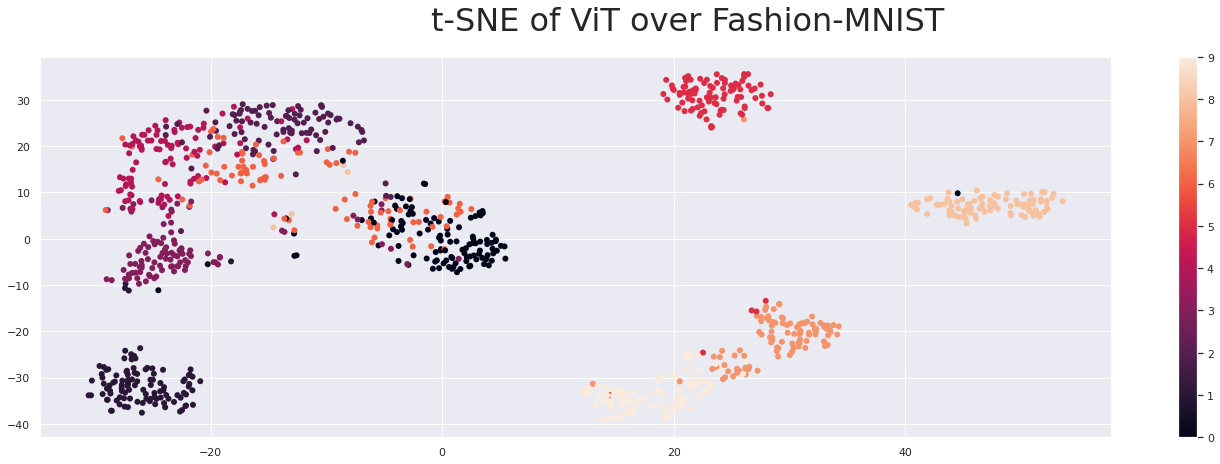

In [ ]:
acvecnp = [ac.detach().numpy() for ac in act_vecs][:1000]
acvecnp2 = [ac.tolist()[0] for ac in acvecnp]
print(acvecnp2)
embed = TSNE(n_components=2).fit_transform(np.asarray(acvecnp2))
print(embed)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
plt.suptitle('t-SNE of ViT over Fashion-MNIST', fontsize=32)
plt.sca(axs)
plt.scatter(embed[:, 0], embed[:, 1], c=label_vit_fashion[:1000], marker='o', edgecolor='none')
plt.colorbar(ticks=range(10))
plt.grid(True)
plt.savefig('FashionMNIST_TSNE_ViT.pdf',bbox_inches='tight')

In [ ]:
accuracy, act_vectors, labels, predictions = evaluate_ViT_DUN(model=model_ViT_FashionMNIST, prob_model=prob_model_ViT_FashionMNIST, net=net_ViT_DUNvi_FashionMNIST, test_loader=test_loader_FashionMNIST)

10000
[========================================>] 100% [10000/10000]	 ETA: 0 Hrs 0 Minutes 0 SecondsAccuracy = 88.56


In [ ]:
actvec_embedded = []
for i in range(10):
  actvec_embedded.append(TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :]))

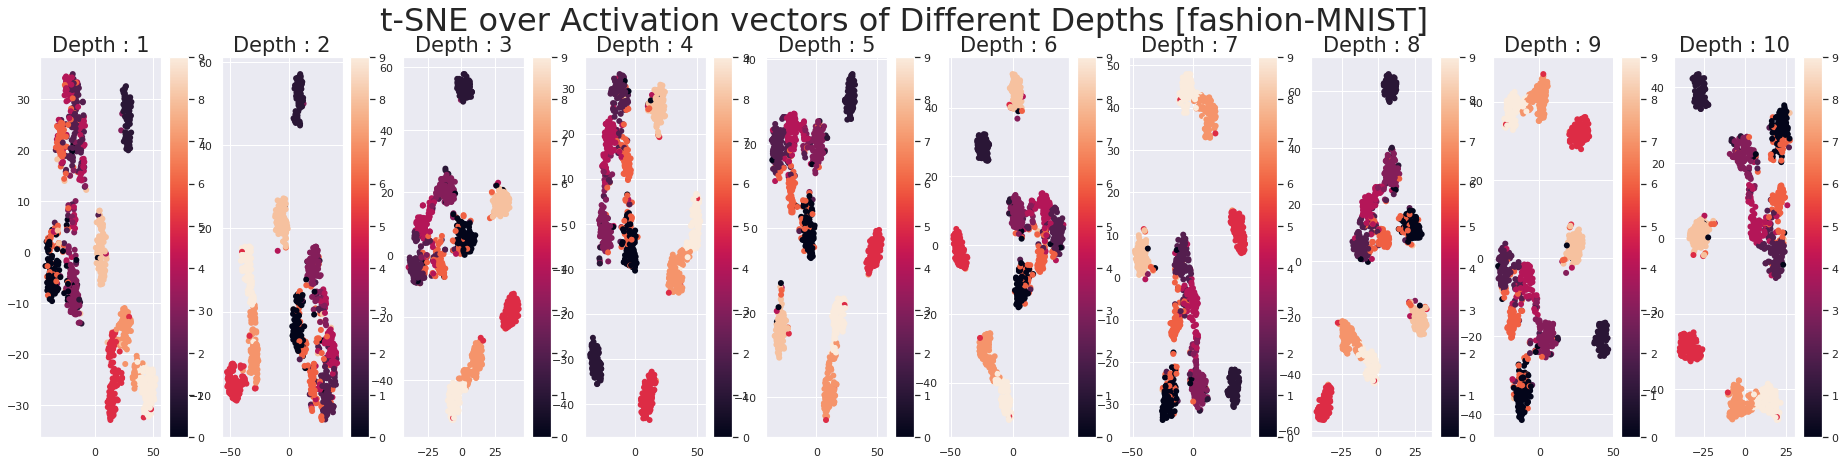

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(32,7))
plt.suptitle('t-SNE over Activation vectors of Different Depths [fashion-MNIST]', fontsize=32)
# plt.tight_layout()
for i, ax in enumerate(axs.flatten()):
    # X_embedded = TSNE(n_components=2).fit_transform(np.asarray(act_vectors)[:1000, i, 0, :])
    X_embedded = actvec_embedded[i]
    plt.sca(ax)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels[:1000], marker='o', edgecolor='none')
    plt.colorbar(ticks=range(10))
    plt.grid(True)
    plt.title('Depth : {}'.format(i+1), fontsize=21)
plt.savefig('FashionMNIST_TSNE_DUN.pdf',bbox_inches='tight')